# import libaries

In [3]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import sys
import os
import json
import pandas as pd 
import seaborn as sns 
import pickle
import string

import matplotlib.patches as mpatches
import textwrap
from cartopy.util import add_cyclic_point 
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

import utils_v1v2 as v1v2
import utils_PPE as misc 
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

import cartopy.feature as cfeature
from global_land_mask import globe

import matplotlib as mpl
mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.labelsize'] = 6.5
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['axes.titlesize'] = 7 

workdir = '/qfs/people/qiny108/ppe_scripts/'
figdir = workdir+'figure2/'

regime_method_tag = '_OceanOnly30SN'
middir = workdir+'middata/regime_partition'+regime_method_tag+'/' 

datadir_aer = '/qfs/people/qiny108/colla/diag_ERFaer/data/'
datadir_fbk = '/qfs/people/qiny108/diag_feedback_E3SM/data_ppe_2010to2012/'
datadir_fbk_tmp = '/qfs/people/qiny108/diag_feedback_E3SM/data_ppe_2010to2012/' 

lat_spc = np.arange(-90,90,2.5)
lon_spc = np.arange(0,360,2.5) 
print(f'lat_spc.shape={lat_spc.shape}, lon_spc.shape={lon_spc.shape}') 

from datetime import date
today = date.today()
dd = today.strftime("%Y-%m-%d")
print(dd)

import importlib
importlib.reload(v1v2) 
importlib.reload(misc) 

lat_spc.shape=(72,), lon_spc.shape=(144,)
2024-10-02


<module 'utils_PPE' from '/qfs/people/qiny108/ppe_scripts/publish_scripts/utils_PPE.py'>

# DEFINE cases

In [6]:
from utils_PPE import ctlc, turbc

regions = misc.define_regions() 
print('regions=',regions)
print()
catags = misc.define_catags() 
print(f'catags = {catags}') 

casesA = [
    ['BASE', ctlc],
    ['c1', turbc],
    ['c1_2',turbc],
    ['c1_3',turbc],
    ['c1_4',turbc], 
    ['gamma_coef', turbc],
    ['gamma_coef_2',turbc], 
    ['gamma_coef_3',turbc],
    ['gamma_coef_4',turbc], 
    ['gamma_coefb',turbc],
    ['gamma_coefb_2',turbc],
    ['gamma_coefb_3',turbc], 
    ['c8', turbc],
    ['c8_2',turbc],
    ['c8_3',turbc],
    ['c8_4',turbc], 
    ]

cases = [case[0] for case in casesA]
colorsh = [case[1] for case in casesA]

print(len(cases),cases)

regions= {'Globe': [-90, 90, 0, 360], '30-60S': [-60, -30, 0, 360], '30-60N': [30, 60, 0, 360], '30S-30N': [-30, 30, 0, 360], '60-90S': [-90, -60, 0, 360], '60-90N': [60, 90, 0, 360]}

catags = [['warm rain', 'tab:blue'], ['mixed phase', 'tab:orange'], ['turbulence', 'tab:red'], ['deep convection', 'tab:purple'], ['All', 'black']]
16 ['BASE', 'c1', 'c1_2', 'c1_3', 'c1_4', 'gamma_coef', 'gamma_coef_2', 'gamma_coef_3', 'gamma_coef_4', 'gamma_coefb', 'gamma_coefb_2', 'gamma_coefb_3', 'c8', 'c8_2', 'c8_3', 'c8_4']


# DEFINE parameter group

In [7]:
exp_list = [
        'c1', 'c8',
        'gamma_coef','gamma_coefb', 
        ]

# ========================================== 
dicc,dicr = misc.get_param_group_dic(exp_list) 

print(len(dicc.keys()),dicc.keys())
cases_t = [] 
for key in dicc.keys():
    for ii in range(len(dicc[key])): 
        tmp = dicc[key][ii][0]
        if tmp not in cases_t: 
            cases_t.append(tmp)

for tt in cases:
    if tt not in cases_t: 
        print(tt, 'is in cases, but not in cases_t.') 

print('total PPE count=',len(cases_t), 'len(cases)=',len(cases)) 
print(cases_t)

4 dict_keys(['c1', 'c8', 'gamma_coef', 'gamma_coefb'])
total PPE count= 16 len(cases)= 16
['BASE', 'c1', 'c1_2', 'c1_3', 'c1_4', 'c8', 'c8_2', 'c8_3', 'c8_4', 'gamma_coef', 'gamma_coef_2', 'gamma_coef_3', 'gamma_coef_4', 'gamma_coefb', 'gamma_coefb_2', 'gamma_coefb_3']


# [!] DEFINE regimes and data source

In [8]:
what_state = 'avgCTLP4K' # 'CTL','P4K','avgCTLP4K'

if regime_method_tag in ['_OceanOnly30SN']:  
    regimes = ['TropMarineLow','TropAscent','NH-MidLat-Ocn','SH-MidLat-Ocn','NH-HiLat-Ocn', 'SH-HiLat-Ocn', 'Global-Ocn']
    colorsh = v1v2.get_color('tab10',len(regimes))

    regimes_plot = ['Global-Ocn','TropMarineLow','TropAscent','NH-MidLat-Ocn','SH-MidLat-Ocn','NH-HiLat-Ocn', 'SH-HiLat-Ocn',]


Vars_state_fbk = [
    'CLOUD', 
    'CLDLIQ', 'CLDICE', 
    'CLDTOT','CLDLOW',
    'CDNUMC', 
    'EIS', 'LTS', 
    'LHFLX', 'SHFLX',
    'TS', 'TREFHT',
    'QRL', 'QRS',
    'DPDLFLIQ', 
    'ZMDLIQ', 'RCMTEND_CLUBB', 'MPDLIQ',
    # 'TGCLDCWP','TGCLDLWP','TGCLDIWP',
    'LWP_LS','LWP_CONV','TGCLDIWP', 'IWP_LS',
    'WP2_CLUBB', 
    'WP3_CLUBB', 
    'SKW_ZM', 'SKW_ZT',
    'FREQZM', 'CMFMCDZM', 
    'OMEGA', 'T', 'Q', 
    # 'RTP2_CLUBB', 'RTPTHLP_CLUBB', 'THLP2_CLUBB','WPRCP_CLUBB', 'WPRTP_CLUBB', 'WPTHLP_CLUBB', 
    'WPTHVP_CLUBB','WPRTP_CLUBB', 'WPTHLP_CLUBB','WPRCP_CLUBB', 
    'CDNUMC_INLIQCLD','LWP_INLIQCLD','LIQCLD',
    'ZMDQ', 'RVMTEND_CLUBB', 'MPDQ', 
    'ZMDT', 'TTEND_CLUBB','MPDT','QRL','QRS',
    ]

Vars_state_aci = [
    'LWP_LS','LWP_CONV','TGCLDIWP',
    'WP2_CLUBB',
    'WP3_CLUBB',
    'CDNUMC','TAUTMODIS','TAUTLOGMODIS','TAUWMODIS','TAUWLOGMODIS','TAUIMODIS','TAUILOGMODIS',
    'CLDLIQ', 
    'ENTRAT','ENTRATP','ENTRATN',
    'ENTEFF','ENTEFFP','ENTEFFN',
] 

print(regime_method_tag, regimes)

_OceanOnly30SN ['TropMarineLow', 'TropAscent', 'NH-MidLat-Ocn', 'SH-MidLat-Ocn', 'NH-HiLat-Ocn', 'SH-HiLat-Ocn', 'Global-Ocn']


# [!] Define specific regimes for further analysis
> i.e., TropAscent, TropMarineLow, and SH-MidLat-Ocn

In [9]:
regimes_here = [
    # ['Global-Ocn', 'Global-Ocn', ['turbulence'], [turbc],'tab:grey'], 
    ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
    ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
    ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
]

# List of variables which have pressure level as coordinate 
var3d = ['WP2_CLUBB','WP3_CLUBB','SKW_ZT','CMFMCDZM','RELHUM','OMEGA','CLDLIQ',
         'WPTHVP_CLUBB','WPTHLP_CLUBB','WPRCP_CLUBB','WPRTP_CLUBB','Q','T'] 

# =================================

# Cloud regime decomposition

## Read ensemble mean of omega700

Read available data:  (73, 144)


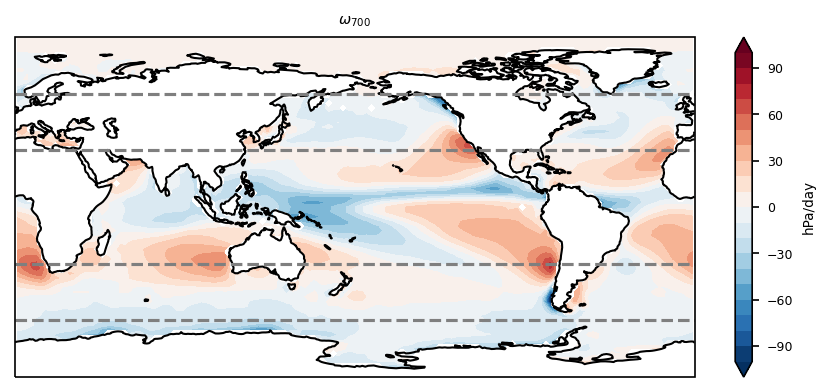

In [13]:
fomega = 'omega700_mm.nc'

if os.path.isfile(fomega): 
    ff = xr.open_dataset(fomega)
    omega700_pi_mm  = ff['omega700_pi_mm']
    omega700_ab_mm  = ff['omega700_ab_mm']
    omega700_avg_mm = ff['omega700_avg_mm']
    ff.close()

    print('Read available data: ',omega700_pi_mm.shape)

# =========== check spatial map ===== 
fig = plt.figure(figsize=(7,3),dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(180.))

datap = omega700_pi_mm
lats, lons = datap.lat, datap.lon 
lons_here = np.where(lons>180,lons-360,lons)
lon_grid,lat_grid = np.meshgrid(lons_here,lats)
globe_land_mask = globe.is_land(lat_grid,lon_grid)  

datapp = datap.where(globe_land_mask==False)
im = ax.contourf(datap.lon,datap.lat,datapp,transform=ccrs.PlateCarree(),
                cmap='RdBu_r',
                levels=np.arange(-100,110,10),
                extend='both')

# contours = ax.contour(datap.lon,datap.lat,datapp,transform=ccrs.PlateCarree(), colors=['black','blue'], 
#            levels=[0,10])
# ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f') 

ax.coastlines()
ax.set_global()

ax.set_title('$\omega_{700}$')

fig.colorbar(im,fraction=0.025,label='hPa/day')

# for ypos in [-60,-45,-30,30,45,60]:
for ypos in [-60,-30,30,60]:
    ax.axhline(y=ypos,ls='--',c='tab:grey')


## Quick test new regime partitioning of CF and ERFaci

### CF map

TropMarineLow
TropMarineLow 0.21030345034551934
-3.722733141240657 6.868229236959057
TropAscent
TropAscent 0.1612714464479139
-1.6650399592310767 4.201799617330032
NH-MidLat-Ocn
NH-MidLat-Ocn 0.09361505674692926
-1.2463189002116457 2.1228470026538426
SH-MidLat-Ocn
SH-MidLat-Ocn 0.170679392385255
-1.9268652276807339 3.957119064976092
NH-HiLat-Ocn
NH-HiLat-Ocn 0.03582362245989341
-1.1778227086391884 1.8430384386419396
SH-HiLat-Ocn
SH-HiLat-Ocn 0.03760406187143704
-2.3120085097067897 0.7022176905552019
Global-Ocn
Global-Ocn 0.709297030256948
-3.722733141240657 6.868229236959057


(73, 145)


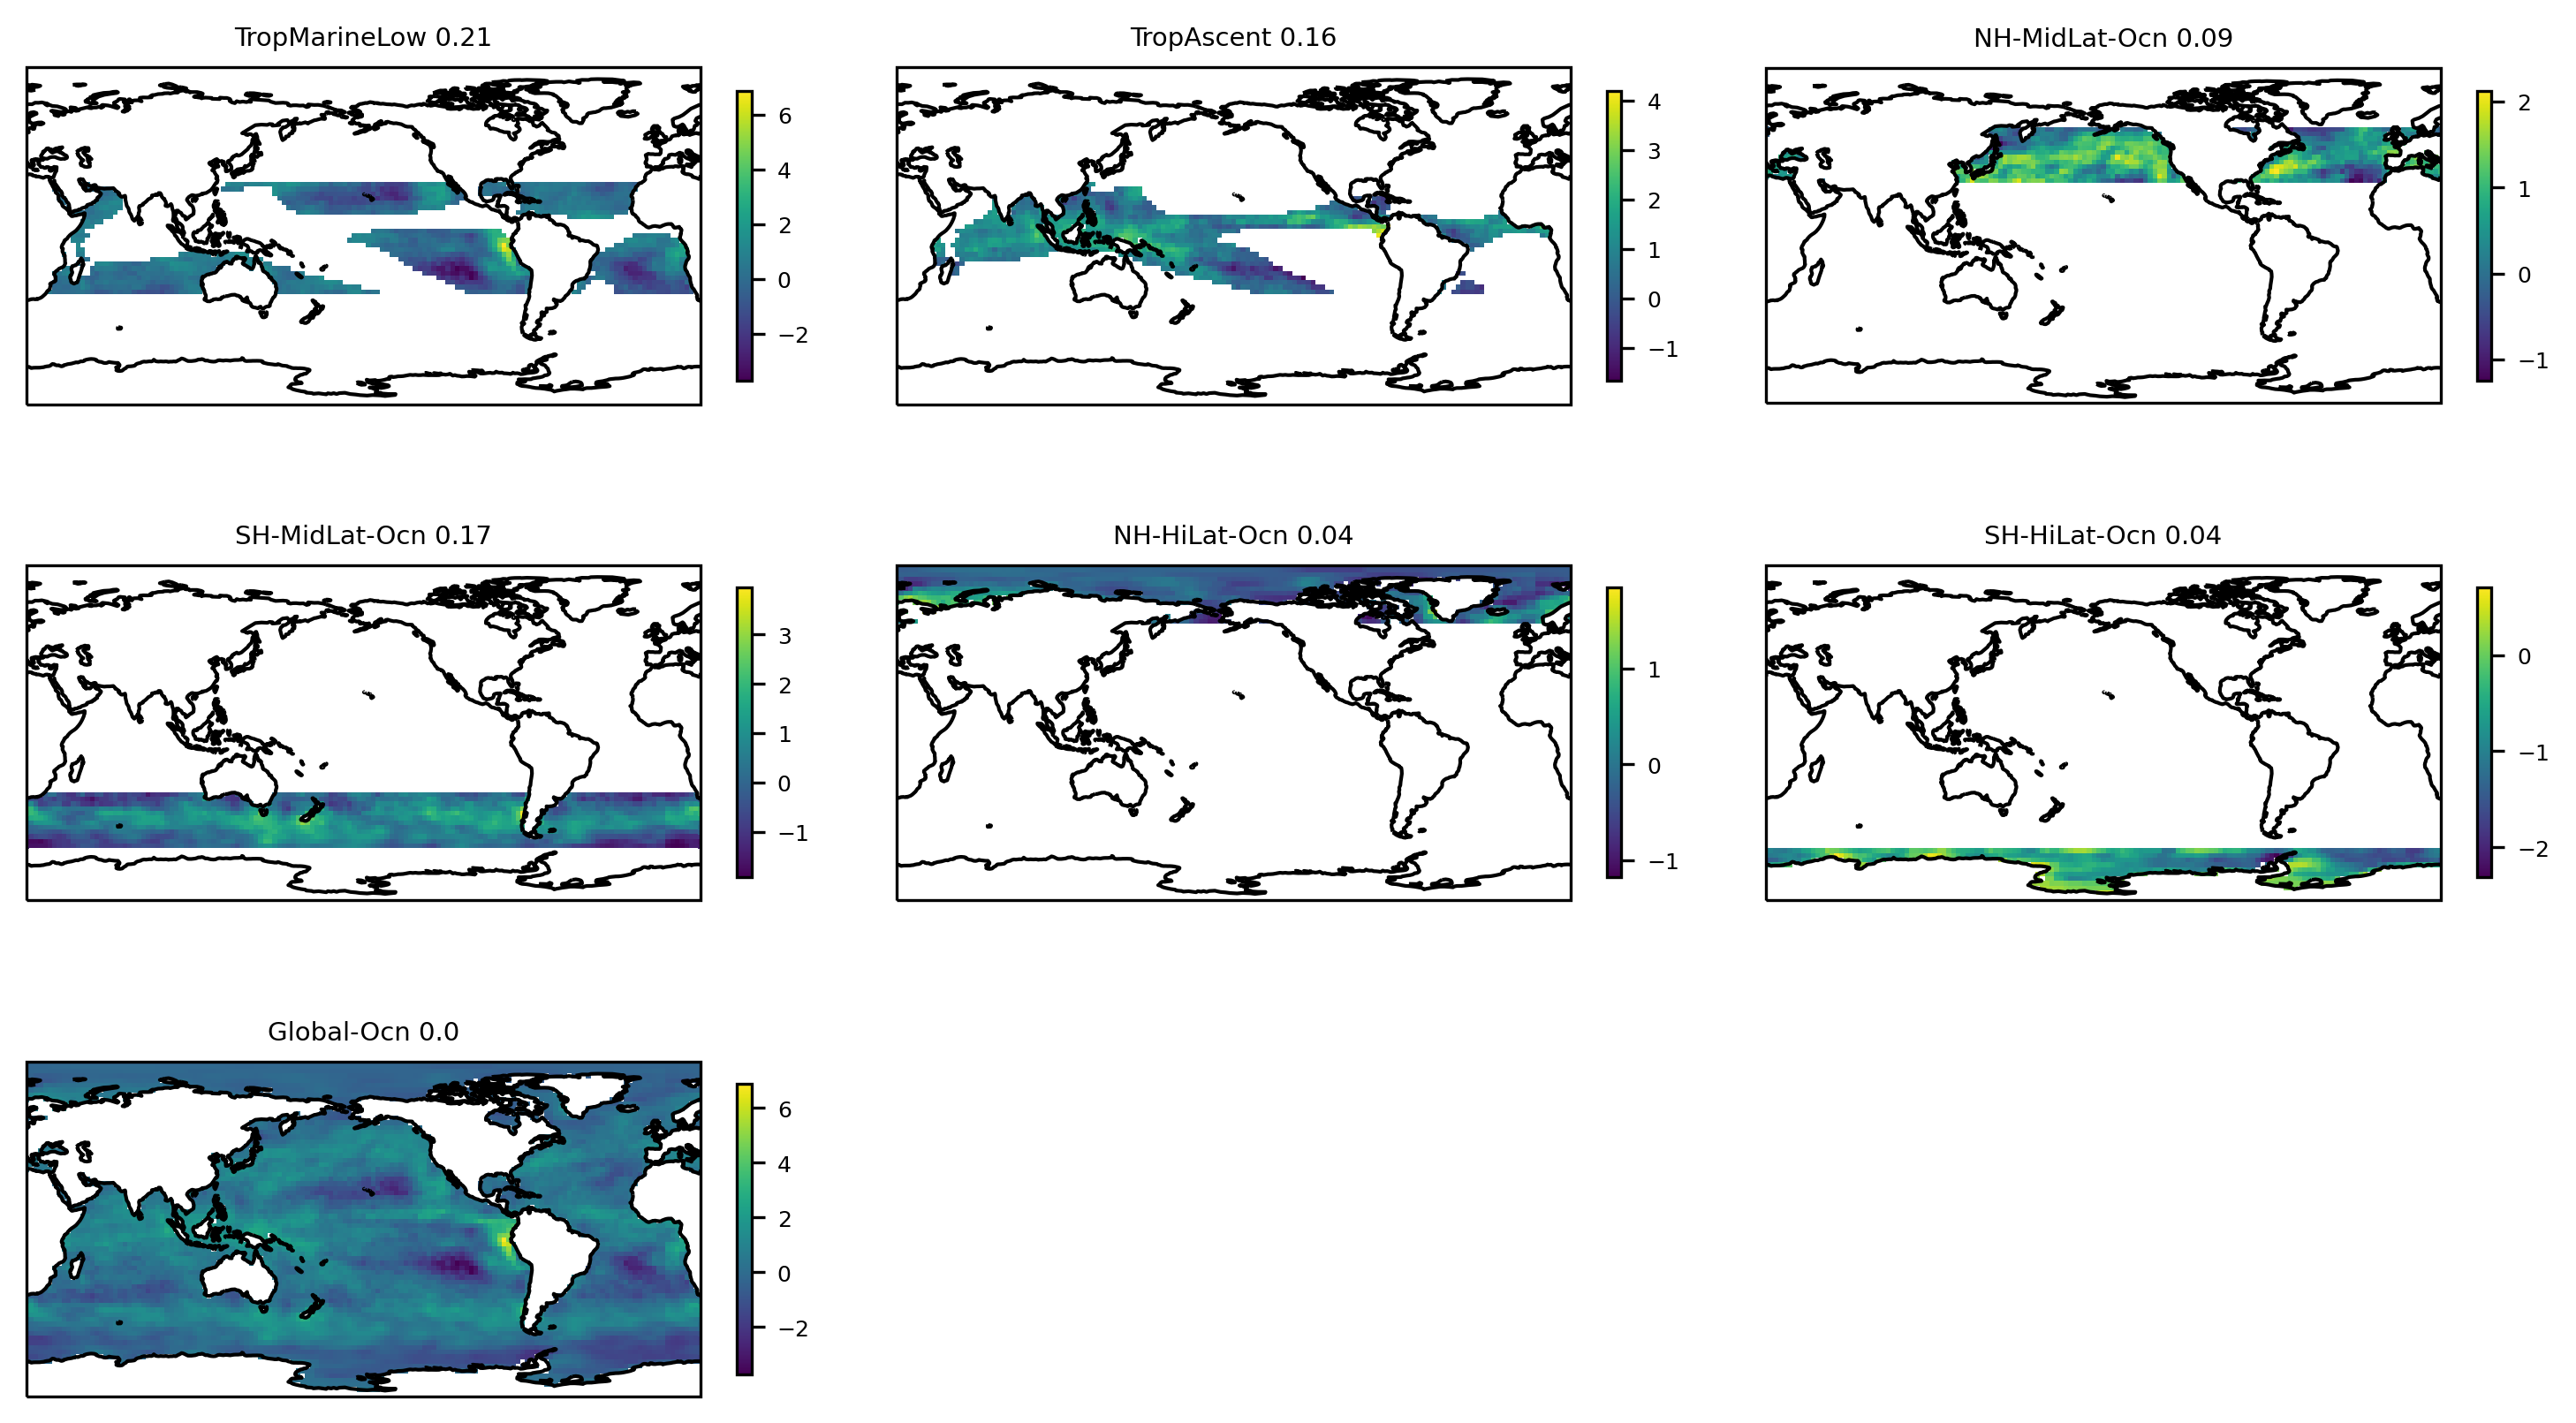

In [14]:
importlib.reload(v1v2) 

fig = plt.figure(figsize=(12,12),dpi=300)
nrow = 5
ncol = 3 

for ireg,reg in enumerate(regimes):
    print(reg)
    f1 = xr.open_dataset(datadir_fbk_tmp+'lat-lon-gfdbk-CMIP6-BASE.nc') 

    # ------ Read land fraction
    fname = datadir_fbk + 'global_LANDFRAC_BASE.nc'
    with xr.open_dataset(fname) as ff:
        landfrac = ff['LANDFRAC_pi_clim']     
    # ------
            
    ax = fig.add_subplot(nrow,ncol,ireg+1,projection=ccrs.PlateCarree(200)) 
    _,_,data2_avg,_,_,data2m_avg,_ = v1v2.regime_partitioning_4(reg,omega700_pi_mm, 
                                                                omega700_ab_mm, 
                                                                omega700_avg_mm, 
                                                                f1.netCRE_ano_grd_adj,
                                                                # landfrac
                                                                )
    print(reg, misc.area_averager(data2m_avg).values)

    if ireg == 0:
        frac_map = np.zeros((data2_avg.shape)) 
        frac_map[:] = np.nan 
    
    if reg not in ['Global', 'Global-Ocn','Global-Lnd']: 
        frac_map = xr.where(np.isnan(data2_avg),frac_map,ireg+1)

    # datap = landfrac.interp(lon=np.arange(0,362.5,2.5), lat=np.arange(-90,92.5,2.5), 
    # method='nearest',
    # kwargs = {"fill_value": "extrapolate"}
    # )
    datap = data2_avg 
    # datap = globe_land_mask 
    print(datap.min().values, datap.max().values)
    # datap = f1.netCRE_ano_grd_adj
    # print(datap.coords) 
    im = ax.pcolormesh(datap.lon, datap.lat, datap, transform=ccrs.PlateCarree(),cmap='viridis',
                    #    vmin=-4,vmax=4
                       )
    ax.coastlines()

    frac_avg = misc.area_averager(xr.where(frac_map==ireg+1,1.0,0.0)).values 
    ax.set_title(reg+' '+str(frac_avg.round(2))) 

    fig.colorbar(im,fraction=0.02)

# fig.tight_layout() 
print(frac_map.shape)


### ACI map

0 TropMarineLow 0.2103955007431096 0.2103955007431096
1 TropAscent 0.15901460456784042 0.36941010531095
2 NH-MidLat-Ocn 0.09361505674692926 0.46302516205787925
3 SH-MidLat-Ocn 0.170679392385255 0.6337045544431342
4 NH-HiLat-Ocn 0.03582362245989341 0.6695281769030277
5 SH-HiLat-Ocn 0.03760406187143704 0.7071322387744647
6 Global-Ocn 0.709297030256948 1.4164292690314126


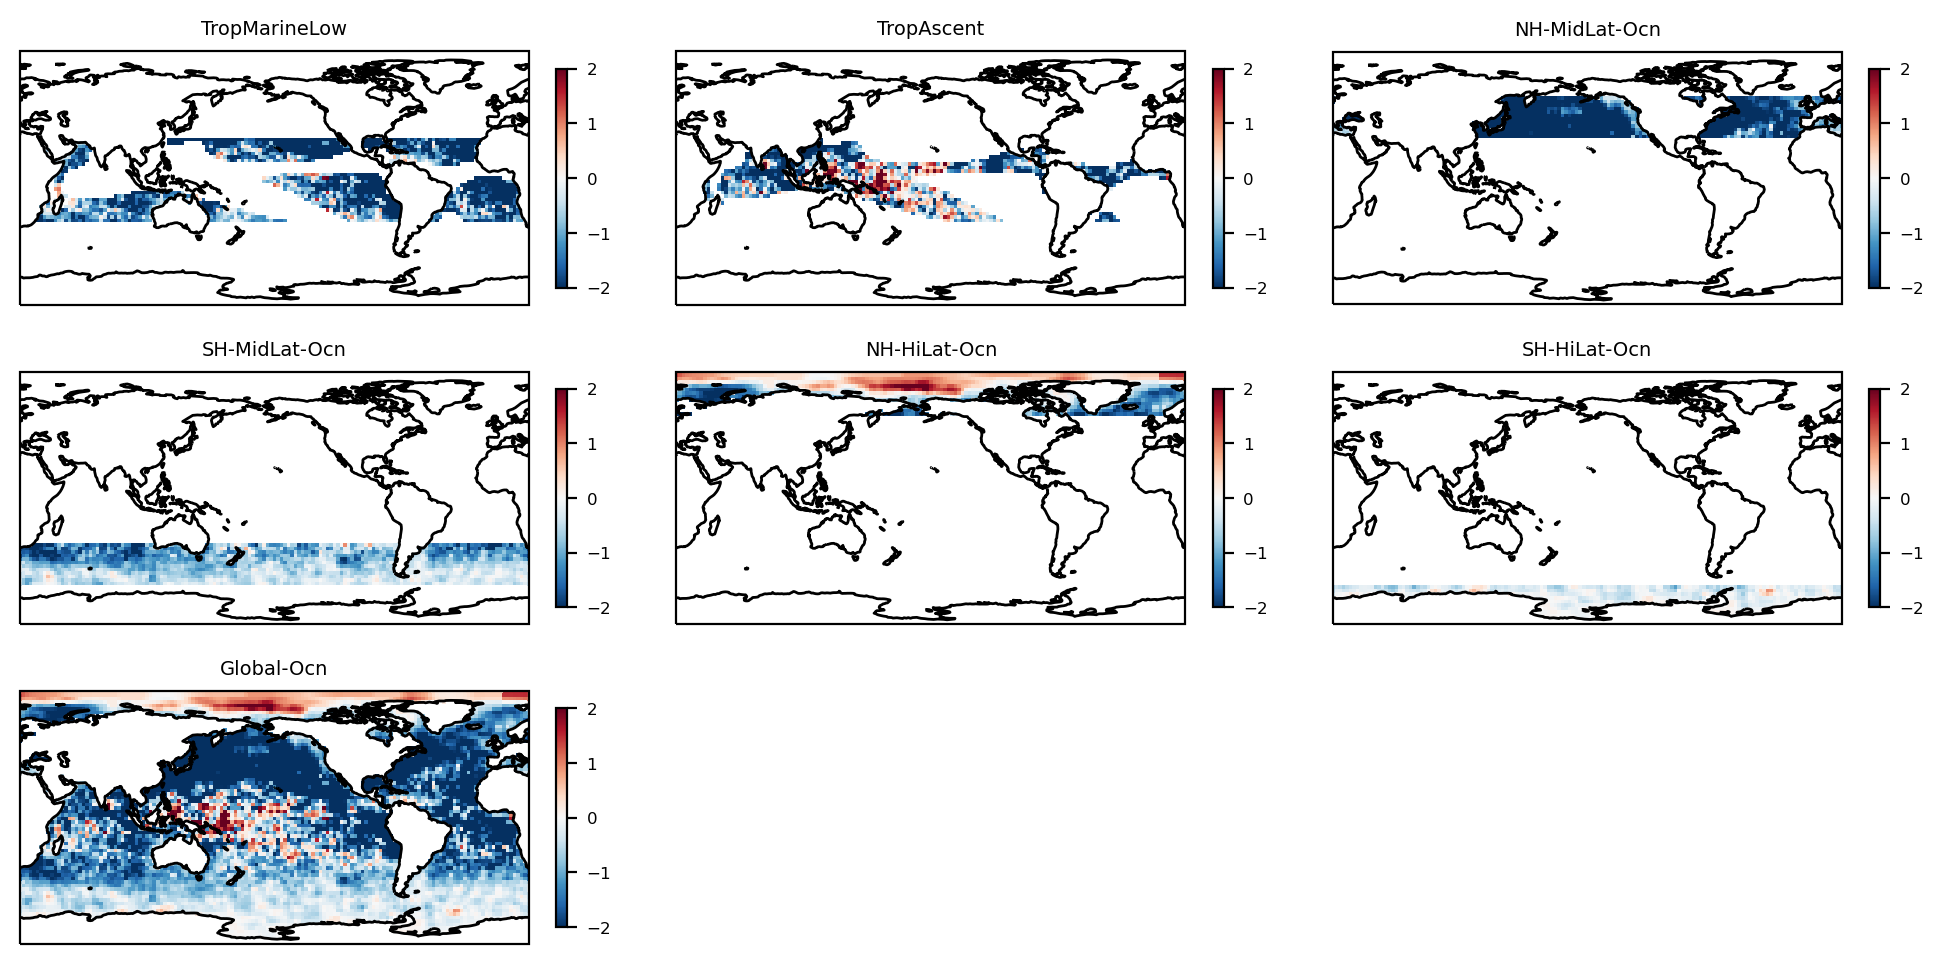

In [16]:

fig = plt.figure(figsize=(12,6),dpi=200)
nrow = 3
ncol = 3 


sum = 0 
for ireg,reg in enumerate(regimes):
    
    f1 = xr.open_dataset(datadir_aer+'Ghan_BASE.nc') 
    
    ax = fig.add_subplot(nrow,ncol,ireg+1,projection=ccrs.PlateCarree(200)) 
    _,_,data2_avg,_,_,data2m_avg,_ = v1v2.regime_partitioning_4(reg,omega700_pi_mm.interp(lat=lat_spc,lon=lon_spc), 
                                                                omega700_ab_mm.interp(lat=lat_spc,lon=lon_spc), 
                                                                omega700_avg_mm.interp(lat=lat_spc,lon=lon_spc), 
                                                                f1.ACI.interp(lat=lat_spc,lon=lon_spc)) 
    
    if ireg == 0:
        frac_map = np.zeros((data2_avg.shape)) 
        frac_map[:] = np.nan 
    
    if reg not in ['Global', 'Global-Ocn']:
        frac_map = xr.where(np.isnan(data2_avg),frac_map,ireg+1)
        
    this = misc.area_averager(data2m_avg).values 

    sum += this 
    print(ireg, reg, this, sum)   
    
    datap = data2_avg 
    im = ax.pcolormesh(datap.lon, datap.lat, datap, transform=ccrs.PlateCarree(),cmap='RdBu_r',
                       vmin=-2,vmax=2,
                       )
    ax.coastlines()
    fig.colorbar(im,fraction=0.02)

    ax.set_title(reg) 

### Plot regime partitioning map (Figure S1)

0 TropMarineLow 0.2103955007431096
1 TropAscent 0.15901460456784042
2 NH-MidLat-Ocn 0.09361505674692926
3 SH-MidLat-Ocn 0.170679392385255
4 NH-HiLat-Ocn 0.03582362245989341
5 SH-HiLat-Ocn 0.03760406187143704
sumfrac= 0.7071322387744647


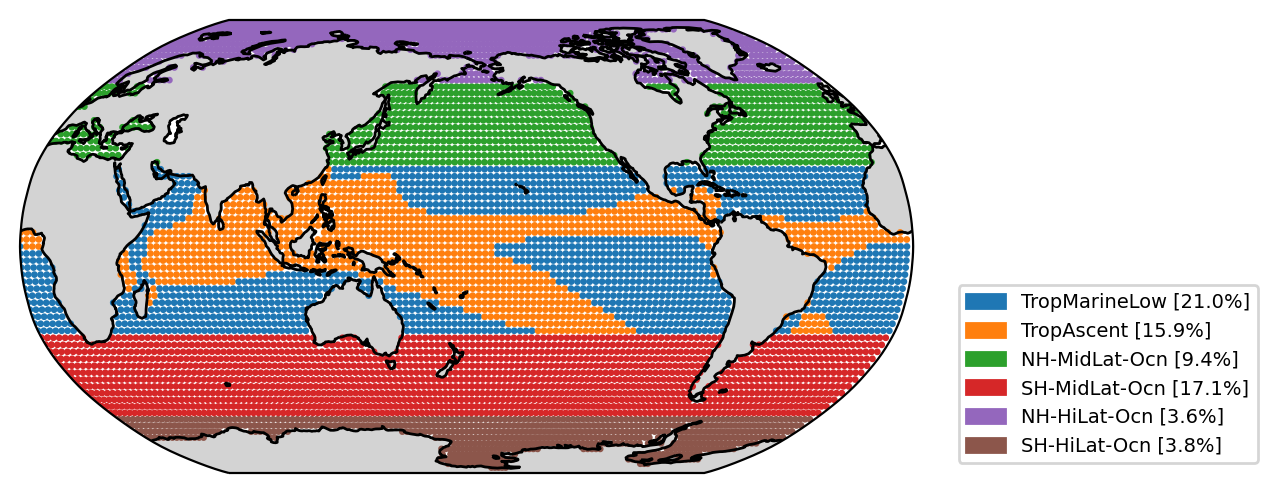

In [17]:
# f2 = xr.open_dataset(figdir+'saved_frac_map_2024-04-01.nc')
# datap = f2.frac_map

datap = frac_map
cyclic_data, cyclic_lons = add_cyclic_point(datap, coord=datap.lon) 
lon2d, lat2d = np.meshgrid(cyclic_lons, datap.lat) 

if regime_method_tag == '_LndOcn': 
    colors = misc.get_color('tab20',len(regimes))  
else:
    colors = misc.get_color('tab10',len(regimes[:-1])) 

cmap = mcolors.ListedColormap(colors)

fig = plt.figure(figsize=(7,3),dpi=200)
ax = fig.add_subplot(111, projection=ccrs.Robinson(180))

im = ax.scatter(lon2d,lat2d, 
                    c=cyclic_data,marker='o',s=2,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap, 
                    )

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgrey')

sumfrac = 0.0 
patches = []
for ireg,reg in enumerate(regimes):
    if reg in ['Global-Lnd','Global-Ocn','Global']:
        continue 
    datap_avg = misc.area_averager(xr.where(datap==ireg+1,1.0,0.0)).values 
    print(ireg, reg, datap_avg)
    # patch = mpatches.Patch(color=colors[ireg], label=reg+' ('+regimes_plot_short[ireg+1]+')'+' ['+str(np.round(datap_avg*100,1))+'%]')
    patch = mpatches.Patch(color=colors[ireg], label=reg+' ['+str(np.round(datap_avg*100,1))+'%]')

    patches.append(patch) 

    sumfrac += datap_avg

plt.legend(handles=patches,bbox_to_anchor=(1.04,0.0), loc='lower left')

print('sumfrac=',sumfrac) 

## Read ERFaci and CF dictionaries 
> pre-processed by calc_ppe_fbk_aci_cloud_regime2_regime-avg.py

In [18]:
print(regime_method_tag) 

bands = [
    # 'SW','LW', # SW vs LW 
    # 'Net_LO','Net_HI', # Low vs Non-low 
    # 'SW_LO','SW_HI',
    # 'LW_LO','LW_HI',
    ]

print(middir+'dics_fbk_4yr_regime-avg'+regime_method_tag+'.pkl')
with open(middir+'dics_fbk_4yr_regime-avg'+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
    dics_fbk_4yr_net = pickle.load(f) 
print('Read-1.0')

with open(middir+'dics_aci_regime-avg'+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
    dics_aci_net = pickle.load(f) 
print('Read-2.0')

dics_fbk_4yr = dics_fbk_4yr_net.copy() 
dics_aci = dics_aci_net.copy()

for band in bands:   
    with open(middir+'dics_fbk_4yr_regime-avg_'+band+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
        dics_fbk_4yr_tmp = pickle.load(f) 
    print('Read-CF-'+band)
    dics_fbk_4yr.update(dics_fbk_4yr_tmp)  

    with open(middir+'dics_aci_regime-avg_'+band+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
        dics_aci_tmp = pickle.load(f) 
    print('Read-ACI-'+band) 
    dics_aci.update(dics_aci_tmp) 
    print() 

print(dics_fbk_4yr.keys()) 
print(dics_fbk_4yr['RK'].keys()) 
print() 
print(dics_aci.keys()) 
print(dics_aci['Ghan'].keys()) 
print() 
print(dd) 

_OceanOnly30SN
/qfs/people/qiny108/ppe_scripts/middata/regime_partition_OceanOnly30SN/dics_fbk_4yr_regime-avg_OceanOnly30SN.pkl
Read-1.0
Read-2.0
dict_keys(['RK', 'CRK', 'CRK_amt', 'CRK_tau', 'CRK_alt', 'APRP'])
dict_keys(['BASE', 'nomincdnc', 'nomincdnc_2', 'nomincdnc_3', 'prc_exp1', 'prc_exp1_2', 'prc_exp1_3', 'prc_exp_2', 'prc_exp_3', 'prc_coef1', 'prc_coef1_2', 'prc_coef1_3', 'accre_enhan', 'accre_enhan_2', 'accre_enhan_3', 'c1', 'c1_2', 'c1_3', 'c1_4', 'gamma_coef', 'gamma_coef_2', 'gamma_coef_3', 'gamma_coef_4', 'c8', 'c8_2', 'c8_3', 'c8_4', 'gamma_coefb', 'gamma_coefb_2', 'gamma_coefb_3', 'wsub', 'wsub_2', 'wsub_3', 'wsub_4', 'ice_deep', 'ice_deep_2', 'ice_deep_3', 'ice_sed_ai', 'ice_sed_ai_2', 'ice_sed_ai_3', 'so4_sz', 'so4_sz_2', 'so4_sz_3', 'dp1', 'dp1_2', 'dp1_3', 'berg', 'berg_2', 'berg_3', 'clubb_tk1', 'clubb_tk1_2', 'clubb_tk1_3', 'nomincdnc.prc_exp1_2', 'nomincdnc.prc_exp1_3', 'nomincdnc.prc_exp_2', 'nomincdnc.prc_exp_3', 'nomincdnc.prc_coef1', 'nomincdnc.prc_coef1_3', '

In [20]:
dics_fbk_4yr['CRK_tau']['BASE']['ALL_NETcld_tau'].keys()

dict_keys(['TropMarineLow_pi', 'TropMarineLow_ab', 'TropMarineLow_avg', 'TropMarineLow_cmb', 'TropMarineLow_frc_pi', 'TropMarineLow_frc_ab', 'TropMarineLow_frc_avg', 'TropAscent_pi', 'TropAscent_ab', 'TropAscent_avg', 'TropAscent_cmb', 'TropAscent_frc_pi', 'TropAscent_frc_ab', 'TropAscent_frc_avg', 'NH-MidLat-Ocn_pi', 'NH-MidLat-Ocn_ab', 'NH-MidLat-Ocn_avg', 'NH-MidLat-Ocn_cmb', 'NH-MidLat-Ocn_frc_pi', 'NH-MidLat-Ocn_frc_ab', 'NH-MidLat-Ocn_frc_avg', 'SH-MidLat-Ocn_pi', 'SH-MidLat-Ocn_ab', 'SH-MidLat-Ocn_avg', 'SH-MidLat-Ocn_cmb', 'SH-MidLat-Ocn_frc_pi', 'SH-MidLat-Ocn_frc_ab', 'SH-MidLat-Ocn_frc_avg', 'SH-HiLat-Ocn_pi', 'SH-HiLat-Ocn_ab', 'SH-HiLat-Ocn_avg', 'SH-HiLat-Ocn_cmb', 'SH-HiLat-Ocn_frc_pi', 'SH-HiLat-Ocn_frc_ab', 'SH-HiLat-Ocn_frc_avg', 'NH-HiLat-Ocn_pi', 'NH-HiLat-Ocn_ab', 'NH-HiLat-Ocn_avg', 'NH-HiLat-Ocn_cmb', 'NH-HiLat-Ocn_frc_pi', 'NH-HiLat-Ocn_frc_ab', 'NH-HiLat-Ocn_frc_avg', 'Global-Ocn_pi', 'Global-Ocn_ab', 'Global-Ocn_avg', 'Global-Ocn_cmb', 'Global-Ocn_frc_pi', 'Gl

## Read regime-partitioned CFBK CTL state data
> pre-processed by calc_ppe_state_var_cloud_regime2_regime-avg.py

In [21]:
print(regime_method_tag) 

dics_fbk_state = {} 

for svar in Vars_state_fbk:
    dics1 = {} 
    for case in cases_t+['BASE']: 
        fname = middir+'dics_fbk_state_'+svar+'_'+case+'_regime-avg'+regime_method_tag+'.pkl' 
        with open(fname, 'rb') as f: # regime-averaged
            dics1[case] = pickle.load(f)     

    dics_fbk_state[svar] = dics1 

print(len(dics_fbk_state.keys()), dics_fbk_state.keys(),) 
print(len(dics_fbk_state[Vars_state_fbk[0]].keys()), dics_fbk_state[Vars_state_fbk[0]].keys()) 

_OceanOnly30SN


44 dict_keys(['CLOUD', 'CLDLIQ', 'CLDICE', 'CLDTOT', 'CLDLOW', 'CDNUMC', 'EIS', 'LTS', 'LHFLX', 'SHFLX', 'TS', 'TREFHT', 'QRL', 'QRS', 'DPDLFLIQ', 'ZMDLIQ', 'RCMTEND_CLUBB', 'MPDLIQ', 'LWP_LS', 'LWP_CONV', 'TGCLDIWP', 'IWP_LS', 'WP2_CLUBB', 'WP3_CLUBB', 'SKW_ZM', 'SKW_ZT', 'FREQZM', 'CMFMCDZM', 'OMEGA', 'T', 'Q', 'WPTHVP_CLUBB', 'WPRTP_CLUBB', 'WPTHLP_CLUBB', 'WPRCP_CLUBB', 'CDNUMC_INLIQCLD', 'LWP_INLIQCLD', 'LIQCLD', 'ZMDQ', 'RVMTEND_CLUBB', 'MPDQ', 'ZMDT', 'TTEND_CLUBB', 'MPDT'])
16 dict_keys(['BASE', 'c1', 'c1_2', 'c1_3', 'c1_4', 'c8', 'c8_2', 'c8_3', 'c8_4', 'gamma_coef', 'gamma_coef_2', 'gamma_coef_3', 'gamma_coef_4', 'gamma_coefb', 'gamma_coefb_2', 'gamma_coefb_3'])


In [22]:
dics_fbk_state[Vars_state_fbk[0]]['BASE'].keys()

dict_keys(['CLOUD_pi_clim', 'CLOUD_ab_clim', 'CLOUD_ano_clim'])

## Read regime-partitioned ACI CTL state data

In [23]:
print(regime_method_tag) 

dics_aci_state = {} 

for svar in Vars_state_aci: 
    dics1 = {} 
    for case in cases_t+['BASE']: 
        with open(middir+'dics_aci_state_'+svar+'_'+case+'_regime-avg'+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
            dics1[case] = pickle.load(f)     

    dics_aci_state[svar] = dics1 

print(len(dics_aci_state.keys()), dics_aci_state.keys(),) 
print(len(dics_aci_state[Vars_state_aci[0]].keys()), dics_aci_state[Vars_state_aci[0]].keys()) 

_OceanOnly30SN


19 dict_keys(['LWP_LS', 'LWP_CONV', 'TGCLDIWP', 'WP2_CLUBB', 'WP3_CLUBB', 'CDNUMC', 'TAUTMODIS', 'TAUTLOGMODIS', 'TAUWMODIS', 'TAUWLOGMODIS', 'TAUIMODIS', 'TAUILOGMODIS', 'CLDLIQ', 'ENTRAT', 'ENTRATP', 'ENTRATN', 'ENTEFF', 'ENTEFFP', 'ENTEFFN'])
16 dict_keys(['BASE', 'c1', 'c1_2', 'c1_3', 'c1_4', 'c8', 'c8_2', 'c8_3', 'c8_4', 'gamma_coef', 'gamma_coef_2', 'gamma_coef_3', 'gamma_coef_4', 'gamma_coefb', 'gamma_coefb_2', 'gamma_coefb_3'])


## Read regime-partitioned Gryspeerdt decomp data
> generated by aerocom_forcing_fraction_minimal_ppe.py

In [24]:
print(regime_method_tag)
with open(middir+'dics_Gryspeerdt_Decomp_regime-avg'+regime_method_tag+'.pkl', 'rb') as f: # regime-averaged
    dics_decomp = pickle.load(f) 
print('Read-1.0')

_OceanOnly30SN
Read-1.0


### Comparison with ERFaci from Ghan method (Figure S5)

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 't

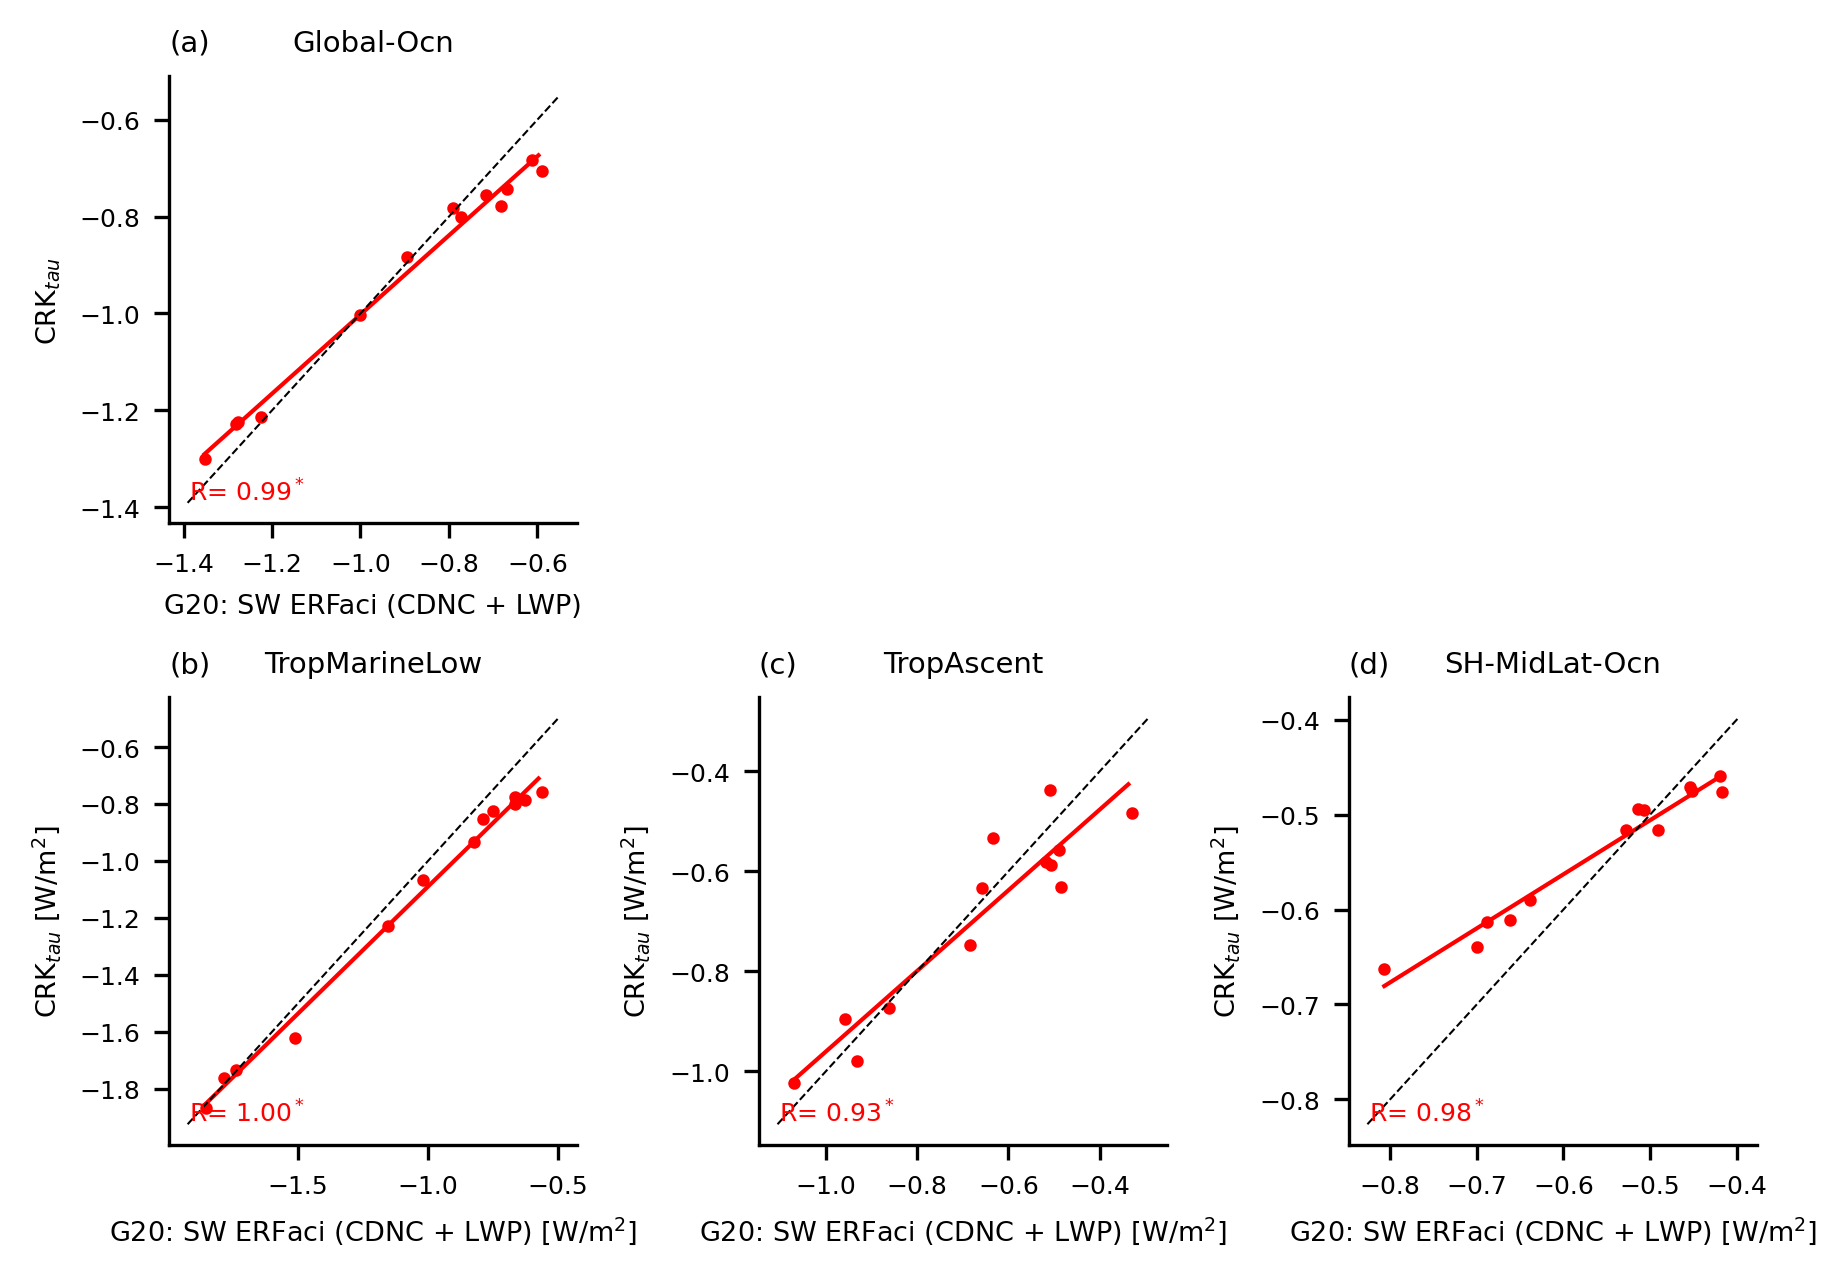

In [25]:
fig = plt.figure(figsize=(6,6),dpi=300)
nrow = 3
ncol = 3

gs = GridSpec(nrow,ncol)

ax1 = fig.add_subplot(gs[0,0]) 
ax2 = fig.add_subplot(gs[1,0]) 
ax3 = fig.add_subplot(gs[1,1])  
ax4 = fig.add_subplot(gs[1,2]) 

for ax, regimeh in zip(
    [ax1,ax2,ax3,ax4],
    [
    'Global-Ocn', 
    'TropMarineLow',
    'TropAscent',
    'SH-MidLat-Ocn', 
]
):
    
    ax.set_title(regimeh,loc='center') 

    data = [
        # ax, source1, source2, varname1, varname2, label of varname, xlabel, ylabel, mcolor, xpos, ypos
        [ax, 'Gryspeerdt_decomp', 'CRK_tau',   ('F_dalbc_nd','F_dalbc_lwp'), 'ALL_NETcld_tau', '', 'G20: SW ERFaci (CDNC + LWP)', 'CRK$_{tau}$','red',0.05,0.10],

    ]

    ii = 0
    for ax,source1, source2, datax, datay, label, xlabel, ylabel, mcolor, xpos, ypos in data: 
        
        XXa = [] 
        YYa = [] 
        casesa = []
        for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
            casesA = dicc[exp] 
            print(exp, casesA) 

            cases_here = [case[0] for case in casesA]
            colors_here = [case[1] for case in casesA]
            values = [case[2] for case in casesA]

            for icase,case in enumerate(cases_here): 
                # if 'c1' in case or 'c8' in case or 'gamma_coefb' in case:
                #     continue
                if 'gamma_coefb' in case:
                    continue 

                caseid = cases_here.index(case)

                if case not in casesa: 
                    casesa.append(case)
                else:
                    continue

                if source1 == 'Gryspeerdt_decomp': 
                    if isinstance(datax, tuple):
                        xx = 0  
                        for datax_tmp in datax: 
                            xx_tmp = misc.area_averager(dics_decomp[source1][case][datax_tmp][regimeh+'_avg'].squeeze()).values
                            xx = xx + xx_tmp
                    else: 
                        xx = misc.area_averager(dics_decomp[source1][case][datax][regimeh+'_avg'].squeeze()).values 
                elif source1 == 'StateVar':
                    var_unit,var_scale,var_label = misc.get_var_unit(datax) 
                    xx = dics_fbk_state[datax][case][datax+'_pi_clim'][regimeh+'_avg'].values * var_scale 


                if 'Ghan' in source2 or 'CRK' in source2:  
                    yy = misc.area_averager(dics_aci[source2][case][datay][regimeh+'_avg']).values 
                else:
                    if isinstance(datay, tuple):
                        yy = 0  
                        for datay_tmp in datay: 
                            yy_tmp = misc.area_averager(dics_decomp[source2][case][datay_tmp][regimeh+'_avg'].squeeze()).values
                            yy = yy + yy_tmp
                    else: 
                        yy = misc.area_averager(dics_decomp[source2][case][datay][regimeh+'_avg'].squeeze()).values 

                XXa.append(xx)
                YYa.append(yy) 
                
        ax.scatter(XXa,YYa,s=4,c=mcolor,label=label) 

        # # ----- Add case name as text ---- 
        # jj = 0 
        # for ixxa,iyya in zip(XXa,YYa):
        #     ax.text(ixxa,iyya,casesa[jj],fontsize=4) 
        #     jj += 1
        # # ----- 


        misc.add_regress_line(XXa,YYa,ax,xpos=xpos, ypos=ypos, add_line=True,color=mcolor,prefix_str=label)  

        # =================================================
        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)

        if ii in [0,1]:
            # Add diagnoal line 
            xmin,xmax = ax.get_xlim() 
            ymin,ymax = ax.get_ylim()

            vmin = min([xmin,ymin])
            vmax = max([xmax,ymax]) 
            ax.plot([vmin,vmax], [vmin,vmax],ls='--',c='black',lw=0.5)

        if ax == ax1:
            unit_str = ''
        else: 
            unit_str = ' [W/m$^2$]'
            
        ax.set_xlabel(xlabel+unit_str)
        ax.set_ylabel(ylabel+unit_str) 

        ii += 1 

    ax1.set_title('(a)',loc='left')
    ax2.set_title('(b)',loc='left')
    ax3.set_title('(c)',loc='left')
    ax4.set_title('(d)',loc='left')

    fig.tight_layout() 

    # filename = 'Scatterplot_Gryspeerdt_total_vs_Ghan_'+dd+'.pdf'
    # fig.savefig(figdir+filename, bbox_inches='tight') 


### Decomposition for each regime (Figure S6)

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 't

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 't

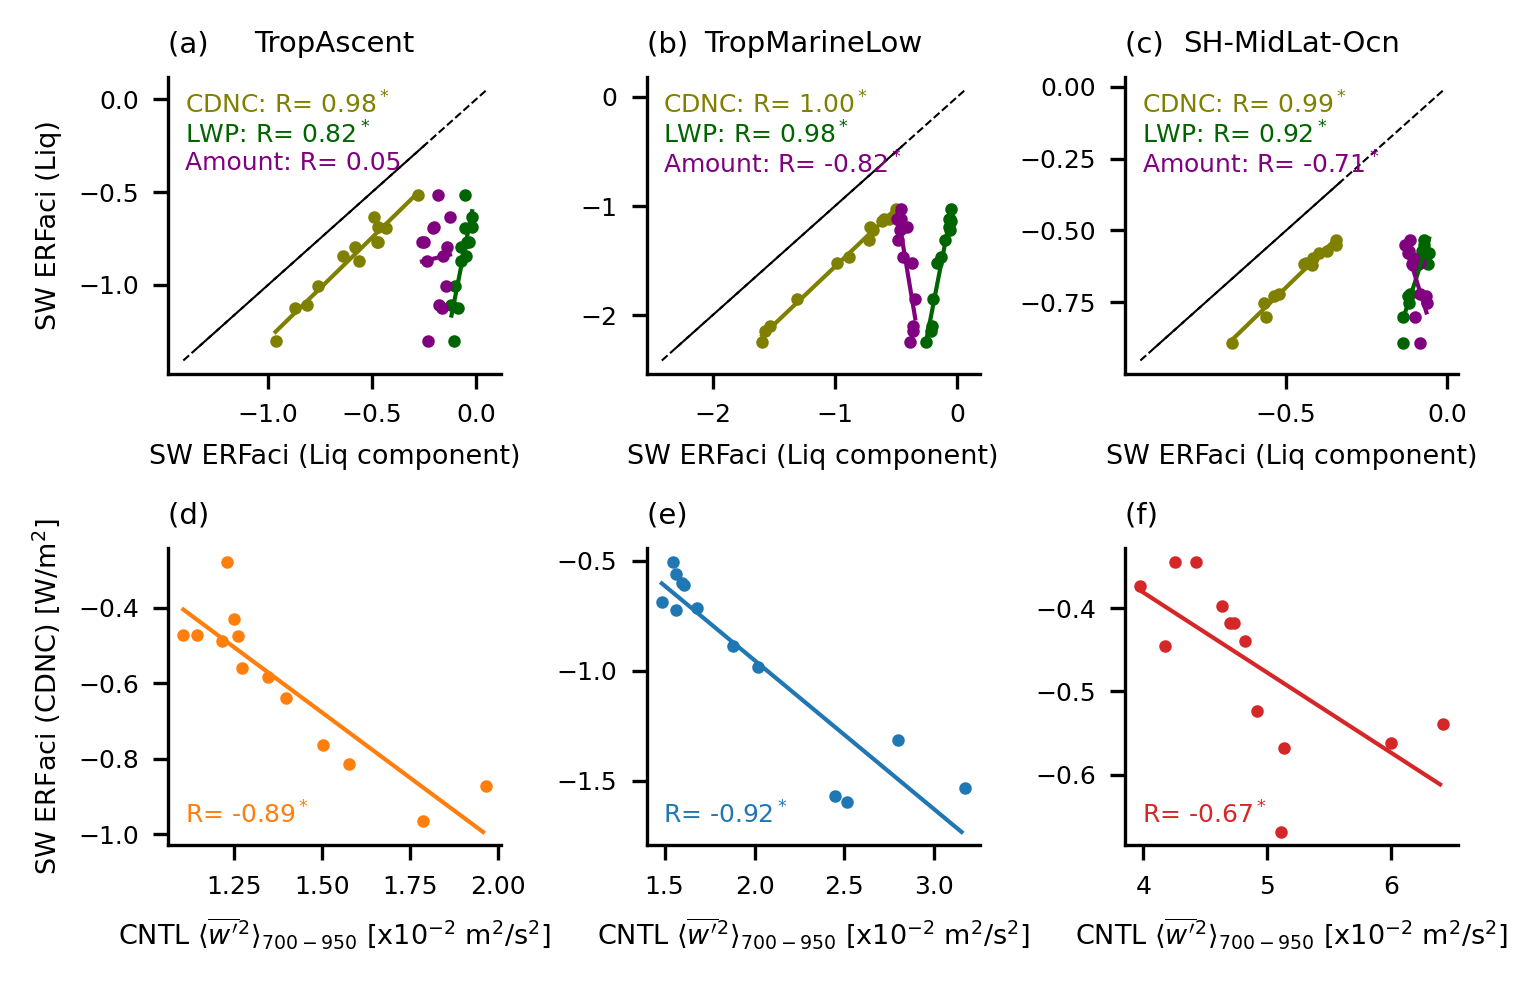

In [26]:

fig = plt.figure(figsize=(5,4.5),dpi=300)
nrow = 3
ncol = 3

gs = GridSpec(nrow,ncol)

for ireg,regime_here in enumerate(regimes_here):  
    regimeh, _, _, _,regime_color = regime_here
    
    ax1 = fig.add_subplot(gs[0,ireg]) 
    ax2 = fig.add_subplot(gs[1,ireg])
    ax3 = fig.add_subplot(gs[2,ireg])

    data = [
        # ax, source1, source2, varname1, varname2, label of varname, xlabel, ylabel, mcolor, xpos, ypos

        [ax1, 'Gryspeerdt_decomp', 'Gryspeerdt_decomp', ('F_dalbc_nd'),  ('F_dalbc_nd','F_dalbc_lwp','F_dcfl'), 'CDNC',   'SW ERFaci (Liq component)', 'SW ERFaci (Liq)', 'olive',     0.05, 0.95], 
        [ax1, 'Gryspeerdt_decomp', 'Gryspeerdt_decomp', ('F_dalbc_lwp'), ('F_dalbc_nd','F_dalbc_lwp','F_dcfl'), 'LWP',    'SW ERFaci (Liq component)', 'SW ERFaci (Liq)', 'darkgreen', 0.05, 0.85], 
        [ax1, 'Gryspeerdt_decomp', 'Gryspeerdt_decomp', ('F_dcfl'),      ('F_dalbc_nd','F_dalbc_lwp','F_dcfl'), 'Amount', 'SW ERFaci (Liq component)', 'SW ERFaci (Liq)', 'purple',    0.05, 0.75 ], 
    
        [ax2, 'StateVar', 'Gryspeerdt_decomp', 'WP2_CLUBB', ('F_dalbc_nd'), '', 'w2', 'SW ERFaci (CDNC)', regime_color, 0.05, 0.15 ],

        # [ax3, 'StateVar', 'Gryspeerdt_decomp', 'WP2_CLUBB', ('F_dalbc_lwp'), '', 'w2', 'SW ERFaci (LWP)', regime_color, 0.05, 0.15 ], 

    ]

    axes = [] 
    ii = 0
    for ax,source1, source2, datax, datay, label, xlabel, ylabel, mcolor, xpos, ypos in data: 
        axes.append(ax) 
        
        XXa = [] 
        YYa = [] 
        casesa = []
        for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
            casesA = dicc[exp] 
            print(exp, casesA) 

            cases_here = [case[0] for case in casesA]
            colors_here = [case[1] for case in casesA]
            values = [case[2] for case in casesA]

            for icase,case in enumerate(cases_here): 
                # if 'c1' in case or 'c8' in case or 'gamma_coefb' in case:
                #     continue
                if 'gamma_coefb' in case:
                    continue 

                caseid = cases_here.index(case)

                if case not in casesa: 
                    casesa.append(case)
                else:
                    continue

                if source1 == 'Gryspeerdt_decomp': 
                    if isinstance(datax, tuple):
                        xx = 0  
                        for datax_tmp in datax: 
                            xx_tmp = misc.area_averager(dics_decomp[source1][case][datax_tmp][regimeh+'_avg'].squeeze()).values
                            xx = xx + xx_tmp
                    else: 
                        xx = misc.area_averager(dics_decomp[source1][case][datax][regimeh+'_avg'].squeeze()).values 
                elif source1 == 'StateVar':
                    var_unit,var_scale,var_label = misc.get_var_unit(datax) 
                    if datax in var3d: 
                        peak_lev = 95000
                        lev_offset = 25000 
                        print('peak_lev1=',peak_lev,'peak_lev2=',peak_lev-lev_offset) 
                        xx = dics_fbk_state[datax][case][datax+'_pi_clim'][regimeh+'_avg'].sel(plev=slice(peak_lev,peak_lev-lev_offset)).mean(dim='plev') * var_scale 
                    else: 
                        xx = dics_fbk_state[datax][case][datax+'_pi_clim'][regimeh+'_avg'].values * var_scale 

                    # overwrite var_label if datax == 'WP2_CLUBB' 09/26/24
                    var_label = r'$\langle\overline{{w}^{\prime}}^{2}\rangle_{700-950}$'  

                if 'Ghan' in source2: 
                    yy = misc.area_averager(dics_aci[source2][case][datay][regimeh+'_avg']).values 
                else:
                    if isinstance(datay, tuple):
                        yy = 0  
                        for datay_tmp in datay: 
                            yy_tmp = misc.area_averager(dics_decomp[source2][case][datay_tmp][regimeh+'_avg'].squeeze()).values
                            yy = yy + yy_tmp
                    else: 
                        yy = misc.area_averager(dics_decomp[source2][case][datay][regimeh+'_avg'].squeeze()).values 

                XXa.append(xx)
                YYa.append(yy) 
                
        ax.scatter(XXa,YYa,s=4,c=mcolor,label=label) 

        # # ----- Add case name as text ---- 
        # jj = 0 
        # for ixxa,iyya in zip(XXa,YYa):
        #     ax.text(ixxa,iyya,casesa[jj],fontsize=4) 
        #     jj += 1
        # # ----- 


        misc.add_regress_line(XXa,YYa,ax,xpos=xpos, ypos=ypos, add_line=True,color=mcolor,prefix_str=label)  

        if ax == ax1: 
            ax.set_title(regimeh) 
        
        # =================================================
        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)

        if ii in [0,1]:
            # Add diagnoal line 
            xmin,xmax = ax.get_xlim() 
            ymin,ymax = ax.get_ylim()

            vmin = min([xmin,ymin])
            vmax = max([xmax,ymax]) 
            ax.plot([vmin,vmax], [vmin,vmax],ls='--',c='black',lw=0.5)


        if ax == ax1:
            unit_str = ''
        else: 
            unit_str = ' [W/m$^2$]'
            
        ax.set_xlabel(xlabel+unit_str)
        if regimeh == 'TropAscent':  
            ax.set_ylabel(ylabel+unit_str) 

        # Update x label for plotting state variables vs ERFaci component 
        if ax in [ax2, ax3]:  
            ax.set_xlabel('CNTL '+var_label+' ['+var_unit+']') 
        

        ii += 1 

    ax1.set_title('('+chr(ord('`')+(ireg+1))+') ',loc='left')
    ax2.set_title('('+chr(ord('`')+(ncol+ireg+1))+') ',loc='left')  

    # ====== Remove those axes not used ==================================== 
    for ax in [ax1,ax2,ax3]: 
        if ax not in axes:
            ax.axis('off') 
            ax.remove() 

fig.tight_layout() 

filename = 'Scatterplot_Gryspeerdt_decomposition_'+regimeh+'_'+dd+'.pdf'
# fig.savefig(figdir+filename, bbox_inches='tight') 


## Pairplot: ACI vs ACI [OR] CFBK vs CFBK (Figure 1b, 1c)

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
16 16
XXa= [array(0.3687517), array(0.43676481), array(0.44325796), array(0.32237302), array(0.44832369), array(0.43726503), array(0.29926776), array(0.35706467), array(0.38648976), array(0.46221858), array(0.38691877), array(0.41606945), array(0.4036007), array(0.47426862), array(0.45216264), array(0.37980217)]
YYa= [array(0.3687517), array(0.43676481), array(0.44325796), array(0.32237302), array(0.44832369), array(0

Global-Ocn_fbk  TropMarineLow_fbk  TropAscent_fbk  \
Global-Ocn_aci           1.000000                NaN             NaN   
TropMarineLow_aci        0.814028           1.000000             NaN   
TropAscent_aci          -0.412845          -0.739964        1.000000   
NH-MidLat-Ocn_aci        0.681811           0.438856       -0.442315   
SH-MidLat-Ocn_aci        0.770123           0.887005       -0.847292   
NH-HiLat-Ocn_aci         0.364568           0.355988       -0.201208   
SH-HiLat-Ocn_aci         0.311138          -0.102131        0.478731   

                   NH-MidLat-Ocn_fbk  SH-MidLat-Ocn_fbk  NH-HiLat-Ocn_fbk  \
Global-Ocn_aci                   NaN                NaN               NaN   
TropMarineLow_aci                NaN                NaN               NaN   
TropAscent_aci                   NaN                NaN               NaN   
NH-MidLat-Ocn_aci           1.000000                NaN               NaN   
SH-MidLat-Ocn_aci           0.519353           1.000000               NaN   
NH-HiLat-Ocn_aci            0.111326           0.248911          1.000000   
SH-HiLat-Ocn_aci            0.117987          -0.179695          0.095658   

                   SH-HiLat-Ocn_fbk  
Global-Ocn_aci                  NaN  
TropMarineLow_aci               NaN  
TropAscent_aci                  NaN  
NH-MidLat-Ocn_aci               NaN  
SH-MidLat-Ocn_aci               NaN  
NH-HiLat-Ocn_aci                NaN  
SH-HiLat-Ocn_aci                1.0

band = 


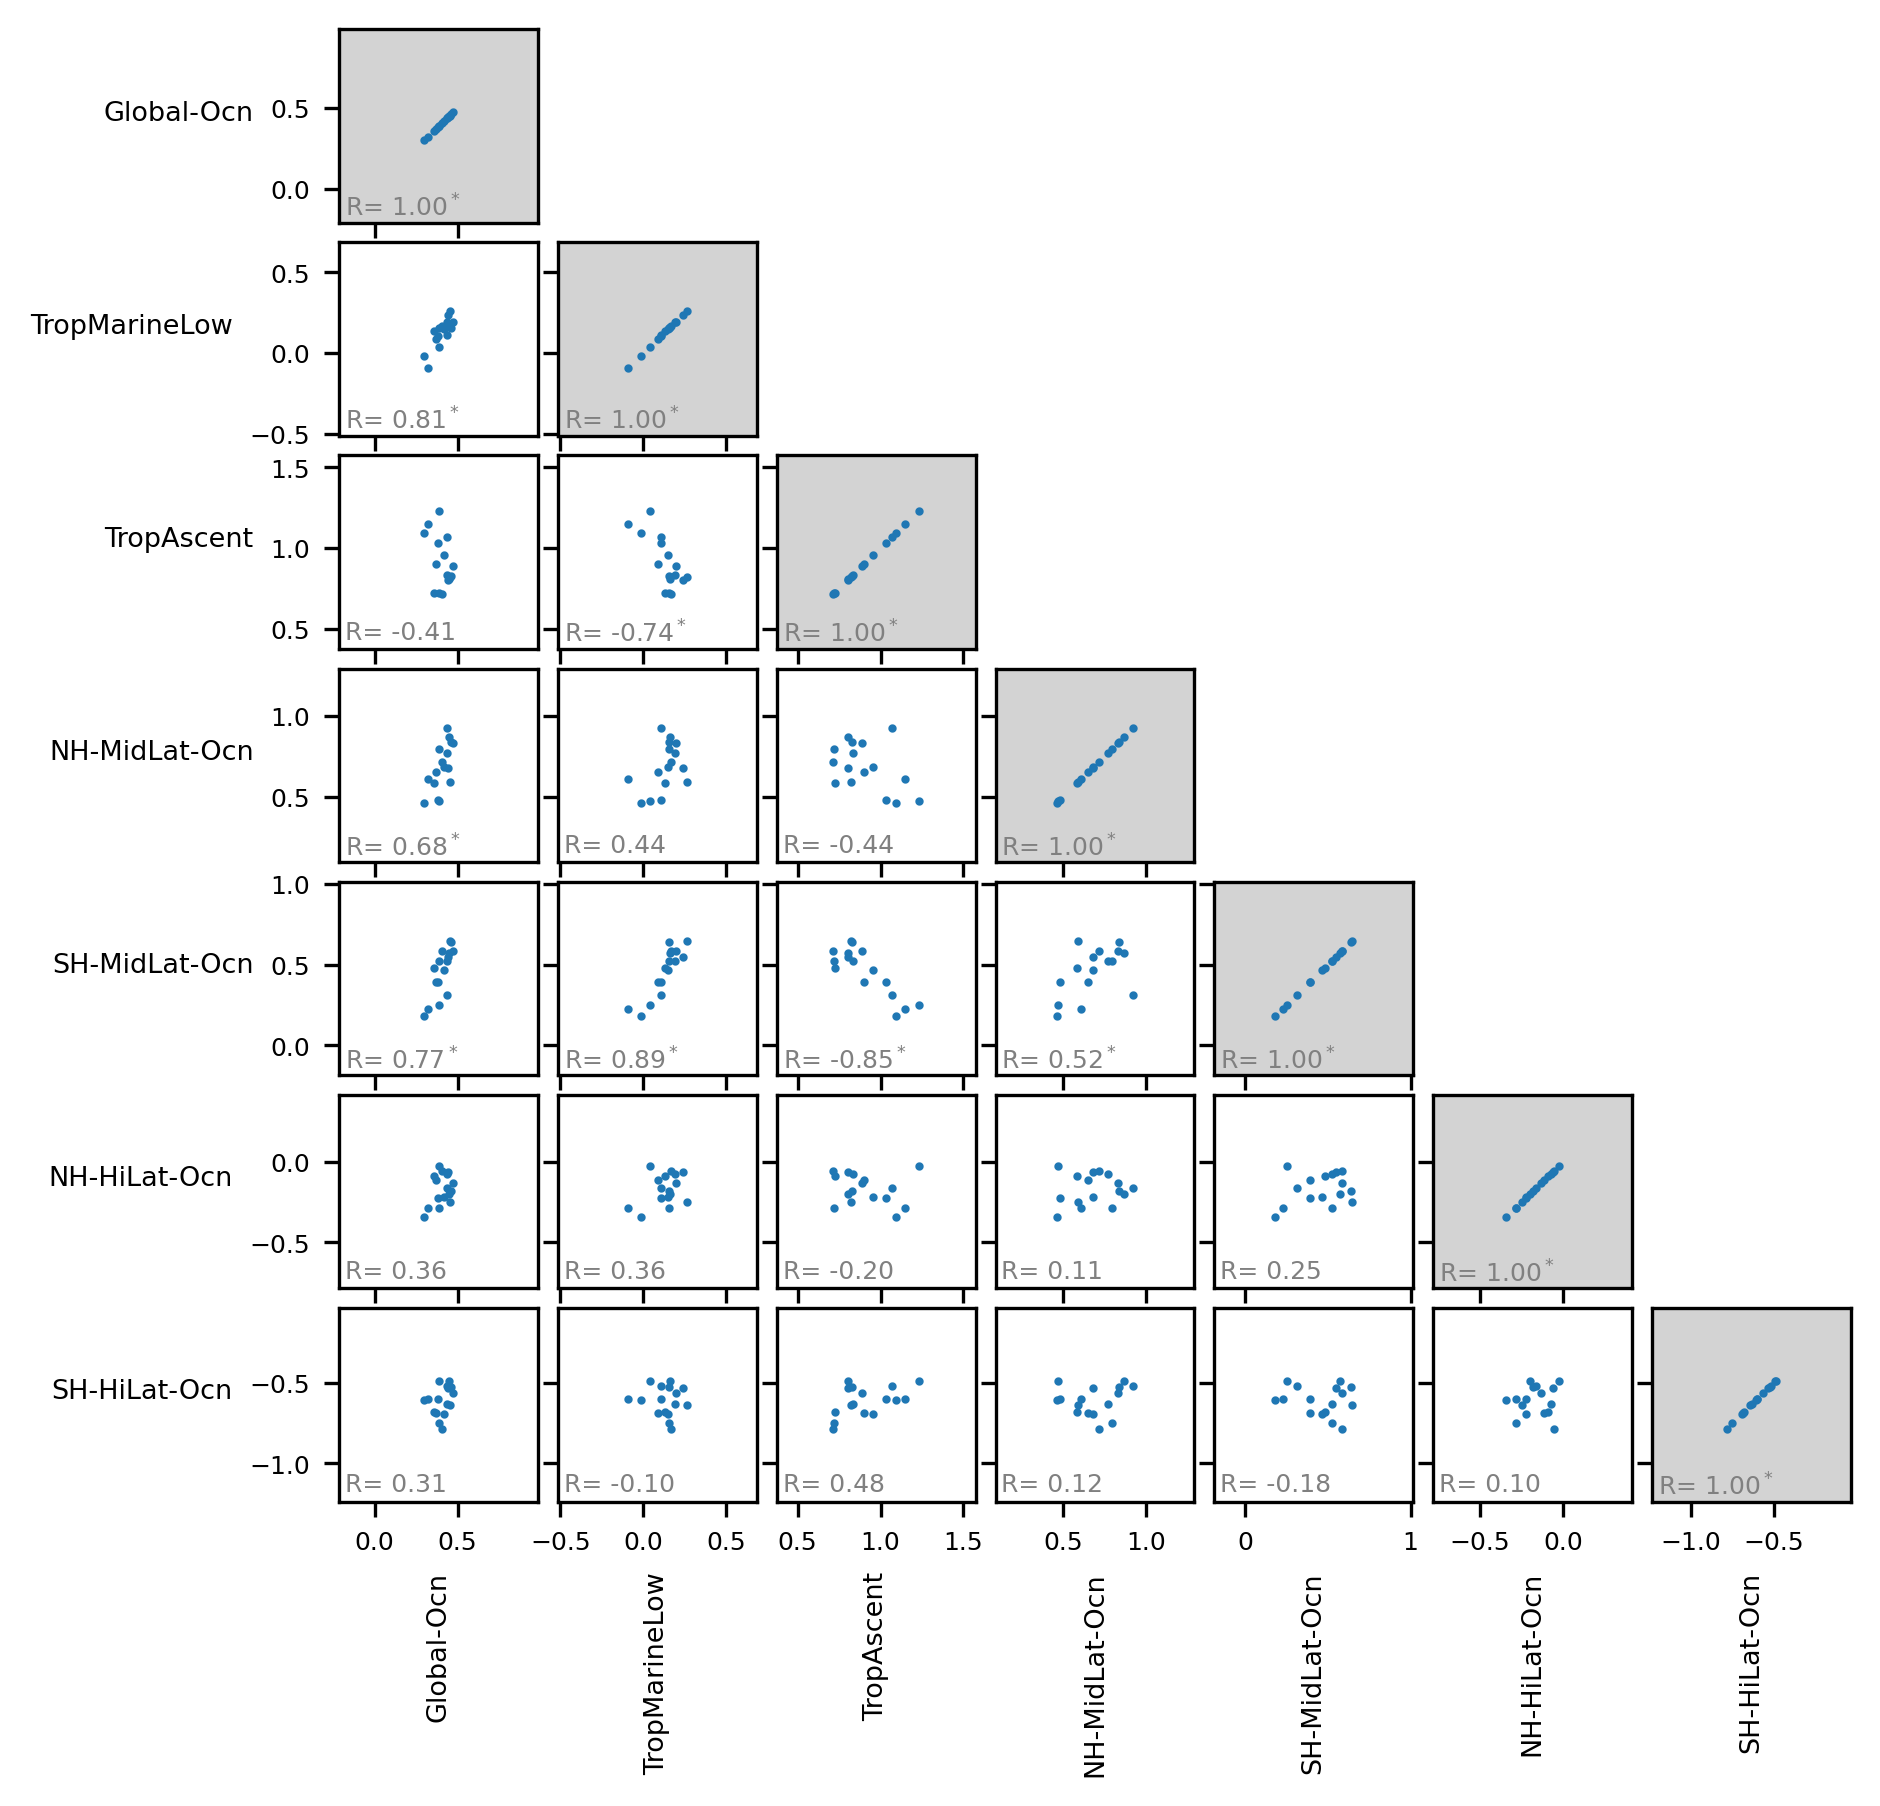

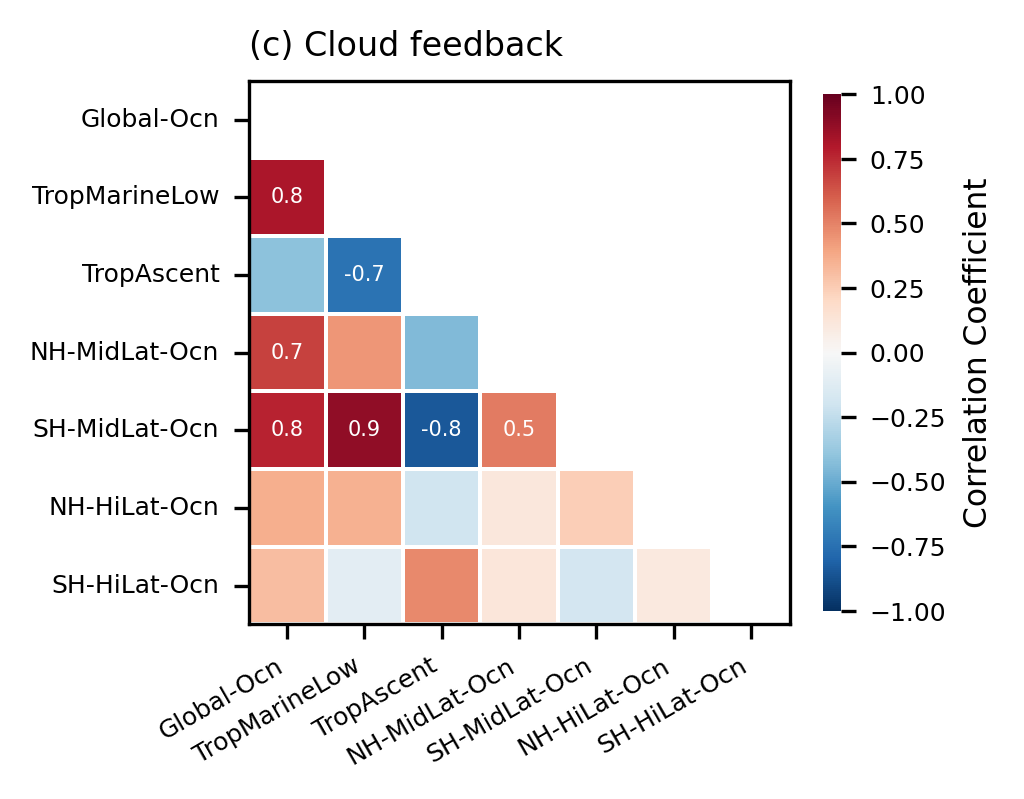

In [27]:
# tag0 = 'ACI_vs_ACI'
tag0 = 'CFBK_vs_CFBK'

fbk_datasource, aer_datasource = 'RK', 'Ghan'
# fbk_datasource, aer_datasource = 'RK_SW', 'Ghan_SW'
# fbk_datasource, aer_datasource = 'RK_LW', 'Ghan_LW'

_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)
_, Vars_aer = misc.get_aer_method_info(aer_datasource) 

included_categories = [
    # None, 
    # prc, 
    turbc, 
    # mixc, deepc
    ] 
included_categories_labels = [
    # 'All',
    # 'warm-rain',
    'turbulence',
    # 'mixed-phase','deep convection'
    ]

for included_category, included_category_label in zip(included_categories, included_categories_labels): 
    tag = tag0+'_'+included_category_label

    fig = plt.figure(figsize=(6.5,6.5),dpi=300)  
    nrow = len(regimes_plot)
    ncol = nrow  

    df_corr = pd.DataFrame()  # correlation matrix 
    df_pvalues = pd.DataFrame() 

    ii = 0 
    # Loop over each regime
    for jj,name_aci in enumerate(regimes_plot):   
        # Loop over each regime
        for kk,name_fbk in enumerate(regimes_plot): 

            ax = fig.add_subplot(nrow,ncol,ii+1)  
            
            if jj<kk: 
                print('hello')
                ax.axis('off')
            else: 

                XXa = []
                YYa = [] 
                casesa = [] 
                for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
                    casesA = dicc[exp] 
                    print(exp, casesA) 

                    cases_here = [case[0] for case in casesA]
                    colors_here = [case[1] for case in casesA]
                    values = [case[2] for case in casesA]

                    if included_category != None: 
                        if colors_here[1] != included_category:   
                            continue 

                    # # =====================================================
                    # # Get uncertainty 
                    # # =====================================================
                    # if tag == 'CFBK_vs_CFBK':
                    #     xx_sample_mean, xx_sample_stderr_90 = misc.get_uncertainty_regime('fbk',dics_fbk_4yr[fbk_datasource],'netCRE_ano_grd_adj',name_fbk+'_avg')
                    #     yy_sample_mean, yy_sample_stderr_90 = misc.get_uncertainty_regime('fbk',dics_fbk_4yr[fbk_datasource],'netCRE_ano_grd_adj',name_aci+'_avg')
                    # if tag == 'ACI_vs_ACI':
                    #     xx_sample_mean, xx_sample_stderr_90 = misc.get_uncertainty_regime('aci',dics_aci[aer_datasource],'ACI',name_fbk+'_avg')
                    #     yy_sample_mean, yy_sample_stderr_90 = misc.get_uncertainty_regime('aci',dics_aci[aer_datasource],'ACI',name_aci+'_avg')

                    for icase,case in enumerate(cases_here): 
                        
                        # # Test the impact of the two samples... 
                        # if case in ['c1','c8_3']: 
                        #     continue 

                        caseid = cases_here.index(case)

                        if case not in casesa:
                            casesa.append(case)
                        else:
                            continue 

                        if tag0 == 'ACI_vs_ACI':
                            xx = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_fbk+'_avg']).values
                            yy = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_aci+'_avg']).values 
                        elif tag0 == 'CFBK_vs_CFBK':
                            xx = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_fbk+'_avg']).values 
                            yy = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_aci+'_avg']).values 

                        ax.plot(xx,yy, marker='.',ms=2, c='tab:blue')  

                        if case == 'BASE': 
                            xx_base = xx
                            yy_base = yy 

                        XXa.append(xx)
                        YYa.append(yy) 

                # title_obj = ax.set_title(exp)  
                # plt.setp(title_obj, color=colorsh[1]) 

                print(len(XXa),len(YYa))
                print('XXa=', XXa) 
                print('YYa=', YYa) 
                
                # ======================== reset axis limits ===============================
                if tag0 == 'ACI_vs_ACI': 
                    y_range = 1.65
                    x_range = 1.65 
                elif tag0 == 'CFBK_vs_CFBK':
                    x_range = 1.2 
                    y_range = 1.2

                new_x, new_y = misc.update_x_limits(ax.get_xlim(), x_range)   
                ax.set_xlim((new_x, new_y)) 

                new_x, new_y = misc.update_x_limits(ax.get_ylim(), y_range) 
                ax.set_ylim((new_x, new_y)) 

                if name_aci == name_fbk:
                    ax.set_facecolor('lightgrey') 

                # # =====================================================
                # # Add uncertainty range 
                # # =====================================================
                # xmin, xmax = ax.get_xlim()
                # ymin, ymax = ax.get_ylim()
                # ax.fill_between([xmin,xmax], yy_base-yy_sample_stderr_90, yy_base+yy_sample_stderr_90,  
                #                 color='grey', alpha=0.2)
                # ax.fill_betweenx([ymin,ymax], xx_base-xx_sample_stderr_90, xx_base+xx_sample_stderr_90,  
                #                 color='grey', alpha=0.2)

                # ======================== Regression ======================== 
                r_value, p_value, _ = misc.add_regress_line(XXa,YYa,ax,xpos=0.03,ypos=0.15,add_line=False,color='grey')  

                df_corr.loc[name_aci+'_aci', name_fbk+'_fbk'] = r_value 
                df_pvalues.loc[name_aci+'_aci', name_fbk+'_fbk'] = p_value 
                    
            # if tag0 == 'ACI_vs_ACI': 
            #     fig.supxlabel('ERFaci [W/m$^2$]',y=0.03) 
            #     fig.supylabel('ERFaci [W/m$^2$]',x=0.03)  
            # elif tag0 == 'CFBK_vs_CFBK':
            #     fig.supxlabel('Cloud feedback [W/m$^2$/K]',y=0.03) 
            #     fig.supylabel('Cloud feedback [W/m$^2$/K]',x=0.03) 
        
            if ii%ncol != 0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(textwrap.fill(name_aci,15),rotation=0,ha='right')  

            if ii//ncol != nrow-1: 
                ax.set_xticklabels([]) 
            else:
                ax.set_xlabel(textwrap.fill(name_fbk,15),rotation=90)  

            ii += 1 

    # fig.tight_layout() 
    fig.subplots_adjust(wspace=0.1, hspace=0.1) 

    filename = tag+'_CldRegime_pairplot_'+dd+'.png'
    # fig.savefig(figdir+filename,dpi=300, bbox_inches='tight') 

    # =====================================================================
    # Save correlation matrix 
    # =====================================================================
    df_corr.to_csv(figdir+'Corr_matrix_'+tag+'.csv') 
    df_pvalues.to_csv(figdir+'Pvalue_matrix_'+tag+'.csv') 

    display(df_corr)

    # =====================================================================
    # Plot heatmap  
    # =====================================================================
    mpl.rcParams['axes.labelsize'] = 7.5
    if regime_method_tag == '_OceanOnly': 
        mpl.rcParams['font.size'] = 6
        mpl.rcParams['xtick.labelsize'] = 7 
        mpl.rcParams['ytick.labelsize'] = 7
    else: 
        mpl.rcParams['font.size'] = 5
        mpl.rcParams['xtick.labelsize'] = 6
        mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 8 


    # fig = plt.figure(figsize=(3.2,3.2), dpi=300) 
    # fig = plt.figure(figsize=(6.4,3.2), dpi=300)
    fig = plt.figure(figsize=(6.4,2.4), dpi=300)
    ax = fig.add_subplot(1,2,1)

    annotations = df_corr.round(1).astype(str) 
    annotations[df_pvalues > 0.05] = ""

    # newlabels = ['GLO','TML','TA','TLD','NML','NMO','SML','HIL']
    newlabels = regimes_plot 

    matrix = np.triu(df_corr) 
    g = sns.heatmap(df_corr,cmap='RdBu_r',
                mask = matrix, 
                vmin=-1,vmax=1,
                annot=annotations, fmt="s", 
                linewidth=.5,
                xticklabels = newlabels, yticklabels = newlabels,  
                # cbar_kws={"orientation": "horizontal", "label": "Correlation Coefficient","aspect":30, "pad":0.05, "shrink": 0.8},     
                # cbar_kws={"orientation": "horizontal", "label": "Correlation Coefficient","aspect":30, "pad":0.15,"shrink": 0.9},
                cbar_kws={"orientation": "vertical", "label": "Correlation Coefficient","aspect":30, "pad":0.05,"shrink": 0.95},
                ax=ax)

    try: 
        band = fbk_datasource.split('_')[1]
        band2 = band+' '
    except:
        band = '' 
        band2 = band 
    
    print(f'band = {band}') 
    
    if tag0 == 'ACI_vs_ACI':
        # ax.text(0.98,0.05,'(b) '+band2+'ERFaci',transform=ax.transAxes,ha='right')   
        ax.set_title('(b) ERFaci', loc='left') 
    if tag0 == 'CFBK_vs_CFBK':
        # ax.text(0.98,0.05,'(c) '+band2+'Cloud feedback',transform=ax.transAxes,ha='right')   
        ax.set_title('(c) Cloud feedback', loc='left') 

    # #Move X Axis to top
    # g.invert_xaxis()
    # g.xaxis.set_ticks_position("top")

    if regime_method_tag in ['_OceanOnly','_OceanOnly30SN']:  
        plt.xticks(rotation=30,ha='right') 
    elif regime_method_tag == '_LndOcn': 
        plt.xticks(rotation=90,ha='center')     
    plt.yticks(rotation=0)

    for _, spine in g.spines.items():
        spine.set_visible(True)

    filename = 'Heatmap_'+tag+'_CldRegime_each_regime_'+dd+'.png'
    fig.savefig(figdir+filename,dpi=300, bbox_inches='tight') 


## Pairplot: ACI vs CFBK (Figure 1a)

fbk_datasource = RK, band2 = 
c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
len(XXa)=16,16
XXa= [array(0.3687517), array(0.43676481), array(0.44325796), array(0.32237302), array(0.44832369), array(0.43726503), array(0.29926776), array(0.35706467), array(0.38648976), array(0.46221858), array(0.38691877), array(0.41606945), array(0.4036007), array(0.47426862), array(0.45216264), array(0.37980217)]
YYa= [array(-1.41308513), array(-1.5730436), array(-1.2237474), arra

len(XXa)=16,16
XXa= [array(0.3687517), array(0.43676481), array(0.44325796), array(0.32237302), array(0.44832369), array(0.43726503), array(0.29926776), array(0.35706467), array(0.38648976), array(0.46221858), array(0.38691877), array(0.41606945), array(0.4036007), array(0.47426862), array(0.45216264), array(0.37980217)]
YYa= [array(-1.89090698), array(-2.13200079), array(-1.58877379), array(-2.42149805), array(-1.45654417), array(-1.41160273), array(-2.42270411), array(-1.3663464), array(-2.54788601), array(-1.49526558), array(-1.37295591), array(-1.67393321), array(-1.37994656), array(-1.51822701), array(-1.49215518), array(-2.08198281)]
r_value= 0.5934581689178104, p_value = 0.015374816185701166
c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 

Global-Ocn_fbk  TropMarineLow_fbk  TropAscent_fbk  \
Global-Ocn_aci           0.589519           0.828987       -0.942630   
TropMarineLow_aci        0.593458           0.825469       -0.958209   
TropAscent_aci           0.607915           0.795575       -0.851599   
NH-MidLat-Ocn_aci        0.524507           0.806569       -0.927367   
SH-MidLat-Ocn_aci        0.536883           0.772963       -0.891478   
NH-HiLat-Ocn_aci         0.419241           0.623599       -0.397973   
SH-HiLat-Ocn_aci        -0.157802          -0.355674        0.178287   

                   NH-MidLat-Ocn_fbk  SH-MidLat-Ocn_fbk  NH-HiLat-Ocn_fbk  \
Global-Ocn_aci              0.493030           0.922359          0.249369   
TropMarineLow_aci           0.545167           0.924075          0.236662   
TropAscent_aci              0.473175           0.878056          0.244904   
NH-MidLat-Ocn_aci           0.404582           0.872543          0.287665   
SH-MidLat-Ocn_aci           0.382150           0.909505          0.159965   
NH-HiLat-Ocn_aci           -0.107500           0.564838          0.301747   
SH-HiLat-Ocn_aci            0.131917          -0.219320         -0.015451   

                   SH-HiLat-Ocn_fbk  
Global-Ocn_aci            -0.355849  
TropMarineLow_aci         -0.385326  
TropAscent_aci            -0.250945  
NH-MidLat-Ocn_aci         -0.345294  
SH-MidLat-Ocn_aci         -0.358708  
NH-HiLat-Ocn_aci          -0.119553  
SH-HiLat-Ocn_aci           0.091569

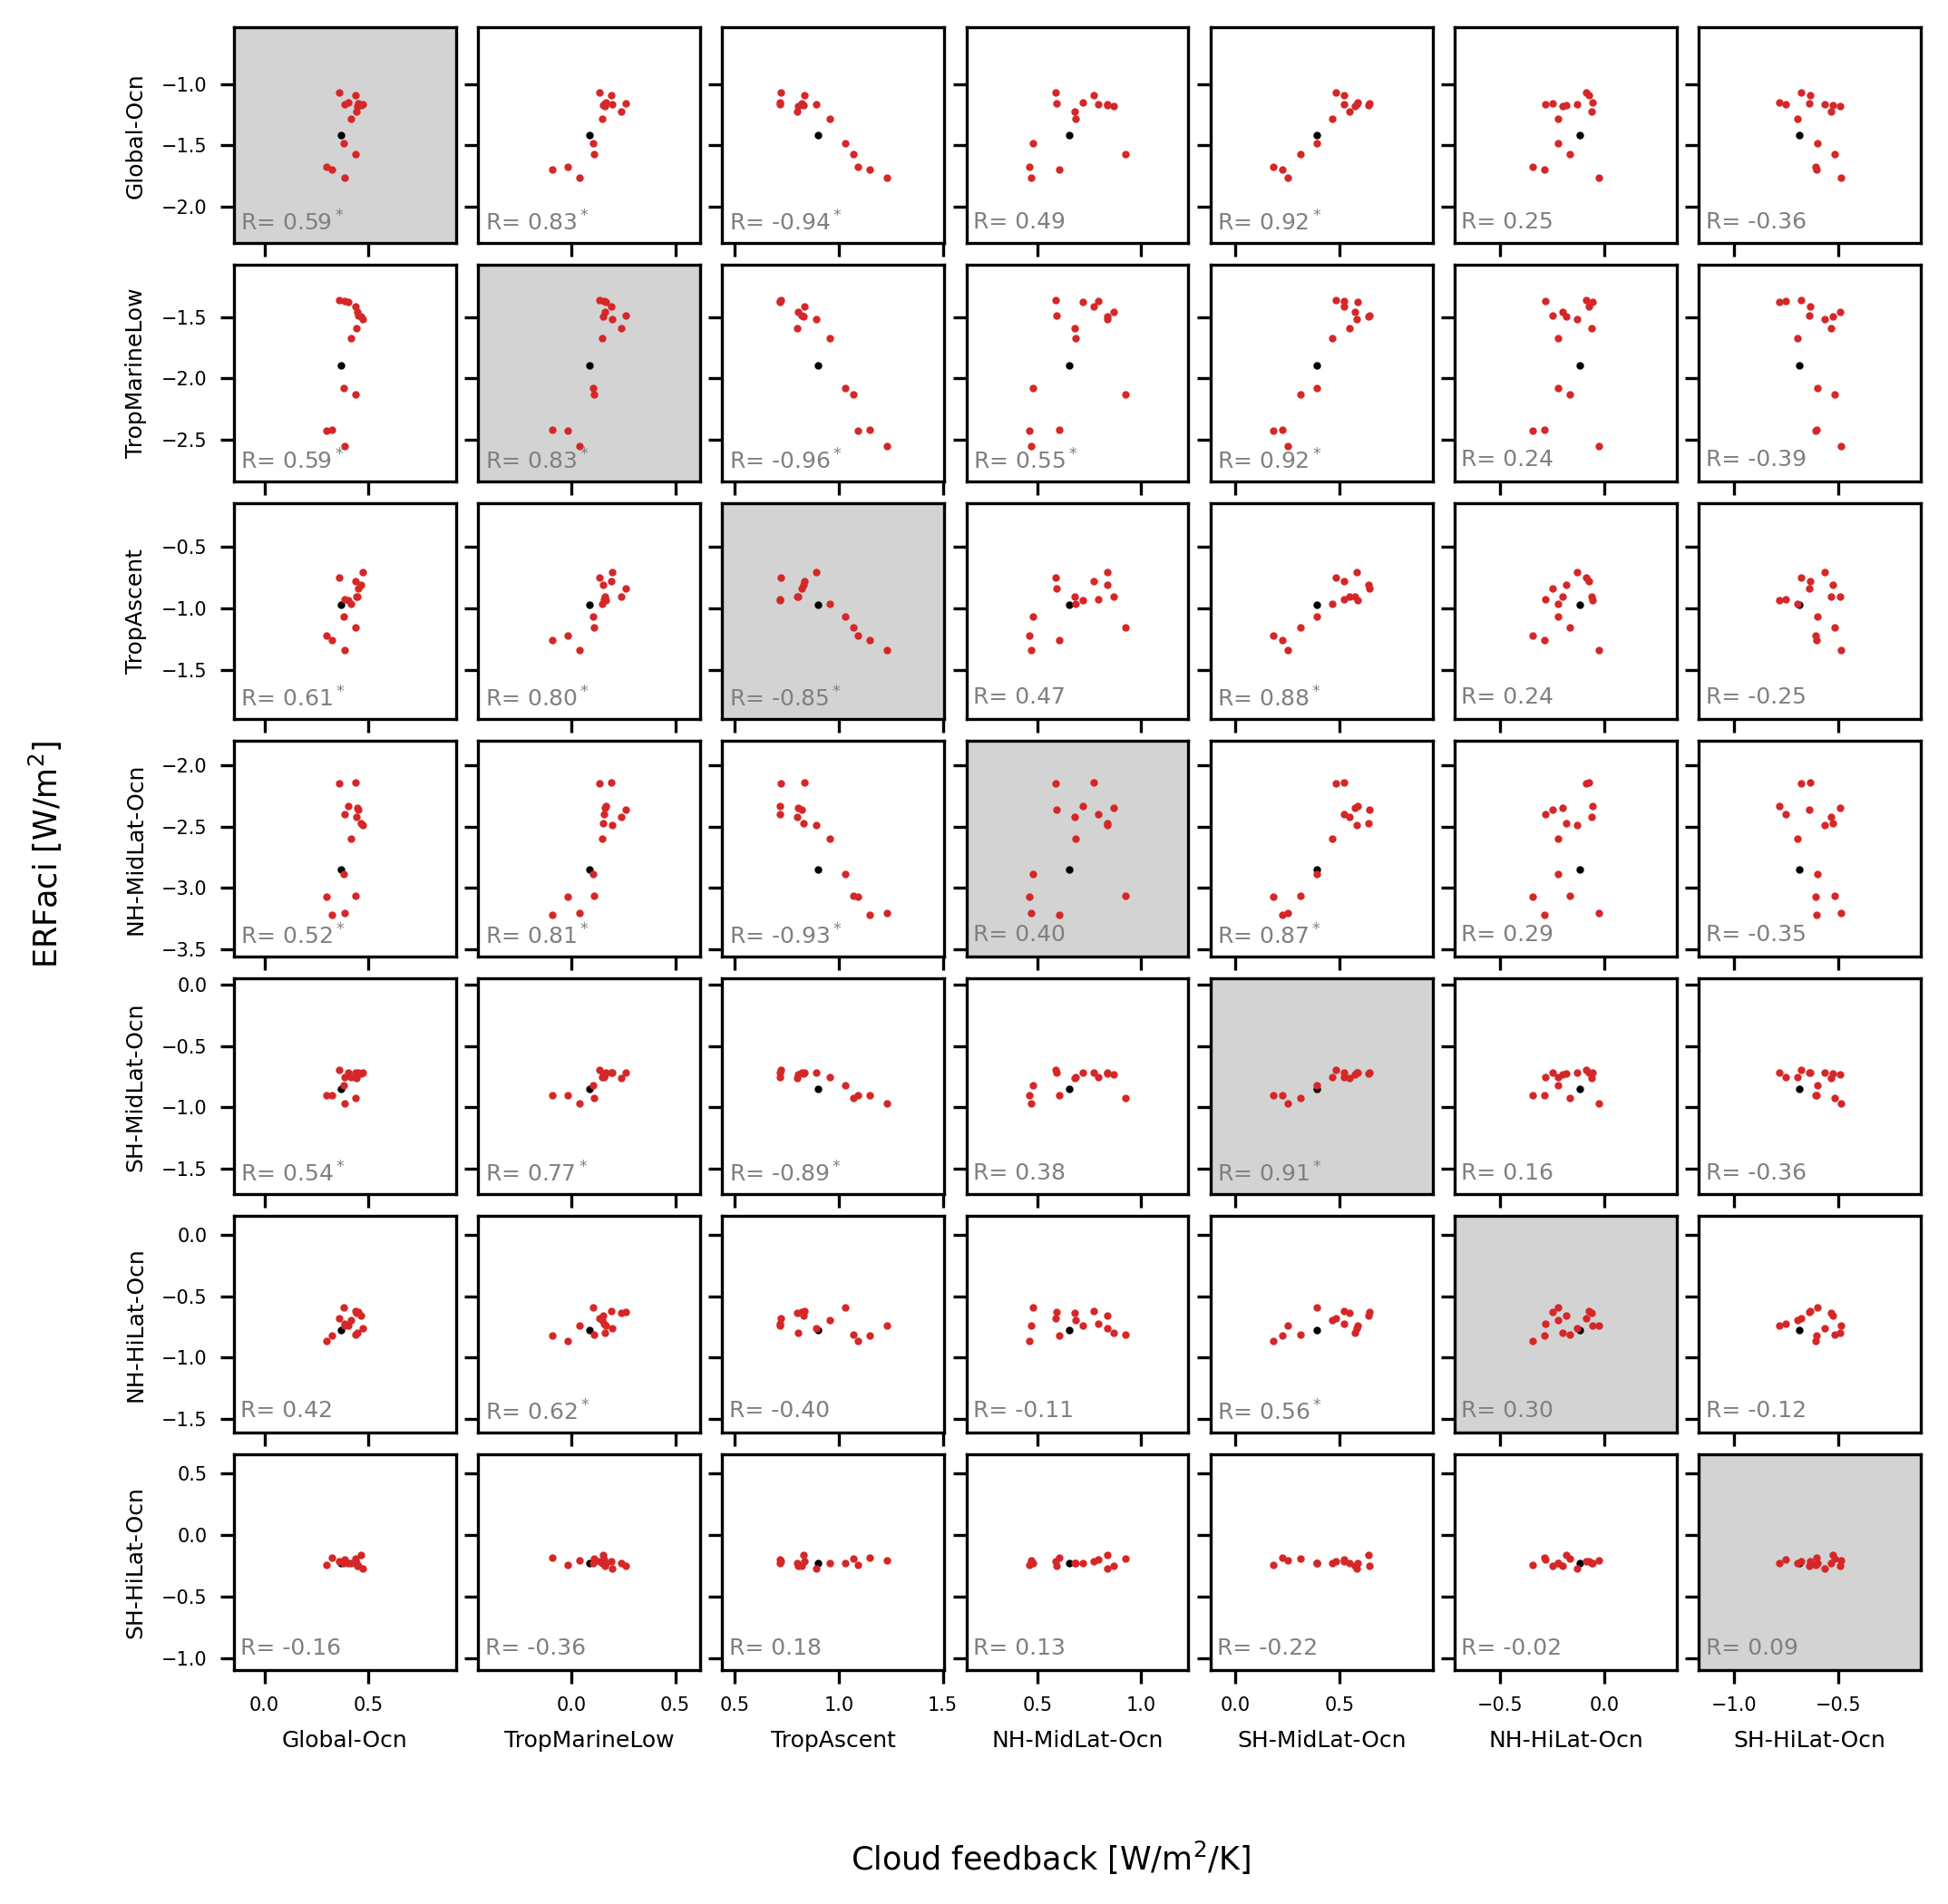

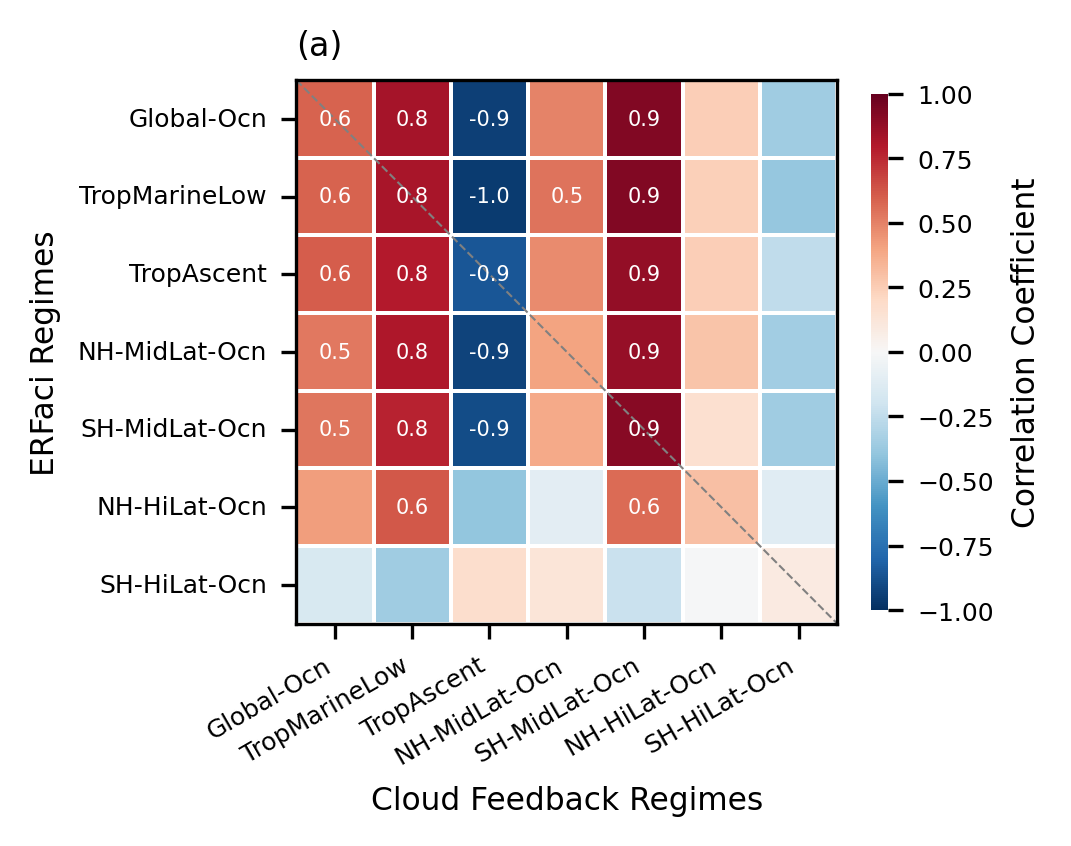

In [28]:
fbk_datasource, aer_datasource = 'RK', 'Ghan'
# fbk_datasource, aer_datasource = 'CRK', 'CRK'

if 'SW' in fbk_datasource or 'LW' in fbk_datasource:  
    band = fbk_datasource.split('_')[1]
    band2 = band+' '
    if 'LO' in fbk_datasource or 'HI' in fbk_datasource: 
        band = fbk_datasource.split('_')[2] 
        band2 = band2+band+' ' 
else: 
    band = '' 
    band2 = band 
    if 'LO' in fbk_datasource or 'HI' in fbk_datasource:
        band = fbk_datasource.split('_')[1] 
        band2 = band2+band+' '  

print(f'fbk_datasource = {fbk_datasource}, band2 = {band2}') 

_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)
_, Vars_aer = misc.get_aer_method_info(aer_datasource) 

included_categories = [
    # None, 
    # prc, 
    turbc,
    # mixc, deepc,
    # aerc, 
    ] 
included_categories_labels = [
    # 'All',
    # 'warm-rain',
    'turbulence',
    # 'mixed-phase','deep convection',
    # 'aerosol', 
    ]

for included_category, included_category_label in zip(included_categories, included_categories_labels): 
    tag = 'ACI_vs_CFBK_'+included_category_label

    mpl.rcParams['font.size'] = 7
    mpl.rcParams['axes.labelsize'] = 6
    mpl.rcParams['xtick.labelsize'] = 5
    mpl.rcParams['ytick.labelsize'] = 5
    mpl.rcParams['axes.titlesize'] = 7

    # fig = plt.figure(figsize=(24,24)) 
    fig = plt.figure(figsize=(8,8), dpi=300) 
    nrow = len(regimes_plot)
    ncol = nrow  

    df_corr = pd.DataFrame()  # correlation matrix 
    df_pvalues = pd.DataFrame() 

    ii = 0 
    # Loop over each regime for ERFaci
    for name_aci in regimes_plot:   

        # Loop over each regime for cloud feedback 
        for name_fbk in regimes_plot:  

            ax = fig.add_subplot(nrow,ncol,ii+1)   

            XXa = []
            YYa = []
            casesa = [] 
            for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
                casesA = dicc[exp] 
                cases_here = [case[0] for case in casesA]
                colors_here = [case[1] for case in casesA]
                values = [case[2] for case in casesA]

                if included_category != None: 
                    if colors_here[1] != included_category:   
                        continue 
                print(exp, casesA) 

                for icase,case in enumerate(cases_here): 

                    # # Test the impact of the two samples... 
                    # if case in ['c1','c8_3']: 
                    #     continue 

                    caseid = cases_here.index(case)

                    if case not in casesa:
                        casesa.append(case)
                    else:
                        continue 

                    xx = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_fbk+'_avg']).values
                    yy = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_aci+'_avg']).values

                    cc = colors_here[icase] 
                    ax.plot(xx,yy, marker='.',ms=2, c=cc) 
                    
                    # # label each case name in scatter plot
                    # ax.text(xx,yy,case, fontsize=3)   

                    XXa.append(xx)
                    YYa.append(yy) 

                # title_obj = ax.set_title(exp)  
                # plt.setp(title_obj, color=colorsh[1]) 

            print(f'len(XXa)={len(XXa)},{len(YYa)}') 
            print('XXa=',XXa)
            print('YYa=',YYa) 

            # # ======================== Data Range ======================== 
            # ax.fill([np.min(XXa), np.max(XXa), np.max(XXa), np.min(XXa)], [np.min(YYa), np.min(YYa), np.max(YYa), np.max(YYa)], 
            #         fill=False, alpha=0.5,
            #         facecolor='None',edgecolor='Grey')

            # ======================== reset axis limits ===============================
            if 'LO' in fbk_datasource or 'HI' in fbk_datasource: 
                scale = 0.6
            else:
                scale = 1.1 
            
            y_range = 1.6 * scale 
            x_range = 0.97 * scale              
            new_x, new_y = misc.update_x_limits(ax.get_xlim(), x_range)   
            ax.set_xlim((new_x, new_y)) 

            new_x, new_y = misc.update_x_limits(ax.get_ylim(), y_range) 
            ax.set_ylim((new_x, new_y)) 

            # ======================== Regression ======================== 
            r_value, p_value,_ = misc.add_regress_line(XXa,YYa,ax,xpos=0.03,ypos=0.15,add_line=False,color='grey',show_pvalue=False,show_text=True)    
            print(f'r_value= {r_value}, p_value = {p_value}') 

            df_corr.loc[name_aci+'_aci', name_fbk+'_fbk'] = r_value 
            df_pvalues.loc[name_aci+'_aci', name_fbk+'_fbk'] = p_value 

            if name_aci == name_fbk:
                ax.set_facecolor('lightgrey') 
                
            fig.supxlabel(band2+'Cloud feedback [W/m$^2$/K]',y=0.03) 
            fig.supylabel(band2+'ERFaci [W/m$^2$]',x=0.03) 
    

            if ii%ncol != 0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(textwrap.fill(name_aci,15))  

            if ii//ncol != nrow-1: 
                ax.set_xticklabels([]) 
            else:
                ax.set_xlabel(textwrap.fill(name_fbk,15))  

            ii += 1 

    # fig.tight_layout() 
    fig.subplots_adjust(wspace=0.1, hspace=0.1) 

    filename = 'Pairplot_'+tag+'_CldRegime_each_regime_'+dd+'.png'
    fig.savefig(figdir+filename, bbox_inches='tight') 

    # =====================================================================
    # Save correlation matrix 
    # =====================================================================
    df_corr.to_csv(figdir+'Corr_matrix_'+tag+'.csv') 
    df_pvalues.to_csv(figdir+'Pvalue_matrix_'+tag+'.csv') 

    # =====================================================================
    # Plot heat map 
    # =====================================================================
    mpl.rcParams['axes.labelsize'] = 7.5
    if regime_method_tag == '_OceanOnly': 
        mpl.rcParams['font.size'] = 6
        mpl.rcParams['xtick.labelsize'] = 7 
        mpl.rcParams['ytick.labelsize'] = 7
    else: 
        mpl.rcParams['font.size'] = 5
        mpl.rcParams['xtick.labelsize'] = 6
        mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 8  

    # fig = plt.figure(figsize=(3.2,3.2), dpi=300)
    # fig = plt.figure(figsize=(6.4,3.2), dpi=300)
    fig = plt.figure(figsize=(6.4,2.4), dpi=300)
    nrow = 1
    ncol = 2 
    ax = fig.add_subplot(nrow,ncol,2)
    
    display(df_corr) 
    
    annotations = df_corr.round(1).astype(str) 
    annotations[df_pvalues > 0.05] = ""

    # newlabels = ['GLO','TML','TA','TLD','NML','NMO','SML','HIL']  
    newlabels = regimes_plot 

    g = sns.heatmap(df_corr,cmap='RdBu_r',
                vmin=-1,vmax=1,
                annot=annotations, fmt="s", 
                linewidth=.5,
                xticklabels = newlabels, yticklabels = newlabels,  
                # cbar_kws={"orientation": "horizontal", "label": "Correlation Coefficient","aspect":30, "pad":0.15,"shrink": 0.9},
                # cbar_kws={"orientation": "horizontal", "label": "Correlation Coefficient","aspect":30, "pad":0.33,"shrink": 0.9},  
                cbar_kws={"orientation": "vertical", "label": "Correlation Coefficient","aspect":30, "pad":0.05,"shrink": 0.95},     
                ax=ax)

    plt.plot([0, 13], [0, 13], '--', color='grey', linewidth=0.5)

    # plt.title(included_category_label+' [N='+str(len(XXa))+']')  

    # ax.set_title('(b)', loc = 'left') 
    ax.set_title('(a)', loc = 'left') 
    
    ax.set_xlabel(band2+'Cloud Feedback Regimes')
    ax.set_ylabel(band2+'ERFaci Regimes')

    # g.figure.axes[-1].yaxis.label.set_size(14)

    if regime_method_tag in ['_OceanOnly','_OceanOnly30SN']:  
        plt.xticks(rotation=30,ha='right') 
    elif regime_method_tag == '_LndOcn': 
        plt.xticks(rotation=90,ha='center') 
     
    plt.yticks(rotation=0)

    for _, spine in g.spines.items():
        spine.set_visible(True)

    # ================ Global ocean averaged CF and ERFaci scatter plot =============== 

    # # ================ Global-mean CF and ERFaci scatter plot =======================
    # ax2 = fig.add_subplot(nrow,ncol,1) 
    
    # Vars = [
    # # tag , aer_method, fbk_method, aer_var, fbk_var, ctl_var 
    # ['Ghan','Ghan', 'RK' , 'ACI', 'netCRE_ano_grd_adj', 'netCRE'],
    # ] 
    # _ = plot_one_scatter_ACI_vs_CFBK(Vars,included_categories, included_categories_labels, fig,ax2,dicc,log=False,
    #                                  text_xpos=0.03, text_ypos=0.25, 
    #                                  ) 

    # pos_ax1 = ax.get_position()
    # pos_ax2 = ax2.get_position()
    # print('Before pos_ax1 = ', pos_ax1, 'pos_ax2 = ', pos_ax2) 
    # pos_ax2.y0 = pos_ax1.y0 - 0.1  # Match bottom position of ax2 with ax1
    # # pos_ax2.y1 = pos_ax1.y1 
    # print('After pos_ax1 = ', pos_ax1, 'pos_ax2 = ', pos_ax2)
    # ax2.set_position(pos_ax2)  

    # ax2.set_box_aspect(1)
    # ax2.set_title('(a) Global-mean', loc='left')  
    
    # # fig.tight_layout() 
    
    filename = 'Heatmap_'+tag+'_CldRegime_each_regime_'+dd+'.png'
    fig.savefig(figdir+filename, bbox_inches='tight') 
    

## Scatter plot of ERFaci and CF components (Figure S4)

RK ['netCRE_ano_grd_adj']
Ghan ['ACI']

fbk_datasource=RK, aer_datasource=Ghan, name_aci=Global-Ocn, name_fbk=Global-Ocn, regime_frac=0.709297030256948

fbk_datasource=RK, aer_datasource=Ghan, name_aci=TropAscent, name_fbk=TropAscent, regime_frac=0.1612714464479139

fbk_datasource=RK, aer_datasource=Ghan, name_aci=TropMarineLow, name_fbk=TropMarineLow, regime_frac=0.21030345034551934

fbk_datasource=RK, aer_datasource=Ghan, name_aci=SH-MidLat-Ocn, name_fbk=SH-MidLat-Ocn, regime_frac=0.170679392385255
CRK_tau ['ALL_NETcld_tau']
CRK_tau ['ALL_NETcld_tau']

fbk_datasource=CRK_tau, aer_datasource=CRK_tau, name_aci=Global-Ocn, name_fbk=Global-Ocn, regime_frac=0.709297030256948

fbk_datasource=CRK_tau, aer_datasource=CRK_tau, name_aci=TropAscent, name_fbk=TropAscent, regime_frac=0.1612714464479139

fbk_datasource=CRK_tau, aer_datasource=CRK_tau, name_aci=TropMarineLow, name_fbk=TropMarineLow, regime_frac=0.21030345034551934

fbk_datasource=CRK_tau, aer_datasource=CRK_tau, name_aci=SH-MidLat-


fbk_datasource=CRK_amt, aer_datasource=CRK_amt, name_aci=TropAscent, name_fbk=TropAscent, regime_frac=0.1612714464479139

fbk_datasource=CRK_amt, aer_datasource=CRK_amt, name_aci=TropMarineLow, name_fbk=TropMarineLow, regime_frac=0.21030345034551934

fbk_datasource=CRK_amt, aer_datasource=CRK_amt, name_aci=SH-MidLat-Ocn, name_fbk=SH-MidLat-Ocn, regime_frac=0.170679392385255
CRK_alt ['ALL_NETcld_alt']
CRK_alt ['ALL_NETcld_alt']

fbk_datasource=CRK_alt, aer_datasource=CRK_alt, name_aci=Global-Ocn, name_fbk=Global-Ocn, regime_frac=0.709297030256948

fbk_datasource=CRK_alt, aer_datasource=CRK_alt, name_aci=TropAscent, name_fbk=TropAscent, regime_frac=0.1612714464479139

fbk_datasource=CRK_alt, aer_datasource=CRK_alt, name_aci=TropMarineLow, name_fbk=TropMarineLow, regime_frac=0.21030345034551934

fbk_datasource=CRK_alt, aer_datasource=CRK_alt, name_aci=SH-MidLat-Ocn, name_fbk=SH-MidLat-Ocn, regime_frac=0.170679392385255


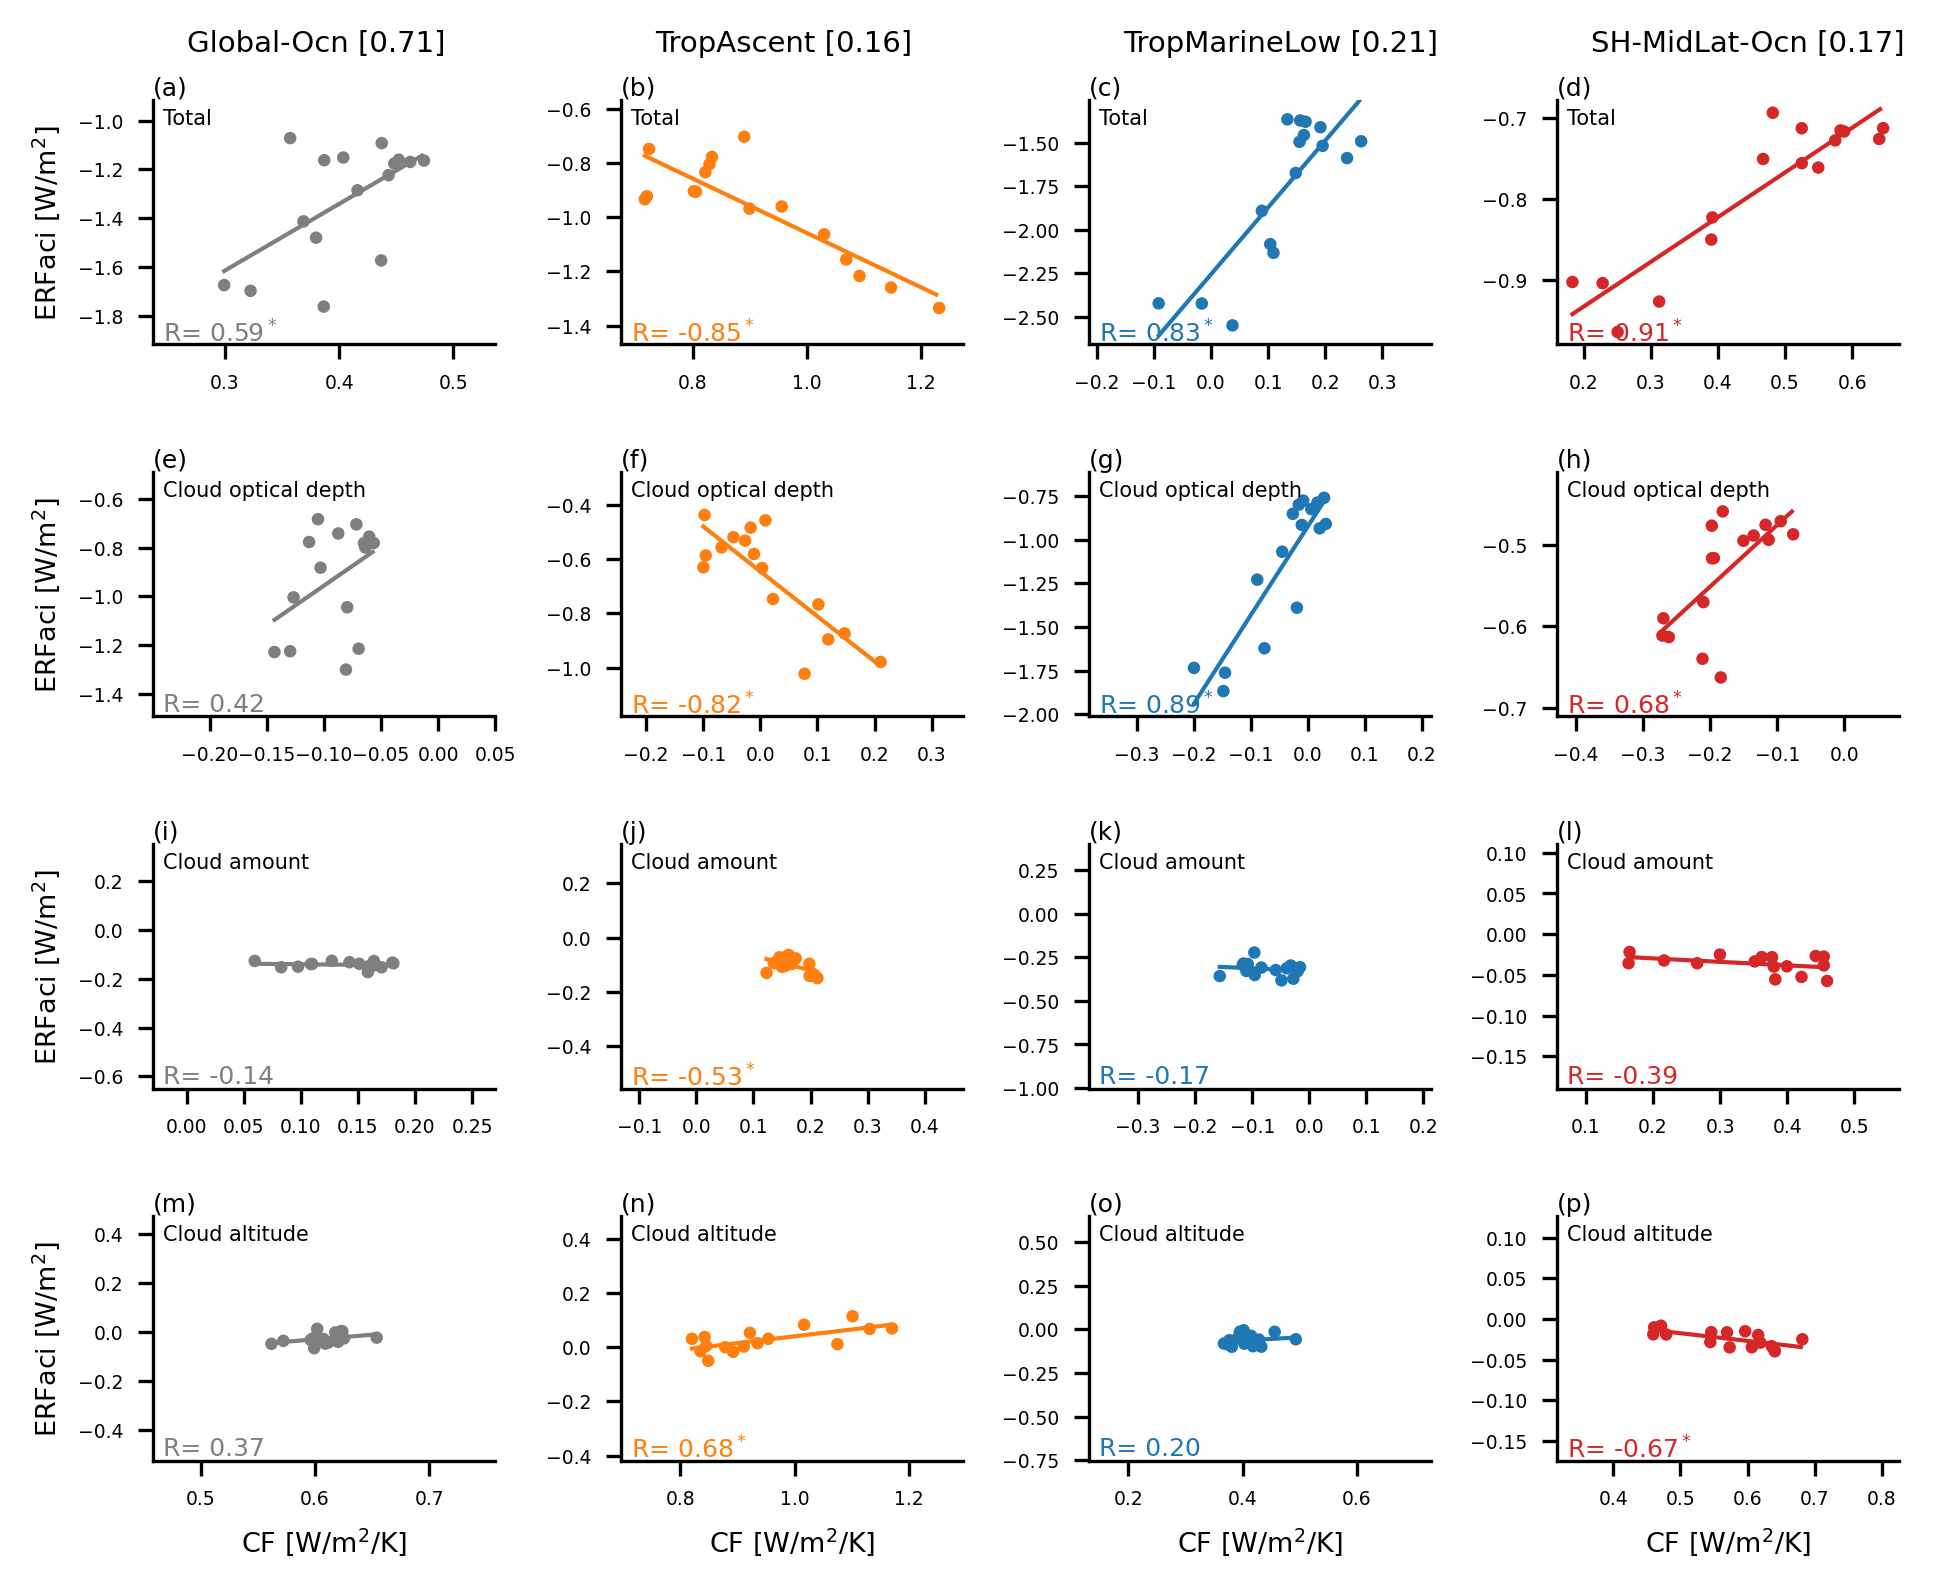

In [30]:
regimes_here = [
    ['Global-Ocn', 'Global-Ocn', ['turbulence'], [turbc],'tab:grey'], 
    ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
    ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
    ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
]

mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.labelsize'] = 6.5
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['axes.titlesize'] = 6

state_var_here = 'LWP_LS' 

fbk_datasources_here = ['RK','CRK_tau','CRK_amt','CRK_alt'] 
aer_datasources_here = ['Ghan','CRK_tau','CRK_amt','CRK_alt'] 

if len(fbk_datasources_here) == 4:
    figsize = (6.5,5.5)
    nrow = 5
    ncol = 5
    gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 0.1])
else: 
    figsize = (6.5,4.5) 
    nrow = 4
    ncol = 5
    gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 0.1]) 


figsize = (6.5,5.5) 
nrow = 5
ncol = 4
gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 0.1]) 

# # Including NH-MidLat-Ocn... 
# figsize = (8.5,5.5) 
# nrow = 5
# ncol = 5
# gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 0.1]) 

fig = plt.figure(figsize=figsize, dpi=300) 

ii = 0 
for fbk_datasource, aer_datasource in zip(fbk_datasources_here, aer_datasources_here):  
    
    _, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)
    _, Vars_aer = misc.get_aer_method_info(aer_datasource) 
    print(fbk_datasource, Vars_fbk)
    print(aer_datasource, Vars_aer) 

    # Loop over each regime for ERFaci
    scatters = [] 
    for regime_here in regimes_here:
        name_aci, name_fbk, included_categories_labels, included_categories,regime_color = regime_here 
        if name_aci == 'Global' and name_fbk == 'Global': 
            regime_frac = 1.0
        else: 
            regime_frac = v1v2.area_averager(dics_fbk_4yr[fbk_datasource]['BASE'][Vars_fbk[0]][name_fbk+'_frc_avg']).values
        
        print() 
        print(f'fbk_datasource={fbk_datasource}, aer_datasource={aer_datasource}, name_aci={name_aci}, name_fbk={name_fbk}, regime_frac={regime_frac}')  
        
        name_aci_label = misc.get_regime_label(name_aci) 
        name_fbk_label = misc.get_regime_label(name_fbk) 

        # ax = fig.add_subplot(nrow,ncol,ii+1)
        # print(ii//ncol,ii%ncol) 
        ax = fig.add_subplot(gs[ii//ncol,ii%ncol])

        if ii<ncol: # add regime information to the first row subplots
            xpos = 0.1
            ypos = 1.2
            ax.text(xpos,ypos,name_fbk+' ['+str(np.round(regime_frac,2))+']',transform=ax.transAxes) 
        
        XXa = []
        YYa = []
        casesa = [] 
        fsa = [] 
        cca = []
        for included_category, included_category_label in zip(included_categories, included_categories_labels): 
            
            for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
                casesA = dicc[exp] 
                cases_here = [case[0] for case in casesA]
                colors_here = [case[1] for case in casesA]
                values = [case[2] for case in casesA]

                if included_category != None: 
                    if colors_here[1] != included_category:   
                        continue 

                for icase,case in enumerate(cases_here): 

                    # if case in ['c1','c8_3']:
                    #     continue 

                    caseid = cases_here.index(case)

                    if case not in casesa:
                        casesa.append(case)
                    else:
                        continue 

                    if state_var_here in ['TGCLDLWP','LWP_LS']:
                        scale = 1e3
                    else:
                        scale = 1.0 
                        
                    fs = dics_fbk_state[state_var_here][case][state_var_here+'_pi_clim'][name_fbk+'_avg'].values * scale 

                    xx = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_fbk+'_avg']).values
                    yy = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_aci+'_avg']).values

                    cc = colors_here[icase] 
                    # ax.plot(xx,yy, marker='.',ms=2, c=cc)   

                    XXa.append(xx)
                    YYa.append(yy) 
                    fsa.append(fs)
                    cca.append(regime_color)  
                
        ss = misc.get_marker_size(fsa) 
        # scatter = ax.scatter(XXa, YYa, s=5,c=fsa) 
        scatter = ax.scatter(XXa, YYa, s=4,c=cca)  
         
        # cbar = plt.colorbar(scatter, ax=ax, label='Mean-state LWP [g/m$^2$]',orientation='horizontal',fraction=0.05,shrink=0.7)    
        scatters.append(scatter) 

        # ## Add case name
        # for i, txt in zip(range(len(XXa)), casesa): 
        #     ax.annotate(txt, (XXa[i], YYa[i]),fontsize=4)  

        # ======================== reset axis limits ===============================
        if name_fbk == 'TropAscent': 
            x_range = 0.6
            y_range = 0.9 
        elif name_fbk == 'TropMarineLow':
            x_range = 0.6
            y_range = 1.4 
        elif name_fbk == 'SH-MidLat-Ocn':
            x_range = 0.51
            y_range = 0.3
        elif name_fbk == 'Global-Ocn': 
            x_range = 0.3
            y_range = 1.0 

        # x_range = 1.0 #0.6
        # y_range = 1.5 
                
        new_x, new_y = misc.update_x_limits(ax.get_xlim(), x_range)   
        ax.set_xlim((new_x, new_y)) 

        new_x, new_y = misc.update_x_limits(ax.get_ylim(), y_range) 
        ax.set_ylim((new_x, new_y)) 

        # ======================== Regression ======================== 
        r_value, p_value,_ = misc.add_regress_line(XXa,YYa,ax,xpos=0.03,ypos=0.10,add_line=True,color=regime_color,show_pvalue=False,show_text=True)    
        # print(f'r_value= {r_value}, p_value = {p_value}') 


        fbk_datasource_label = misc.get_method_label(fbk_datasource) 
        ax.set_title('('+chr(ord('`')+(ii+1))+')', loc='left', pad=1)    
        ax.text(0.03,0.90, fbk_datasource_label, transform=ax.transAxes,fontsize=5)    

        # ax.tick_params(which="major", axis="x", direction="inout") 
        # ax.tick_params(which="major", axis="y", direction="inout") 
        ax.tick_params(axis='both', which='major', labelsize=4.5)

        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)
    

        if ii%ncol == 0:
            ax.set_ylabel('ERFaci [W/m$^2$]') 

        if ii//ncol == nrow-2: 
            ax.set_xlabel('CF [W/m$^2$/K]')  

        ii += 1 

# for jj in range(5): 
#     if len(fbk_datasources_here) == 4:
#         ax = fig.add_subplot(gs[4,jj])
#     else: 
#         ax = fig.add_subplot(gs[3,jj])
        
#     cbar = plt.colorbar(scatters[jj], cax=ax, label='Mean-state LWP [g/m$^2$]',orientation='horizontal',shrink=0.5) 
#     # Set the number of desired tick labels on the color bar
#     desired_num_ticks = 4
#     # Set the locator for the color bar
#     cbar.locator = MaxNLocator(nbins=desired_num_ticks)
#     # Update the ticks on the color bar
#     cbar.update_ticks() 
#     cbar.ax.tick_params(labelsize=5)    

fig.tight_layout() 
# fig.subplots_adjust(wspace=0.4, hspace=0.4) 

filename = 'Scatterplot_Selected_CldRegime_cloud_components_'+dd+'.pdf'
# fig.savefig(figdir+filename, bbox_inches='tight') 


## wp2 vs ERFaci (Figure 2a-c)

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
TropAscent peak_lev= 70000 95000 1.4249481134694924 -0.033809704045766435
TropAscent peak_lev= 70000 95000 1.8334365783348177 -0.04285707238595768
TropAscent peak_lev= 70000 95000 1.2304706295500858 -0.03524157399997097
TropAscent peak_lev= 70000 95000 2.0654837015369094 -0.049117402250277116
TropAscent peak_lev= 70000 95000 1.2001827777202907 -0.03293344314164342
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
TropAscent peak_lev= 70000 95000 1.285857595485465 -0.030828812746668197
TropAscent peak_lev= 70000 95000 1.5996625199312673 -0.03907394101412655
TropAscent peak_lev= 70000 95000 1.27767815395706 -0.03758393957122382
TropAscent peak_lev= 70000 95000 1.636437228863989 -0.03880537203767443
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef

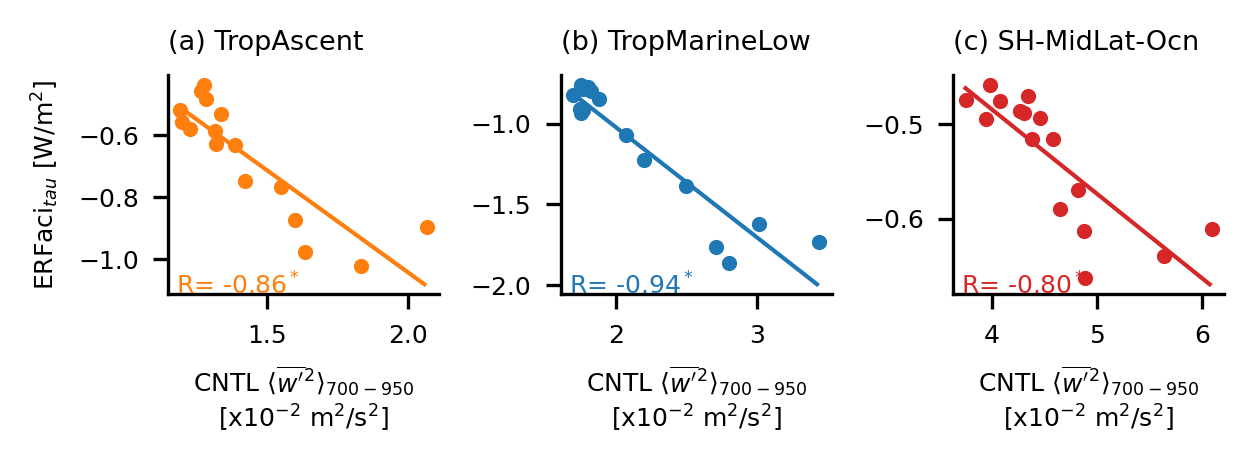

In [34]:
importlib.reload(misc) 

regimes_here = [
    ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
    ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
    ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
]

fbk_datasource, aer_datasource = 'CRK_tau', 'CRK_tau'

_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)
_, Vars_aer = misc.get_aer_method_info(aer_datasource) 

for var1 in [    
    'WP2_CLUBB', 
]: 

    var1_unit,scale1,var1_label = misc.get_var_unit(var1) 
    if var1 == 'WP2_CLUBB':
        var1_label = r'$\langle\overline{{w}^{\prime}}^{2}\rangle_{700-950}$'

    var2 = 'LWP_LS'
    var2_unit,scale2,var2_label = misc.get_var_unit(var2) 
    var3 = 'LWP_LS'
    var3_unit,scale3,var3_label = misc.get_var_unit(var3) 

    mpl.rcParams['font.size'] = 7
    mpl.rcParams['axes.labelsize'] = 6
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 6.5

    fig = plt.figure(figsize=(5.5,5), dpi=300) 
    nrow = 4
    ncol = 4

    gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1]) 

    ii = 0 
    # Loop over each regime for ERFaci
    for ireg,regime_here in enumerate(regimes_here):   
        name_aci, name_fbk, included_categories_labels, included_categories,regime_color = regime_here 
        if name_aci == 'Global' and name_fbk == 'Global': 
            regime_frac = 1.0
        else: 
            regime_frac = v1v2.area_averager(dics_fbk_4yr[fbk_datasource]['BASE'][Vars_fbk[0]][name_fbk+'_frc_avg']).values
            
        
        name_aci_label = misc.get_regime_label(name_aci) 
        name_fbk_label = misc.get_regime_label(name_fbk) 

        ax00 = fig.add_subplot(gs[0,ireg])  # mean-state var vs delta var
        # ax01 = fig.add_subplot(gs[1,ireg])  
        # ax02 = fig.add_subplot(gs[2,ireg]) 
        # ax03 = fig.add_subplot(gs[3,ireg]) 
        
        casesa = []
        XX1a = []
        XX1da = []
        XX2a = []
        XX2da = []
        XX3a = []
        XX3da = []
        YYa = []
        for included_category, included_category_label in zip(included_categories, included_categories_labels): 
        
            for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
                casesA = dicc[exp] 
                cases_here = [case[0] for case in casesA]
                colors_here = [case[1] for case in casesA]
                values = [case[2] for case in casesA]

                if included_category != None: 
                    if colors_here[1] != included_category:   
                        continue 
                print(exp, casesA) 

                for icase,case in enumerate(cases_here): 

                    caseid = cases_here.index(case)

                    if case not in casesa:
                        casesa.append(case)
                    else:
                        continue 

                    dics_p = dics_aci_state
 
                    xx1 = dics_p[var1][case][var1+'_pi_clim'][name_fbk+'_avg']
                    xx1d = dics_p[var1][case][var1+'_ano_clim'][name_fbk+'_avg']

                    xx1 = xx1 * scale1
                    xx1d = xx1d * scale1 

                    if var1 in var3d: 
                        peak_lev = 70000
                        lev_offset = 25000
                        level_here_2 = peak_lev + lev_offset 
                        
                        xx1 = xx1.sel(plev=slice(level_here_2,peak_lev)).mean(dim='plev')
                        xx1d = xx1d.sel(plev=slice(level_here_2,peak_lev)).mean(dim='plev')
                        print(name_fbk, 'peak_lev=',peak_lev, level_here_2, xx1.values, xx1d.values) 

                    xx2 = dics_aci_state[var2][case][var2+'_pi_clim'][name_fbk+'_avg'].values * scale2 
                    xx2d = dics_aci_state[var2][case][var2+'_ano_clim'][name_fbk+'_avg'].values * scale2 
                    xx3 = dics_aci_state[var3][case][var3+'_pi_clim'][name_fbk+'_avg'].values * scale3 
                    xx3d = dics_aci_state[var3][case][var3+'_ano_clim'][name_fbk+'_avg'].values * scale3 
                    
                    # yy1 = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_fbk+'_avg']).values

                    yy = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_aci+'_avg']).values

                    XX1a.append(xx1)
                    XX1da.append(xx1d)
                    XX2a.append(xx2)
                    XX2da.append(xx2d)
                    XX3a.append(xx3)
                    XX3da.append(xx3d) 
                    YYa.append(yy) 

        jj = 0 
        for axp, datapx, datapy, xlabel, ylabel in [
            [ax00, XX1a, YYa, f'CNTL {var1_label}\n[{var1_unit}]', 'ERFaci$_{tau}$ [W/m$^2$]',],
            # [ax01, XX1da, YYa, f'$\Delta$ {var1_label} [{var1_unit}]', 'ERFaci$_{tau}$ [W/m$^2$]',],
            # [ax02, XX2da, YYa, f'$\Delta$ {var2_label} [{var2_unit}]', f'ERFaci [W/m$^2$]'], 
            # [ax03, XX1a, XX1da, f'CNTL {var1_label} [{var1_unit}]', f'$\Delta$ {var1_label} [{var1_unit}]'], 
        ]: 
            axp.scatter(datapx, datapy, s=7, 
                        c=[regime_color], 
                        label=misc.get_regime_label(name_aci))  
            
            # # ---- add each dot by case name 
            # icase = 0 
            # for idatapx,idatapy in zip(datapx,datapy): 
            #     axp.text(idatapx,idatapy,casesa[icase],fontsize=3) 
            #     icase += 1 
            # # ---- 

            xpos = 0.03
            ypos = 0.10#+ireg*0.08

            # xpos = np.median(datapx)
            # ypos = np.median(datapy) 
            r1_1, _,slope1_1 = misc.add_regress_line(datapx, datapy,axp,xpos=xpos,ypos=ypos,add_line=True,
                                                     color=regime_color,show_pvalue=False,show_text=True,
                                                     transform_format='axes',prefix_str='',auto_move_text=True) 
            axp.set_xlabel(xlabel)

            if ireg == 0: 
                axp.set_ylabel(ylabel)

            # Hide top and right spines
            axp.spines['top'].set_visible(False)
            axp.spines['right'].set_visible(False)
            # Show only the left and bottom ticks
            axp.tick_params(axis='x', bottom=True, top=False)
            axp.tick_params(axis='y', left=True, right=False)

            axp.set_title('('+chr(ord('`')+(jj*ncol+ireg+1))+') '+name_aci,loc='left')   

            # axp.set_title(name_aci,loc='center') 
            # axp.legend(fontsize=6,loc='upper left') 

            jj += 1 
            ii += 1 

    fig.tight_layout()

    filename = 'Scatterplot_Mean-state-turb-mixing_vs_ERFacitau_'+dd+'.pdf'
    # fig.savefig(figdir+filename, bbox_inches='tight') 



## wp2 vs CF (Figure 2d-f)

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
TropAscent peak_lev= 95000 70000
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red'

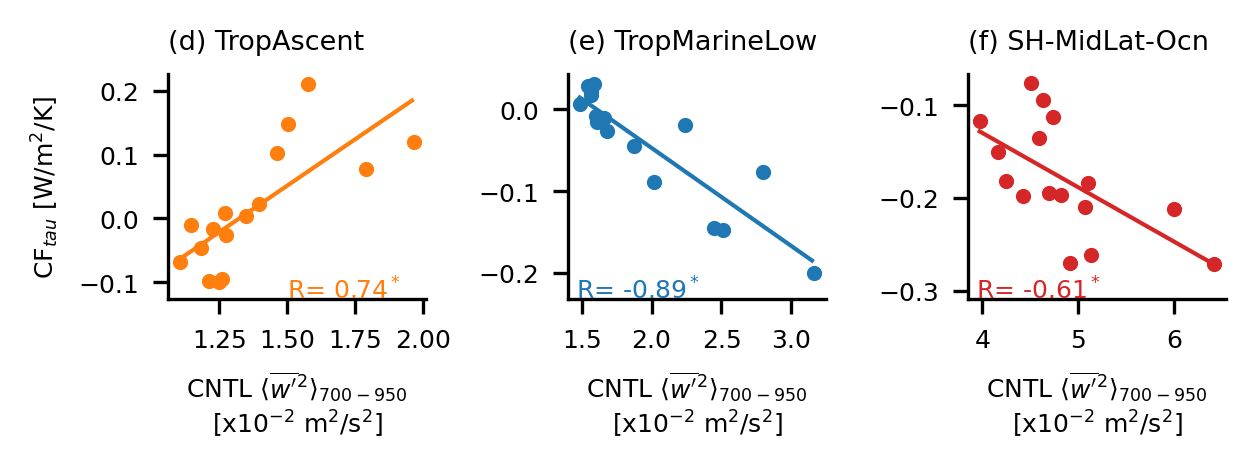

In [35]:
importlib.reload(misc)

regimes_here = [
    ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
    ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
    ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
]

fbk_datasource, aer_datasource = 'CRK_tau', 'CRK_tau'
_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)
_, Vars_aer = misc.get_aer_method_info(aer_datasource) 


for var1 in [
    'WP2_CLUBB',
]: 
    var1_unit,scale1,var1_label = misc.get_var_unit(var1) 
    if var1 == 'WP2_CLUBB':
        var1_label = r'$\langle\overline{{w}^{\prime}}^{2}\rangle_{700-950}$'
           
    var2 = 'LWP_LS' 
    var2_unit,scale2,var2_label = misc.get_var_unit(var2) 
    var3 = 'LWP_LS'
    var3_unit,scale3,var3_label = misc.get_var_unit(var3) 

    fig = plt.figure(figsize=(5.5,5), dpi=300) 
    nrow = 4
    ncol = 4
    gs = GridSpec(nrow,ncol, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1]) 

    mpl.rcParams['font.size'] = 6
    mpl.rcParams['axes.labelsize'] = 6
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 6.5


    # ax00 = fig.add_subplot(gs[0,0])  # mean-state var vs delta var
    # ax01 = fig.add_subplot(gs[0,1]) # delta var vs delta LWP
    # # ax01 = ax00.twinx() 
    # ax02 = fig.add_subplot(gs[0,2]) # delta LWP vs CF/ERFaci 
    # ax03 = fig.add_subplot(gs[0,3])

    ii = 0 
    # Loop over each regime for ERFaci
    for ireg,regime_here in enumerate(regimes_here):     
        name_aci, name_fbk, included_categories_labels, included_categories,regime_color = regime_here 
        if name_aci == 'Global' and name_fbk == 'Global': 
            regime_frac = 1.0
        else: 
            regime_frac = v1v2.area_averager(dics_fbk_4yr[fbk_datasource]['BASE'][Vars_fbk[0]][name_fbk+'_frc_avg']).values
        
        name_aci_label = misc.get_regime_label(name_aci) 
        name_fbk_label = misc.get_regime_label(name_fbk) 

        ax00 = fig.add_subplot(gs[0,ireg])  # mean-state var vs delta var
        ax01 = fig.add_subplot(gs[1,ireg]) # delta var vs delta LWP
        ax02 = fig.add_subplot(gs[2,ireg]) # delta LWP vs CF/ERFaci 
        # ax03 = fig.add_subplot(gs[3,ireg])
        
        casesa = []
        XX1a = []
        XX1da = []
        XX2a = []
        XX2da = []
        XX3a = []
        XX3da = []
        YYa = []
        for included_category, included_category_label in zip(included_categories, included_categories_labels): 
            for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
                casesA = dicc[exp] 
                cases_here = [case[0] for case in casesA]
                colors_here = [case[1] for case in casesA]
                values = [case[2] for case in casesA]

                if included_category != None: 
                    if colors_here[1] != included_category:   
                        continue 
                print(exp, casesA) 

                for icase,case in enumerate(cases_here): 
                    
                    # if case in ['c1','c8_3']:
                    #     continue 

                    caseid = cases_here.index(case)

                    if case not in casesa:
                        casesa.append(case)
                    else:
                        continue 

                    dics_p = dics_fbk_state

                    if var1 == 'POP':
                        xx1, xx1d = get_A_divided_by_B(dics_p, case, name_fbk, 'CLDTOT4POP', 'CLDTOT',perK=True) 
                    elif var1 == 'PE':
                        xx1, xx1d = get_A_divided_by_B(dics_p, case, name_fbk, 'PRECT', 'TGCLDCWP',perK=True)  
                    else: 
                        xx1 = dics_p[var1][case][var1+'_pi_clim'][name_fbk+'_avg'] 
                        xx1d = dics_p[var1][case][var1+'_ano_clim'][name_fbk+'_avg'] 
                
                    xx1 = xx1 * scale1
                    xx1d = xx1d * scale1 

                    if var1 in var3d: 
                        peak_lev = 95000
                        lev_offset = 25000 
                        
                        print(name_fbk, 'peak_lev=',peak_lev, peak_lev-lev_offset)  
                        
                        xx1 = xx1.sel(plev=slice(peak_lev,peak_lev-lev_offset)).mean(dim='plev')
                        xx1d = xx1d.sel(plev=slice(peak_lev,peak_lev-lev_offset)).mean(dim='plev')
                        
                    xx2 = dics_p[var2][case][var2+'_pi_clim'][name_fbk+'_avg'].values * scale2                     
                    xx2d = dics_p[var2][case][var2+'_ano_clim'][name_fbk+'_avg'].values * scale2 
                    xx3 = dics_p[var3][case][var3+'_pi_clim'][name_fbk+'_avg'].values * scale3 
                    xx3d = dics_p[var3][case][var3+'_ano_clim'][name_fbk+'_avg'].values * scale3 
                    
                    yy = v1v2.area_averager(dics_fbk_4yr[fbk_datasource][case][Vars_fbk[0]][name_fbk+'_avg']).values

                    # yy = v1v2.area_averager(dics_aci[aer_datasource][case][Vars_aer[0]][name_aci+'_avg']).values

                    XX1a.append(xx1)
                    XX1da.append(xx1d)
                    XX2a.append(xx2)
                    XX2da.append(xx2d)
                    XX3a.append(xx3)
                    XX3da.append(xx3d) 
                    YYa.append(yy) 

        # ==========================================================================================
        # WP2 vs CFtau 
        varlist = [
            [ax00, XX1a, YYa, f"CNTL {var1_label}\n[{var1_unit}]", 'CF$_{tau}$ [W/m$^2$/K]',],
            # [ax01, XX1da, YYa, f'$\Delta$ {var1_label} [{var1_unit}/K]', 'CF$_{tau}$ [W/m$^2$/K]',],
            # [ax00.twiny(), XX1da, YYa, f'$\Delta$ {var1_label} [{var1_unit}/K]', f'CF [W/m$^2$/K]',],
            # [ax01, XX2a, YYa, f'CNTL {var2_label} [{var2_unit}]', f'CF [W/m$^2$/K]',], 
            # [ax02, XX1a, XX1da, f'CNTL {var1_label} [{var1_unit}]', f'$\Delta$ {var1_label} [{var1_unit}/K]',], 
            # [ax03, XX3da, YYa, f'$\Delta$ {var3_label} [{var3_unit}/K]', f'CF [W/m$^2$/K]',],
        ]

        # # ========================================================================================== 
        # # other vars vs CFtau 
        # varlist = [
        #     [ax00, XX1da, YYa, f'$\Delta$ {var1_label}\n[{var1_unit}/K]', 'CF$_{tau}$ [W/m$^2$/K]',],
        # ]

        axes = [] 
        jj = 0 
        for axp, datapx, datapy, xlabel, ylabel in varlist:    
            axes.append(axp) 
                     
            axp.scatter(datapx, datapy, 
                        s=7, 
                        # s=scaled_sizes, 
                        c=[regime_color], alpha=1, label=misc.get_regime_label(name_aci))  

            # # ---- label each dot by case name
            # icase = 0 
            # for idatapx,idatapy in zip(datapx,datapy): 
            #     axp.text(idatapx,idatapy,casesa[icase],fontsize=3)
            #     icase += 1
            # # ----- 
            
            xpos = 0.03
            ypos = 0.10#+ireg*0.08
            r1_1, _,slope1_1 = misc.add_regress_line(datapx, datapy,axp,xpos=xpos,ypos=ypos,add_line=True,color=regime_color,
                                                     show_pvalue=False,show_text=True,transform_format='axes',prefix_str='',auto_move_text=True) 
            axp.set_xlabel(xlabel)

            if ireg == 0: 
                axp.set_ylabel(ylabel) 

            # axp.set_title(name_aci,loc='right') 
                
            # ======== Scientific format of x ticks ========================
            from matplotlib.ticker import ScalarFormatter as stick 
            pow_lims = (-2,3)
            axp.locator_params(axis='x',nbins=4)
            ticks = stick(useMathText=True)
            ticks.set_powerlimits(pow_lims)
            axp.xaxis.set_major_formatter(ticks)
            # Increase fontsize for ticklabels
            axp.tick_params(axis='both')

            # ================================================================ 
            # Hide top and right spines
            axp.spines['top'].set_visible(False)
            axp.spines['right'].set_visible(False)
            # Show only the left and bottom ticks
            axp.tick_params(axis='x', bottom=True, top=False)
            axp.tick_params(axis='y', left=True, right=False)

            if var1 == 'WP2_CLUBB': # only for sup-figure in Figure 2 
                axp.set_title('('+chr(ord('`')+(3+jj*ncol+ireg+1))+') '+name_fbk,loc='left')  
            else: 
                axp.set_title('('+chr(ord('`')+(ii+1))+') '+name_fbk,loc='left') 

            if np.sign(axp.get_ylim()[0]) > 0: 
                axp.set_ylim((np.sign(axp.get_ylim()[0])*np.abs(axp.get_ylim()[0])*0.9,axp.get_ylim()[1])) 
            else: 
                axp.set_ylim((np.sign(axp.get_ylim()[0])*np.abs(axp.get_ylim()[0])*1.1,axp.get_ylim()[1])) 

            jj += 1 
            ii += 1 

        
        ## Add reference line 
        # for axx in [ax00, ax01, ax02, ax03]:
        #     if axx.get_xlim()[0] * axx.get_xlim()[1] < 0:
        #         axx.axvline(x=0,ls='--',c='grey')
        #     if axx.get_ylim()[0] * axx.get_ylim()[1] < 0:
        #         axx.axhline(y=0,ls='--',c='grey') 
            
        # ================================================================ 
        # Remove those axes not used 
        for ax in [ax00,ax01,ax02]: 
            if ax not in axes:
                ax.axis('off') 
                ax.remove() 

    fig.tight_layout()

    # if var1 == 'WP2_CLUBB': 
    #     filename = 'Scatterplot_Mean-state-turb-mixing_vs_CFtau_'+dd+'.pdf'
    #     fig.savefig(figdir+filename, bbox_inches='tight')
    #     print('Figure saved.') 


## wp2 profiles (Figure S8)

Doing var_here = WP2_CLUBB...
Warming effect 70000 95000
Warming effect 70000 95000
Warming effect 70000 95000


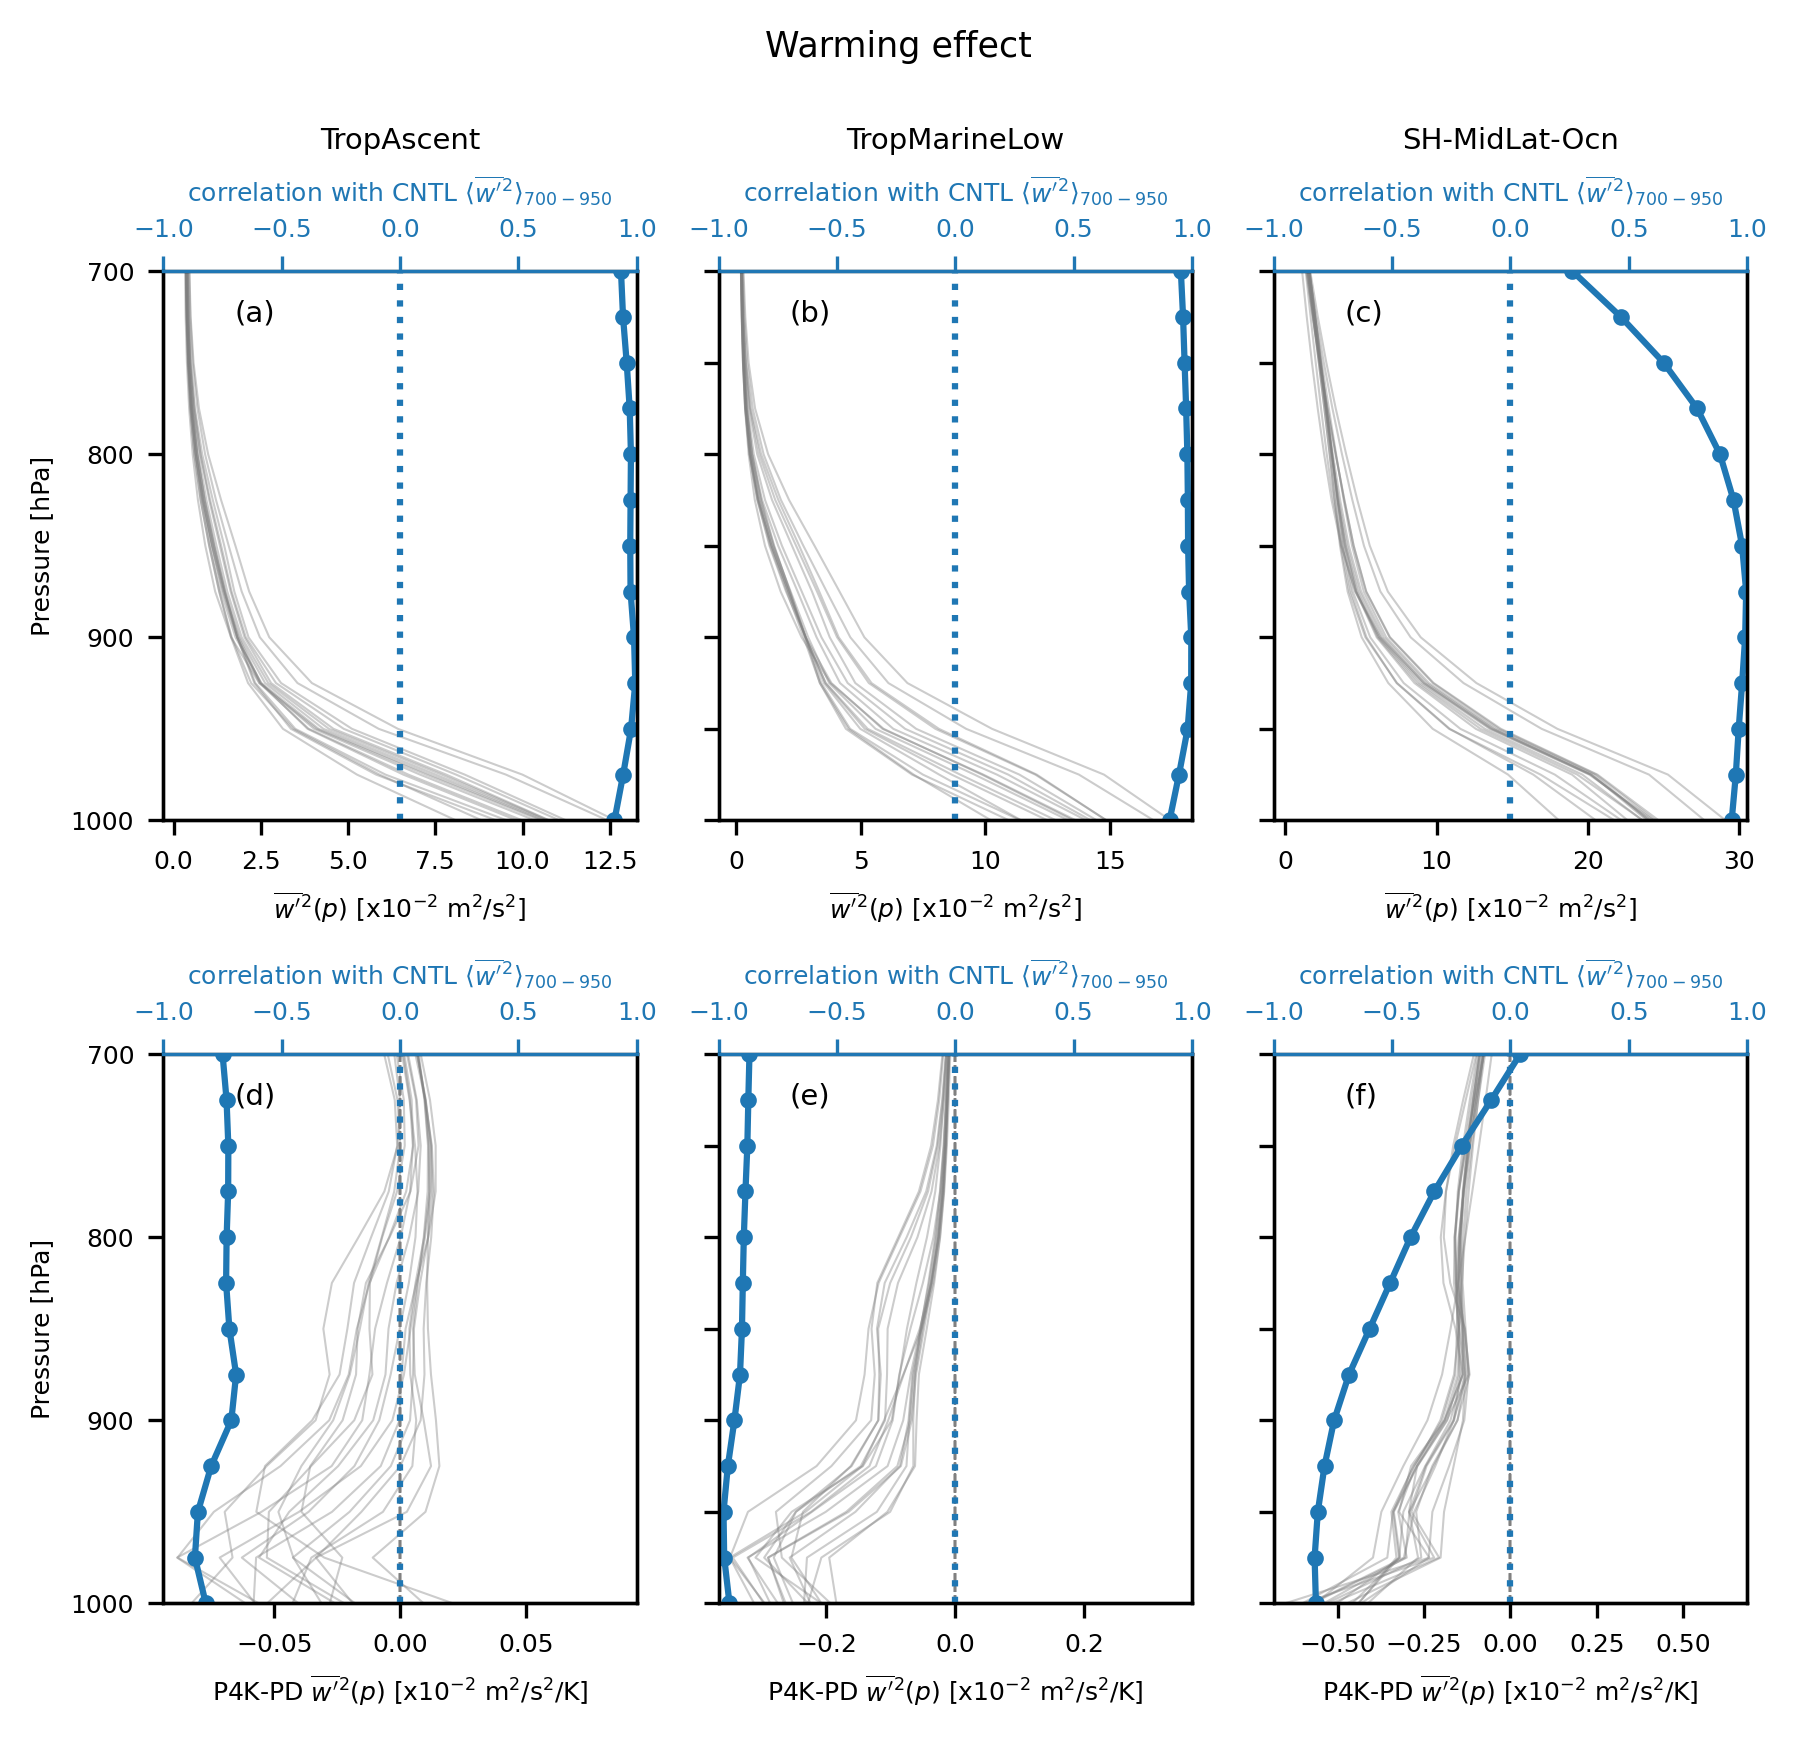

In [37]:
importlib.reload(misc) 

add_cor_line = True  # add correlation line using the upper x axis? 

lev1 = 100000
lev2 = 65000 

fbk_datasource = 'CRK_tau' 
_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)

regimes_plot_here = ['TropAscent','TropMarineLow','SH-MidLat-Ocn'] 

tag = 'Warming effect'
# tag = 'Aerosol effect'

if tag == 'Aerosol effect': 
    dics_test = dics_aci_state
if tag == 'Warming effect': 
    dics_test = dics_fbk_state 

var_test = 'WP2_CLUBB'

var_test_unit, var_test_scale, var_test_label = misc.get_var_unit(var_test) 

for var_here in [
    'WP2_CLUBB',
]:
    print(f'Doing var_here = {var_here}...')
    var_unit, scale, var_label = misc.get_var_unit(var_here) 

    # reset var_label if var_here =='WP2_CLUBB'
    if var_here == 'WP2_CLUBB': 
        var_label = r'$\overline{{w}^{\prime}}^{2}(p)$' 

    mpl.rcParams['font.size'] = 7
    mpl.rcParams['axes.labelsize'] = 6
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 7

    nrow = 2
    ncol = len(regimes_plot_here) 
    fig = plt.figure(figsize=(ncol*2,nrow*3),dpi=300) 
    plt.suptitle(tag, y=0.95) 

    df_cloud_peak_lev = pd.DataFrame() # Dataframe to save cloud peak levels

    for iregime,regime1 in enumerate(regimes_plot_here): 
        
        ax1 = fig.add_subplot(nrow,ncol,iregime+1) 
        ax2 = fig.add_subplot(nrow,ncol,iregime+ncol+1)   
        
        XX0 = [] 
        XX = []
        YY0 = []
        YY = [] 
        ZZ0 = [] 
        ZZ1 = []
        for case in list(dics_test[var_here].keys())[:]: 

            data1 = dics_test[var_here][case][var_here+'_pi_clim'][regime1+'_avg'] * scale
            data2 = dics_test[var_here][case][var_here+'_ab_clim'][regime1+'_avg'] * scale 
            data_ano = dics_test[var_here][case][var_here+'_ano_clim'][regime1+'_avg'] * scale

            data_lwp = dics_test[var_test][case][var_test+'_pi_clim'][regime1+'_avg'] * scale
            data_ano_lwp = dics_test[var_test][case][var_test+'_ano_clim'][regime1+'_avg'] * scale
            YY0.append(data_lwp)
            YY.append(data_ano_lwp) 

            data1 = data1.sel(plev=slice(lev1,lev2))
            data2 = data2.sel(plev=slice(lev1,lev2))
            data_ano = data_ano.sel(plev=slice(lev1,lev2)) 
            
            # ========== Find the level where CLDLIQ is peak in CTL and P4K =========== 
            CLDLIQ1 = dics_test['CLDLIQ'][case]['CLDLIQ_pi_clim'][regime1+'_avg'].sel(plev=slice(100000,70000))
            CLDLIQ2 = dics_test['CLDLIQ'][case]['CLDLIQ_ab_clim'][regime1+'_avg'].sel(plev=slice(100000,70000))

            level1_at_max = CLDLIQ1.where(CLDLIQ1 == CLDLIQ1.max(), drop=True).plev.item() 
            level2_at_max = CLDLIQ2.where(CLDLIQ2 == CLDLIQ2.max(), drop=True).plev.item() 
            level_at_max = np.mean([level1_at_max, level2_at_max])            
            df_cloud_peak_lev.loc[case,regime1] = level_at_max 

            lev = data1.plev
            
            XX0.append(data1) 
            XX.append(data_ano)

            a1 = 0.4
            
            # # Test specific cases 
            # c1=None
            # ax1.plot(data1,lev,label=case,lw=0.5,c=c1,alpha=a1)
            # ax2.plot(data_ano, lev, label=case,lw=0.5,c=c1,alpha=a1) 
            
            c1 = 'grey' 
            ax1.plot(data1,lev,label='CTL',lw=0.5,c=c1,alpha=a1)
            # ax1.plot(data2,lev,label='P4K',lw=0.5,c=c1,alpha=a1,ls='-.')  
            ax2.plot(data_ano, lev, label='P4K-CTL',lw=0.5,c=c1,alpha=a1) 

            for ax in [ax1,ax2]: 
                ax.set_ylim((lev1,lev2+5000)) 
                ax.set_xlabel(var_label+' ['+var_unit+']')  
            
            ax1.set_title(regime1) 

            ax2.set_xlabel('P4K-PD '+var_label+' ['+var_unit+'/K]')  
            ax2.axvline(x=0,ls='--',c='grey',lw=0.5) 

        # # Test specific cases 
        # ax1.legend() 
        # ax2.legend() 

        # ======== set ax2's xlim as symmetric =========================
        vmax = np.max([abs(ax2.get_xlim()[0]),abs(ax2.get_xlim()[1])])
        vmin = -1.*vmax 
        ax2.set_xlim((vmin,vmax)) 

        # ======= set ax1's xlim as symmetric if ax1 includes pos and neg 
        if ax1.get_xlim()[0]*ax1.get_xlim()[1] < 0 and abs(ax1.get_xlim()[0]) > 0.1 * abs(ax1.get_xlim()[1]):  
            vmax = np.max([abs(ax1.get_xlim()[0]),abs(ax1.get_xlim()[1])])
            vmin = -1.*vmax 
            ax1.set_xlim((vmin,vmax)) 

            ax1.axvline(x=0,ls='--',c='black')

        # # ======== Scientific format of x ticks ========================
        # from matplotlib.ticker import ScalarFormatter as stick 
        # pow_lims = (-2,3)
        # for ax in [ax1,ax2]: 
        #     ax.locator_params(axis='x',nbins=6)
        #     ticks = stick(useMathText=True)
        #     ticks.set_powerlimits(pow_lims)
        #     ax.xaxis.set_major_formatter(ticks)
        #     # Increase fontsize for ticklabels
        #     ax.tick_params(axis='both')
        #     # ax.xaxis.get_offset_text().set_size(fontsizes['ticks'])

        # =========== Add ensemble-mean max cloud peak for reference ================== 
        zz = df_cloud_peak_lev[regime1].mean()
        df_cloud_peak_lev.loc['EnsMean',regime1] = zz 
    
        level_here = 70000   
        level_offset = 25000   

        level_here_2 = level_here + level_offset
        # ax1.axhspan(level_here_2, level_here, facecolor='tab:blue',alpha=0.2) # for ERFaci 
        # ax2.axhspan(level_here_2, level_here, facecolor='tab:blue',alpha=0.2) # for ERFaci 
        
        print(tag, level_here, level_here_2) 

        # ----- Use cloud peak to get vertical average for var_test in each case 
        if len(data_lwp.shape) == 1: 
            YY0 = []
            YY = []
            for case in list(dics_test[var_here].keys())[:]:            
                
                data_lwp1 = dics_test[var_test][case][var_test+'_pi_clim'][regime1+'_avg'] * scale
                data_ano_lwp1 = dics_test[var_test][case][var_test+'_ano_clim'][regime1+'_avg'] * scale
                
                data_lwp1 = data_lwp1.sel(plev=slice(level_here_2, level_here)).mean(dim='plev')
                data_ano_lwp1 = data_ano_lwp1.sel(plev=slice(level_here_2, level_here)).mean(dim='plev') 

                YY0.append(data_lwp1) 
                YY.append(data_ano_lwp1) 
      
        # # ====================================================================
        # # Add ensemble mean
        # # ====================================================================
        # ax1.plot(np.array(XX0).mean(axis=0),lev,label='CTL',lw=2,c='black',alpha=a1)
        # ax2.plot(np.array(XX).mean(axis=0), lev, label='P4K-CTL',lw=2,c='black',alpha=a1) 

        # # ====================================================================
        # Add order of subplot to upper left corner
        # # ====================================================================
        xpos = 0.15
        ypos = 0.95 
        annotation = '(' + string.ascii_lowercase[iregime] + ')'  # Generate (a), (b), (c), ...
        ax1.text(xpos, ypos, annotation, transform=ax1.transAxes,
                verticalalignment='top', 
                # bbox=dict(facecolor='white', alpha=0.5)
                )
        
        annotation = '(' + string.ascii_lowercase[iregime+ncol] + ')'  # Generate (a), (b), (c), ...
        ax2.text(xpos, ypos, annotation, transform=ax2.transAxes,
                verticalalignment='top', 
                # bbox=dict(facecolor='white', alpha=0.5)
                )
    
        
        if iregime == 0: 
            
            if lev2 < 65000: 
                yticks = [100000, 90000, 80000, 70000, 60000, 50000, 40000, 30000, 20000, 10000]
                yticklabels = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100]   
            else: 
                yticks = [100000, 90000, 80000, 70000]
                yticklabels = [1000, 900, 800, 700]

            ax1.set_yticks(yticks)
            ax2.set_yticks(yticks)
            ax1.set_yticklabels(yticklabels) 
            ax2.set_yticklabels(yticklabels) 

            ax1.set_ylabel('Pressure [hPa]')
            ax2.set_ylabel('Pressure [hPa]') 
        else:
            ax1.set_yticklabels([]) 
            ax2.set_yticklabels([]) 

        if add_cor_line: 
            # ====================================================================
            # correlation between data at each level and LWP_LS
            # ====================================================================

            xxa0 = np.array(XX0).transpose((1,0))
            yya0 = np.array(YY0) 
            correlations = np.corrcoef(xxa0, yya0) 
            datap0 = correlations[:-1, -1] 

            xxa = np.array(XX0).transpose((1,0))
            # xxa = np.array(XX).transpose((1,0))
            yya = np.array(YY) 
            correlations = np.corrcoef(xxa, yya) 
            datap = correlations[:-1, -1] 
            
            ax4 = ax2.twiny() 
            ax3 = ax1.twiny() 

            ax3.plot(datap0,lev,ls='-',marker='o',ms=3)
            ax4.plot(datap,lev,ls='-',marker='o',ms=3)

            for ax in [ax3,ax4]: 
                ax.set_ylim((lev1,lev2+5000)) 
                ax.set_xlim((-1,1))
                ax.axvline(x=0,color='tab:blue',ls=':')
                # ax.axvline(x=-0.5,color='tab:blue',ls=':')
                # ax.axvline(x=0.5,color='tab:blue',ls=':')  
                ax.spines['top'].set_color('tab:blue')  # Set color to red, you can choose any color you prefer
                ax.tick_params(axis='x', colors='tab:blue') 

            # ax3.set_xlabel('correlation with mean-state '+var_test_label+'\n[dashed: '+var_test_label+'<0;solid: '+var_test_label+'>0]',color='tab:blue') 
            # if np.array_equal(xxa,xxa0):  
            #     ax4.set_xlabel('correlation with mean-state '+var_test_label+'\n[dashed: '+var_test_label+'<0;solid: '+var_test_label+'>0]',color='tab:blue') 
            # else: 
            #     ax4.set_xlabel('correlation with $\Delta$'+var_test_label+'\n[dashed: $\Delta$'+var_test_label+'<0;solid: $\Delta$'+var_test_label+'>0]',color='tab:blue')

            p_intervals = str(int(700))+'-'+str(int(950))  
            ax3.set_xlabel(rf'correlation with CNTL $\langle${var_test_label}$\rangle_{{{p_intervals}}}$',color='tab:blue') 
            if np.array_equal(xxa,xxa0):  
                ax4.set_xlabel(rf'correlation with CNTL $\langle${var_test_label}$\rangle_{{{p_intervals}}}$',color='tab:blue') 
            else: 
                ax4.set_xlabel(rf'correlation with P4K-PD $\langle${var_test_label}$\rangle_{{{p_intervals}}}$',color='tab:blue') 


        # # Add reference lines
        # for ax in [ax1,ax2]: 
        #     for ypos in [85000, 95000]:
        #         ax.axhline(y=ypos, ls='--',c='black',lw=0.5) 
            
    fig.tight_layout(rect=[0,0,1,0.95]) 

    # display(df_cloud_peak_lev)



## ONLY wp2 plot difference (Figure 4a-c)

Doing var_here = CLDLIQ...
Warming effect 70000 95000
Warming effect 70000 95000
Warming effect 70000 95000


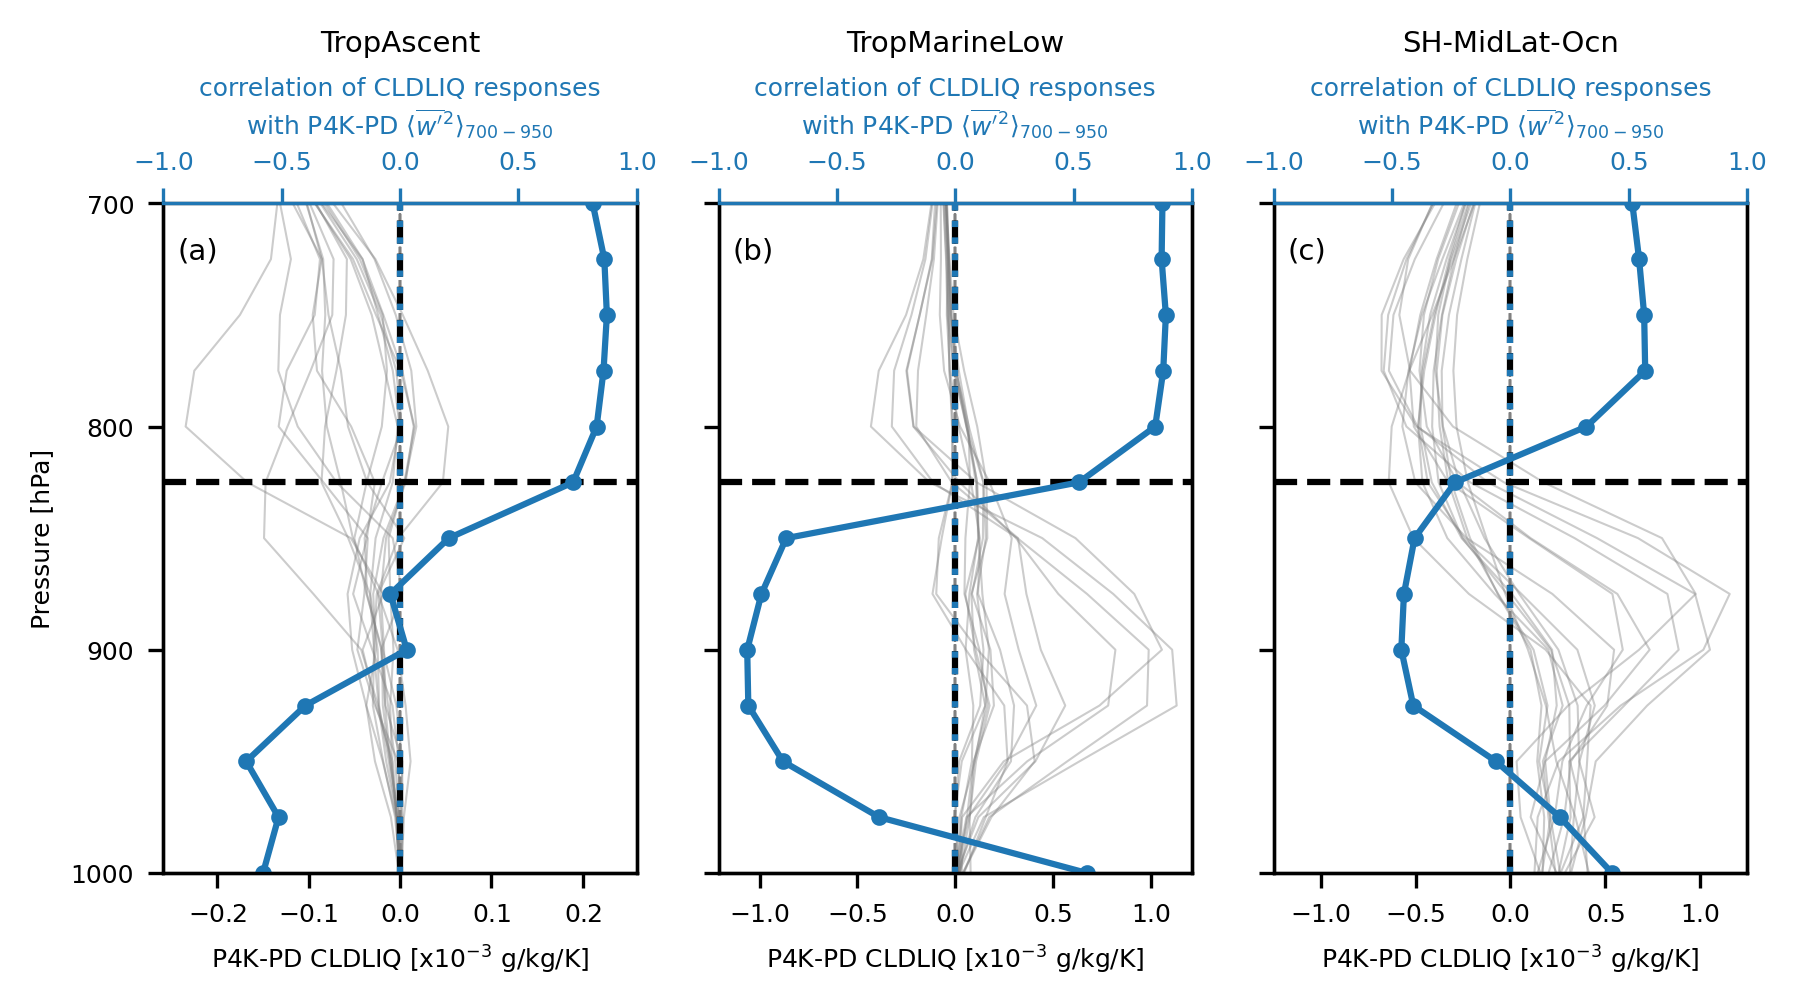

In [40]:
importlib.reload(misc) 

add_cor_line = True  # add correlation line using the upper x axis? 

lev1 = 100000
lev2 = 65000 

fbk_datasource = 'CRK_tau' 
_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)

regimes_plot_here = ['TropAscent','TropMarineLow','SH-MidLat-Ocn'] 

tag = 'Warming effect'
# tag = 'Aerosol effect'

if tag == 'Aerosol effect': 
    dics_test = dics_aci_state
if tag == 'Warming effect': 
    dics_test = dics_fbk_state 

var_test = 'WP2_CLUBB'
var_test_unit, var_test_scale, var_test_label = misc.get_var_unit(var_test) 
if var_test == 'WP2_CLUBB':
    var_test_label = r'$\langle\overline{{w}^{\prime}}^{2}\rangle_{700-950}$'

for var_here in [
    'CLDLIQ',
]: 
    print(f'Doing var_here = {var_here}...')
    var_unit, scale, var_label = misc.get_var_unit(var_here) 
    
    mpl.rcParams['font.size'] = 7
    mpl.rcParams['axes.labelsize'] = 6
    mpl.rcParams['xtick.labelsize'] = 6
    mpl.rcParams['ytick.labelsize'] = 6
    mpl.rcParams['axes.titlesize'] = 7

    nrow = 2
    ncol = len(regimes_plot_here) 
    fig = plt.figure(figsize=(ncol*2,nrow*3),dpi=300) 
    # plt.suptitle(tag, y=0.95) 

    df_cloud_peak_lev = pd.DataFrame() # Dataframe to save cloud peak levels

    for iregime,regime1 in enumerate(regimes_plot_here): 
        
        ax1 = fig.add_subplot(nrow,ncol,iregime+1) 
        
        XX0 = [] 
        XX = []
        YY0 = []
        YY = [] 
        ZZ0 = [] 
        ZZ1 = []
        for case in list(dics_test[var_here].keys())[:]: 
        
            data1 = dics_test[var_here][case][var_here+'_pi_clim'][regime1+'_avg'] * scale
            data2 = dics_test[var_here][case][var_here+'_ab_clim'][regime1+'_avg'] * scale 
            data_ano = dics_test[var_here][case][var_here+'_ano_clim'][regime1+'_avg'] * scale

            data_lwp = dics_test[var_test][case][var_test+'_pi_clim'][regime1+'_avg'] * scale
            data_ano_lwp = dics_test[var_test][case][var_test+'_ano_clim'][regime1+'_avg'] * scale
            YY0.append(data_lwp)
            YY.append(data_ano_lwp) 

            data1 = data1.sel(plev=slice(lev1,lev2))
            data2 = data2.sel(plev=slice(lev1,lev2))
            data_ano = data_ano.sel(plev=slice(lev1,lev2)) 
            
            # ========== Find the level where CLDLIQ is peak in CTL and P4K =========== 
            CLDLIQ1 = dics_test['CLDLIQ'][case]['CLDLIQ_pi_clim'][regime1+'_avg'].sel(plev=slice(100000,70000))
            CLDLIQ2 = dics_test['CLDLIQ'][case]['CLDLIQ_ab_clim'][regime1+'_avg'].sel(plev=slice(100000,70000))

            level1_at_max = CLDLIQ1.where(CLDLIQ1 == CLDLIQ1.max(), drop=True).plev.item() 
            level2_at_max = CLDLIQ2.where(CLDLIQ2 == CLDLIQ2.max(), drop=True).plev.item() 
            level_at_max = np.mean([level1_at_max, level2_at_max])            
            df_cloud_peak_lev.loc[case,regime1] = level_at_max 

            lev = data1.plev
            
            XX0.append(data1) 
            XX.append(data_ano)

            a1 = 0.4
            c1 = 'grey' 
            ax1.plot(data_ano, lev, label='P4K-CTL',lw=0.5,c=c1,alpha=a1) 

            for ax in [ax1]: 
                ax.set_ylim((lev1,lev2+5000)) 
                ax.set_xlabel(var_label+' ['+var_unit+']')  
            
            ax1.set_title(regime1) 

            ax1.set_xlabel('P4K-PD '+var_label+' ['+var_unit+'/K]')  
            ax1.axvline(x=0,ls='--',c='grey',lw=0.5) 

        # ======== set ax2's xlim as symmetric =========================
        vmax = np.max([abs(ax1.get_xlim()[0]),abs(ax1.get_xlim()[1])])
        vmin = -1.*vmax 
        ax1.set_xlim((vmin,vmax)) 

        # ======= set ax1's xlim as symmetric if ax1 includes pos and neg 
        if ax1.get_xlim()[0]*ax1.get_xlim()[1] < 0 and abs(ax1.get_xlim()[0]) > 0.1 * abs(ax1.get_xlim()[1]):  
            vmax = np.max([abs(ax1.get_xlim()[0]),abs(ax1.get_xlim()[1])])
            vmin = -1.*vmax 
            ax1.set_xlim((vmin,vmax)) 

            ax1.axvline(x=0,ls='--',c='black')

        ax1.axhline(y=82500, ls='--',c='black')

        # ======== Scientific format of x ticks ========================
        from matplotlib.ticker import ScalarFormatter as stick 
        pow_lims = (-2,3)
        for ax in [ax1]: 
            ax.locator_params(axis='x',nbins=6)
            ticks = stick(useMathText=True)
            ticks.set_powerlimits(pow_lims)
            ax.xaxis.set_major_formatter(ticks)
            # Increase fontsize for ticklabels
            ax.tick_params(axis='both')
            # ax.xaxis.get_offset_text().set_size(fontsizes['ticks'])

        # =========== Add ensemble-mean max cloud peak for reference ================== 
        zz = df_cloud_peak_lev[regime1].mean()
        df_cloud_peak_lev.loc['EnsMean',regime1] = zz 
    
        level_here = 70000   
        level_offset = 25000   

        level_here_2 = level_here + level_offset
        # ax1.axhspan(level_here_2, level_here, facecolor='tab:blue',alpha=0.2) # for ERFaci 
        # ax2.axhspan(level_here_2, level_here, facecolor='tab:blue',alpha=0.2) # for ERFaci 
        
        print(tag, level_here, level_here_2) 

        # ----- Use cloud peak to get vertical average for var_test in each case 
        if len(data_lwp.shape) == 1: 
            YY0 = []
            YY = []
            for case in list(dics_test[var_here].keys())[:]:            
                
                data_lwp1 = dics_test[var_test][case][var_test+'_pi_clim'][regime1+'_avg'] * scale
                data_ano_lwp1 = dics_test[var_test][case][var_test+'_ano_clim'][regime1+'_avg'] * scale
                
                data_lwp1 = data_lwp1.sel(plev=slice(level_here_2, level_here)).mean(dim='plev')
                data_ano_lwp1 = data_ano_lwp1.sel(plev=slice(level_here_2, level_here)).mean(dim='plev') 

                YY0.append(data_lwp1) 
                YY.append(data_ano_lwp1) 
      
        # # ====================================================================
        # # Add ensemble mean
        # # ====================================================================
        # ax1.plot(np.array(XX0).mean(axis=0),lev,label='CTL',lw=2,c='black',alpha=a1)
        # ax2.plot(np.array(XX).mean(axis=0), lev, label='P4K-CTL',lw=2,c='black',alpha=a1) 

        # Add order of subplot to upper left corner
        xpos = 0.03
        ypos = 0.95 
        annotation = '(' + string.ascii_lowercase[iregime] + ')'  # Generate (a), (b), (c), ...
        ax1.text(xpos, ypos, annotation, transform=ax1.transAxes,
                verticalalignment='top', 
                # bbox=dict(facecolor='white', alpha=0.5)
                )
        
        yticks = [100000, 90000, 80000, 70000]
        ax1.set_yticks(yticks)
        
        if iregime == 0: 
            yticklabels = [1000, 900, 800, 700]
            ax1.set_yticklabels(yticklabels) 

            ax1.set_ylabel('Pressure [hPa]')
        else:
            ax1.set_yticklabels([]) 

        if add_cor_line: 
            # ====================================================================
            # correlation between data at each level and LWP_LS
            # ====================================================================

            xxa0 = np.array(XX0).transpose((1,0))

            xxa = np.array(XX).transpose((1,0))
            yya = np.array(YY) 
            correlations = np.corrcoef(xxa, yya) 
            datap = correlations[:-1, -1] 
            
            ax3 = ax1.twiny() 

            ax3.plot(datap,lev,ls='-',marker='o',ms=3)

            for ax in [ax3]: 
                ax.set_ylim((lev1,lev2+5000)) 
                ax.set_xlim((-1,1))
                ax.axvline(x=0,color='tab:blue',ls=':')
                # ax.axvline(x=-0.5,color='tab:blue',ls=':')
                # ax.axvline(x=0.5,color='tab:blue',ls=':')  
                ax.spines['top'].set_color('tab:blue')  # Set color to red, you can choose any color you prefer
                ax.tick_params(axis='x', colors='tab:blue') 

            if np.array_equal(xxa,xxa0):  
                ax3.set_xlabel('correlation of '+var_here+' responses\nwith mean-state '+var_test_label,color='tab:blue') 
            else: 
                ax3.set_xlabel('correlation of '+var_here+' responses\nwith P4K-PD '+var_test_label,color='tab:blue') 


    fig.tight_layout(rect=[0,0,1,0.95]) 

    # display(df_cloud_peak_lev)



## CLDLIQ budget profiles (Figure S10)

Doing var_here = DPDLFLIQ...


Doing var_here = ZMDLIQ...
Doing var_here = RCMTEND_CLUBB...
Doing var_here = MPDLIQ...
Doing var_here = DPDLFLIQ...
Doing var_here = ZMDLIQ...
Doing var_here = RCMTEND_CLUBB...
Doing var_here = MPDLIQ...


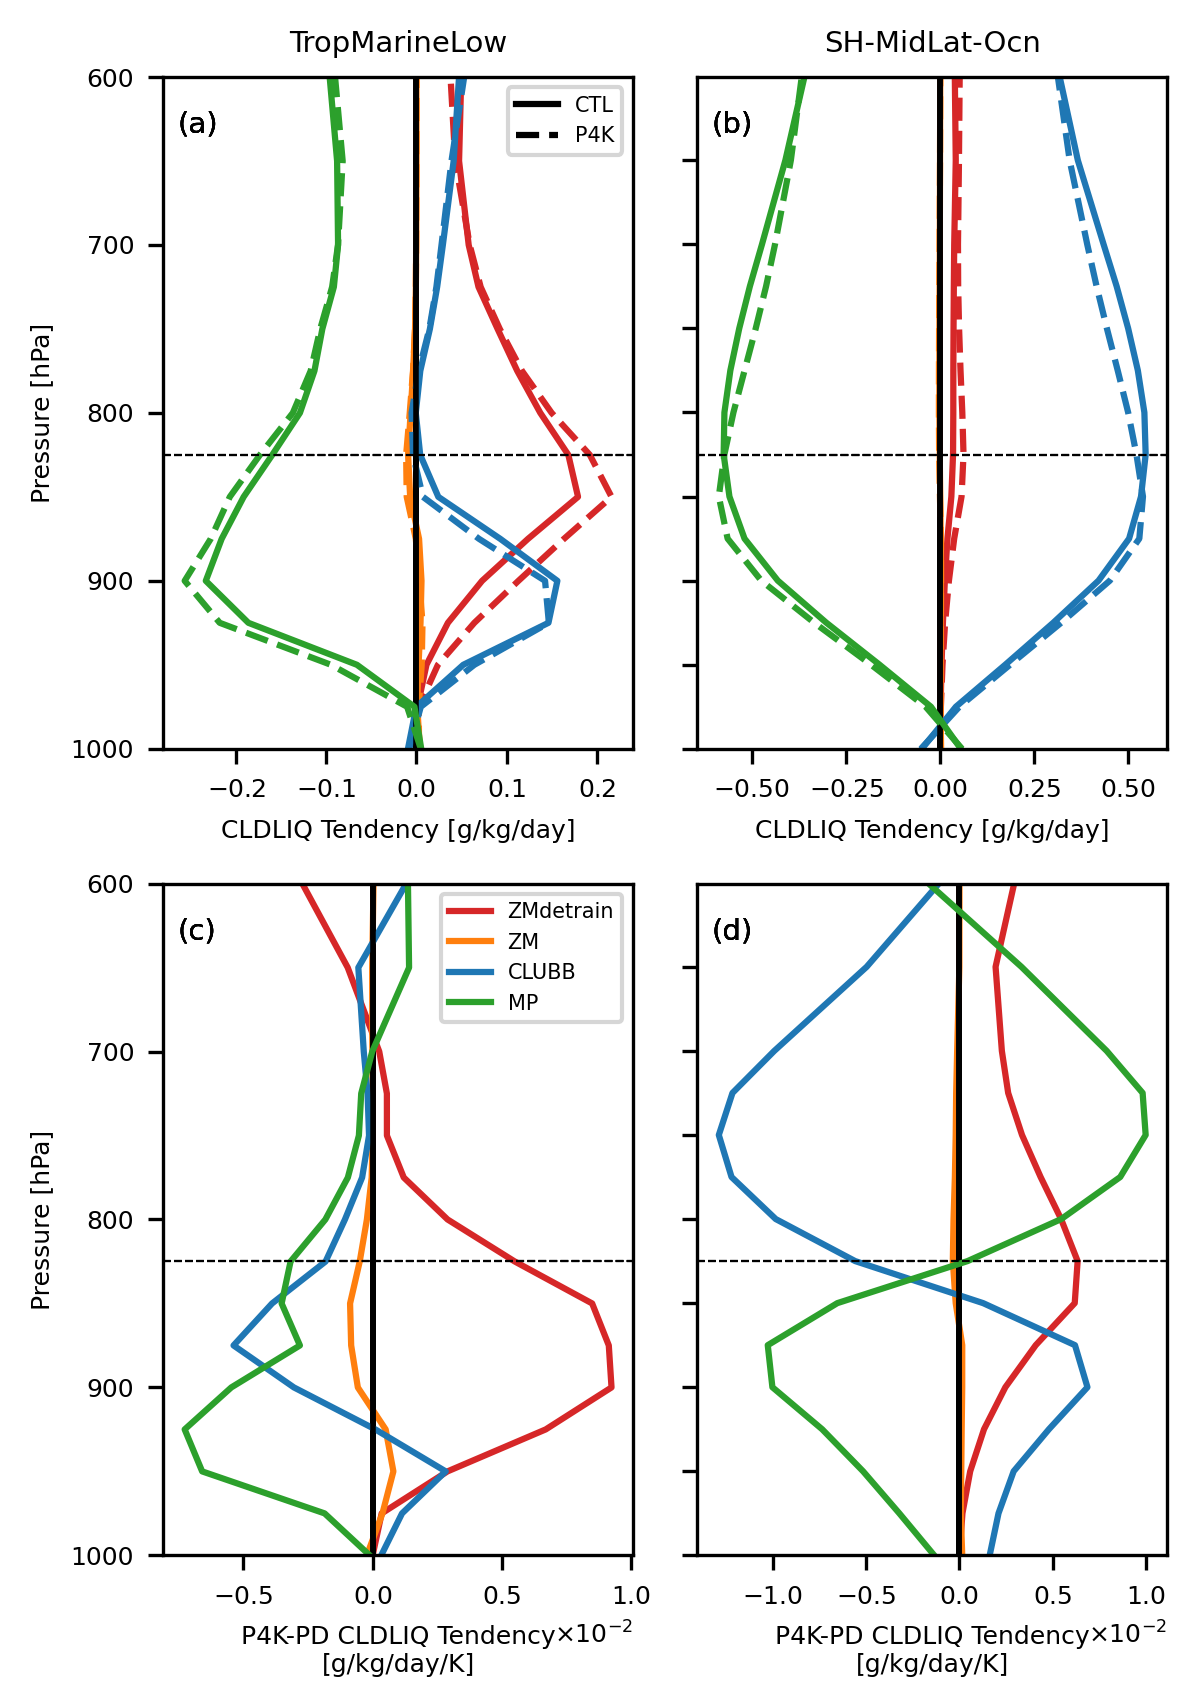

In [41]:
importlib.reload(misc) 
cpair = 1.00464e3 #J/(kg K)

with_CLDLIQ = False 

lev1 = 100000 #1000 #850
lev2 = 60000 # 600 # 400 

var_test = 'LWP_LS'
var_test_unit, var_test_scale, var_test_label = misc.get_var_unit(var_test) 

var_ref = 'CLDLIQ' 
var_ref_unit, var_ref_scale, var_ref_label = misc.get_var_unit(var_ref) 

var_tag = 'CLDLIQ'  # Use CLDLIQ budgets
# var_tag = 'T'
# var_tag = 'Q'  

if var_tag == 'Q': 
    var_here_A = [
            ['ZMDQ','tab:orange'],  
            ['RVMTEND_CLUBB', 'tab:blue'], 
            ['MPDQ', 'tab:green'],  
           # ['PTEQ', 'tab:grey'], 
        ]
elif var_tag == 'T': 
    var_here_A = [
        ['ZMDT', 'tab:orange'],
        ['TTEND_CLUBB', 'tab:blue'],
        ['MPDT', 'tab:green'],
        # ['QRL', 'blue'],
        # ['QRS','red'], 
        # ['DYNT', 'purple'],   
    ]
elif var_tag == 'CLDLIQ':
    var_here_A = [
        ['DPDLFLIQ', 'tab:red'], 
        ['ZMDLIQ', 'tab:orange'], 
        ['RCMTEND_CLUBB', 'tab:blue'], 
        ['MPDLIQ', 'tab:green'], 
        # ['PTECLDLIQ', 'tab:grey'], 
    ] 
elif var_tag == 'CLDICE':
    var_here_A = [
        ['DPDLFICE', 'tab:red'], 
        ['ZMDICE', 'tab:orange'], 
        ['RIMTEND_CLUBB', 'tab:blue'], 
        ['MPDICE', 'tab:green'], 
        # ['PTECLDICE', 'tab:grey'], 
    ] 

# =========================================================================== 
fbk_datasource = 'CRK_tau' 
_, Vars_fbk = misc.get_fbk_method_info(fbk_datasource)

regimes_plot_here = ['TropMarineLow','SH-MidLat-Ocn'] 

tag = 'Warming effect'
# tag = 'Aerosol effect'

if tag == 'Aerosol effect': 
    dics_test = dics_aci_state
if tag == 'Warming effect': 
    dics_test = dics_fbk_state 


nrow = 2
ncol = len(regimes_plot_here) 
fig = plt.figure(figsize=(ncol*2,nrow*3),dpi=300) 

if ncol == 1: 
    nrow = 2
    ncol = len(regimes_plot_here) 
    fig = plt.figure(figsize=(3,6),dpi=300) 

# plt.suptitle(tag, y=0.95)

mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['axes.titlesize'] = 7

for iregime,regime1 in enumerate(regimes_plot_here): 
    
    ax1 = fig.add_subplot(nrow,ncol,iregime+1) 
    ax2 = fig.add_subplot(nrow,ncol,iregime+ncol+1)
    if with_CLDLIQ:    
        ax1twiny = ax1.twiny() 
        ax2twiny = ax2.twiny() 

    for var_here,c_here in var_here_A:   
        print(f'Doing var_here = {var_here}...')
        var_unit, scale, var_label = misc.get_var_unit(var_here) 

        XX0 = [] 
        XX1 = [] 
        XX = []
        XX0_ref = []
        XX1_ref = []
        XXd_ref = []
        YY0 = []
        YY = [] 
        for case in list(dics_test['LWP_LS'].keys())[:]: 
            if var_here == 'DYNT': 
                ap = 'pi'
                data1 = -1 * (dics_test['ZMDT'][case]['ZMDT_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['TTEND_CLUBB'][case]['TTEND_CLUBB_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['MPDT'][case]['MPDT_'+ap+'_clim'][regime1+'_avg']/cpair + \
                    dics_test['QRL'][case]['QRL_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['QRS'][case]['QRS_'+ap+'_clim'][regime1+'_avg']) * scale 
                ap = 'ab' 
                data2 = -1 * (dics_test['ZMDT'][case]['ZMDT_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['TTEND_CLUBB'][case]['TTEND_CLUBB_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['MPDT'][case]['MPDT_'+ap+'_clim'][regime1+'_avg']/cpair + \
                    dics_test['QRL'][case]['QRL_'+ap+'_clim'][regime1+'_avg'] + \
                    dics_test['QRS'][case]['QRS_'+ap+'_clim'][regime1+'_avg']) * scale 
                avgtas = 4.3 
                data_ano = (data2 - data1)/avgtas                     
                    
            else: 
                data1 = dics_test[var_here][case][var_here+'_pi_clim'][regime1+'_avg'] * scale
                data2 = dics_test[var_here][case][var_here+'_ab_clim'][regime1+'_avg'] * scale 
                data_ano = dics_test[var_here][case][var_here+'_ano_clim'][regime1+'_avg'] * scale
            # print(f'var_here = {var_here}, data.shape = {data1.shape}') 

            data_lwp = dics_test[var_test][case][var_test+'_pi_clim'][regime1+'_avg'] * var_test_scale 
            data_ano_lwp = dics_test[var_test][case][var_test+'_ano_clim'][regime1+'_avg'] * var_test_scale 

            data1_CLDLIQ = dics_test[var_ref][case][var_ref+'_pi_clim'][regime1+'_avg'] * var_ref_scale
            data2_CLDLIQ = dics_test[var_ref][case][var_ref+'_ab_clim'][regime1+'_avg'] * var_ref_scale 
            data_dCLDLIQ = dics_test[var_ref][case][var_ref+'_ano_clim'][regime1+'_avg']*var_ref_scale 

            data1 = data1.sel(plev=slice(lev1,lev2))
            data2 = data2.sel(plev=slice(lev1,lev2))
            data_ano = data_ano.sel(plev=slice(lev1,lev2)) 
            data1_CLDLIQ = data1_CLDLIQ.sel(plev=slice(lev1,lev2))
            data2_CLDLIQ = data2_CLDLIQ.sel(plev=slice(lev1,lev2))
            data_dCLDLIQ = data_dCLDLIQ.sel(plev=slice(lev1,lev2)) 
            
            lev = data1.plev

            XX0.append(data1) 
            XX1.append(data2) 
            XX.append(data_ano)
            XX0_ref.append(data1_CLDLIQ)
            XX1_ref.append(data2_CLDLIQ) 
            XXd_ref.append(data_dCLDLIQ) 
            YY0.append(data_lwp) 
            YY.append(data_ano_lwp) 

            a1 = 0.4
            # c1 = 'grey' 
            c1 = c_here 
            # ax1.plot(data1,lev,label='_nolegend_',lw=0.5,c=c1,alpha=a1)
            # ax1.plot(data2,lev,label='_nolegend_',lw=0.5,c=c1,alpha=1.0, ls=':')   
            # ax2.plot(data_ano, lev, label='P4K-CTL',lw=0.5,c=c1,alpha=a1) 

            # if with_CLDLIQ and var_here == var_here_A[0][0]: 
            #     ax2twiny.plot(data_dCLDLIQ, lev, label='_nolegend_',lw=0.5,c='grey',alpha=a1) 

            for ax in [ax1,ax2]: 
                ax.set_ylim((lev1,lev2+50)) 
                ax.set_xlabel(var_tag+' Tendency'+' ['+var_unit+']')  

                ax.axvline(x=0,ls='-',c='black',lw=1.0)  
            
            ax1.set_title(regime1) 
            ax2.set_xlabel('P4K-PD '+var_tag+' Tendency'+'\n['+var_unit+'/K]')  
    
        if with_CLDLIQ: 
            ax2twiny.plot(np.array(XXd_ref).mean(axis=0), lev, label='_nolegend_', c='grey', lw=0.5, ls='-')  

            ax2twiny.axvline(x=0,ls='-',c='black',lw=0.5) 
            ax2twiny.set_xlabel('P4K-PD '+var_ref_label+' ['+var_ref_unit+'/K]',color='grey')  

            ax1twiny.plot(np.array(XX0_ref).mean(axis=0), lev, label='_nolegend_', c='grey',lw=0.5)
            ax1twiny.plot(np.array(XX1_ref).mean(axis=0), lev, label='_nolegend_', c='grey', lw=0.5, ls='--') 
            ax1twiny.set_xlabel(var_ref_label+' ['+var_ref_unit+']',color='grey')  

            ax2twiny.spines['top'].set_color('grey')  # Set color to red, you can choose any color you prefer
            ax2twiny.tick_params(axis='x', colors='grey') 
            ax1twiny.spines['top'].set_color('grey') 
            ax1twiny.tick_params(axis='x', colors='grey') 

        ## ==== Plot the ensemble mean of each process tendency ================= 
            
        xx0 = np.array(XX0).mean(axis=0) 
        xx0_std = np.array(XX0).std(axis=0) 
        La = ax1.plot(xx0, lev, label='CTL', c=c1) 
        # ax1.fill_betweenx(lev, xx0+xx0_std, xx0-xx0_std, label=regime1,color=colorsh[iregime], edgecolor='none', alpha=0.3)   

        xx0 = np.array(XX1).mean(axis=0) 
        xx0_std = np.array(XX1).std(axis=0) 
        Lb = ax1.plot(xx0, lev, label='P4K', c=c1, ls='--') 
        # ax1.fill_betweenx(lev, xx0+xx0_std, xx0-xx0_std, label=regime1,color=colorsh[iregime], edgecolor='none', alpha=0.3)   
    
        xx0 = np.array(XX).mean(axis=0) 
        xx0_std = np.array(XX).std(axis=0) 
        ax2.plot(xx0, lev, label=var_label, c=c1 ) 
        # ax2.fill_betweenx(lev, xx0+xx0_std, xx0-xx0_std, label=regime1,color=colorsh[iregime], edgecolor='none', alpha=0.3)   

        # ax1.plot(np.array(XX0).mean(axis=0), lev, label='CTL', c=c1) 
        # ax2.plot(np.array(XX).mean(axis=0), lev, label=var_label, c=c1)   
               
        # ======= Add order of subplot to upper left corner ============== 
        xpos = 0.03
        ypos = 0.95 
        annotation = '(' + string.ascii_lowercase[iregime] + ')'  # Generate (a), (b), (c), ...
        ax1.text(xpos, ypos, annotation, transform=ax1.transAxes,
                verticalalignment='top', 
                # bbox=dict(facecolor='white', alpha=0.5)
                )
        
        annotation = '(' + string.ascii_lowercase[iregime+ncol] + ')'  # Generate (a), (b), (c), ...
        ax2.text(xpos, ypos, annotation, transform=ax2.transAxes,
                verticalalignment='top', 
                # bbox=dict(facecolor='white', alpha=0.5)
                )
    
        if iregime == 0:
            # yticks = [100000, 90000, 80000, 70000, 60000, 50000, 40000, 30000, 20000]
            # yticklabels = [1000, 900, 800, 700, 600, 500, 400, 300, 200]  

            yticks = [100000, 90000, 80000, 70000, 60000]
            yticklabels = [1000, 900, 800, 700, 600]  

            ax1.set_yticks(yticks)
            ax1.set_yticklabels(yticklabels) 
            ax2.set_yticks(yticks)
            ax2.set_yticklabels(yticklabels) 

            ax1.set_ylabel('Pressure [hPa]')
            ax2.set_ylabel('Pressure [hPa]') 
        else:
            ax1.set_yticklabels([]) 
            ax2.set_yticklabels([]) 

        # ax2.axhline(y=70000, ls='--',c='grey') 
        # ax1.axhline(y=70000, ls='--',c='grey') 
            
        #  ======================== Use ScalarFormatter to set the ticks with orders of magnitude  ======================== 
        for ax in [ax1,ax2]: 
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True) 
            formatter.set_powerlimits((-2, 2))  # set the range of exponents to show
            ax.xaxis.set_major_formatter(formatter)
            # ax.get_xaxis().get_offset_text().set_position((1.3,0.8))  

            ax.axhline(y=82500, ls='--',c='black',lw=0.5)

    if iregime == 0:         
        ax2.legend(fontsize=5,loc='upper right') 
        legend1 = ax1.legend([La[0],Lb[0]],['CTL','P4K'],fontsize=5) 
        legend1.legendHandles[0].set_color('black')
        legend1.legendHandles[1].set_color('black')


    fig.tight_layout(rect=[0,0,1,0.95])


## Scatter plot check cloud feedback chain (Figure4d-h, FigureS9, FigureS11)


Plotting figure =  Fig4d-h



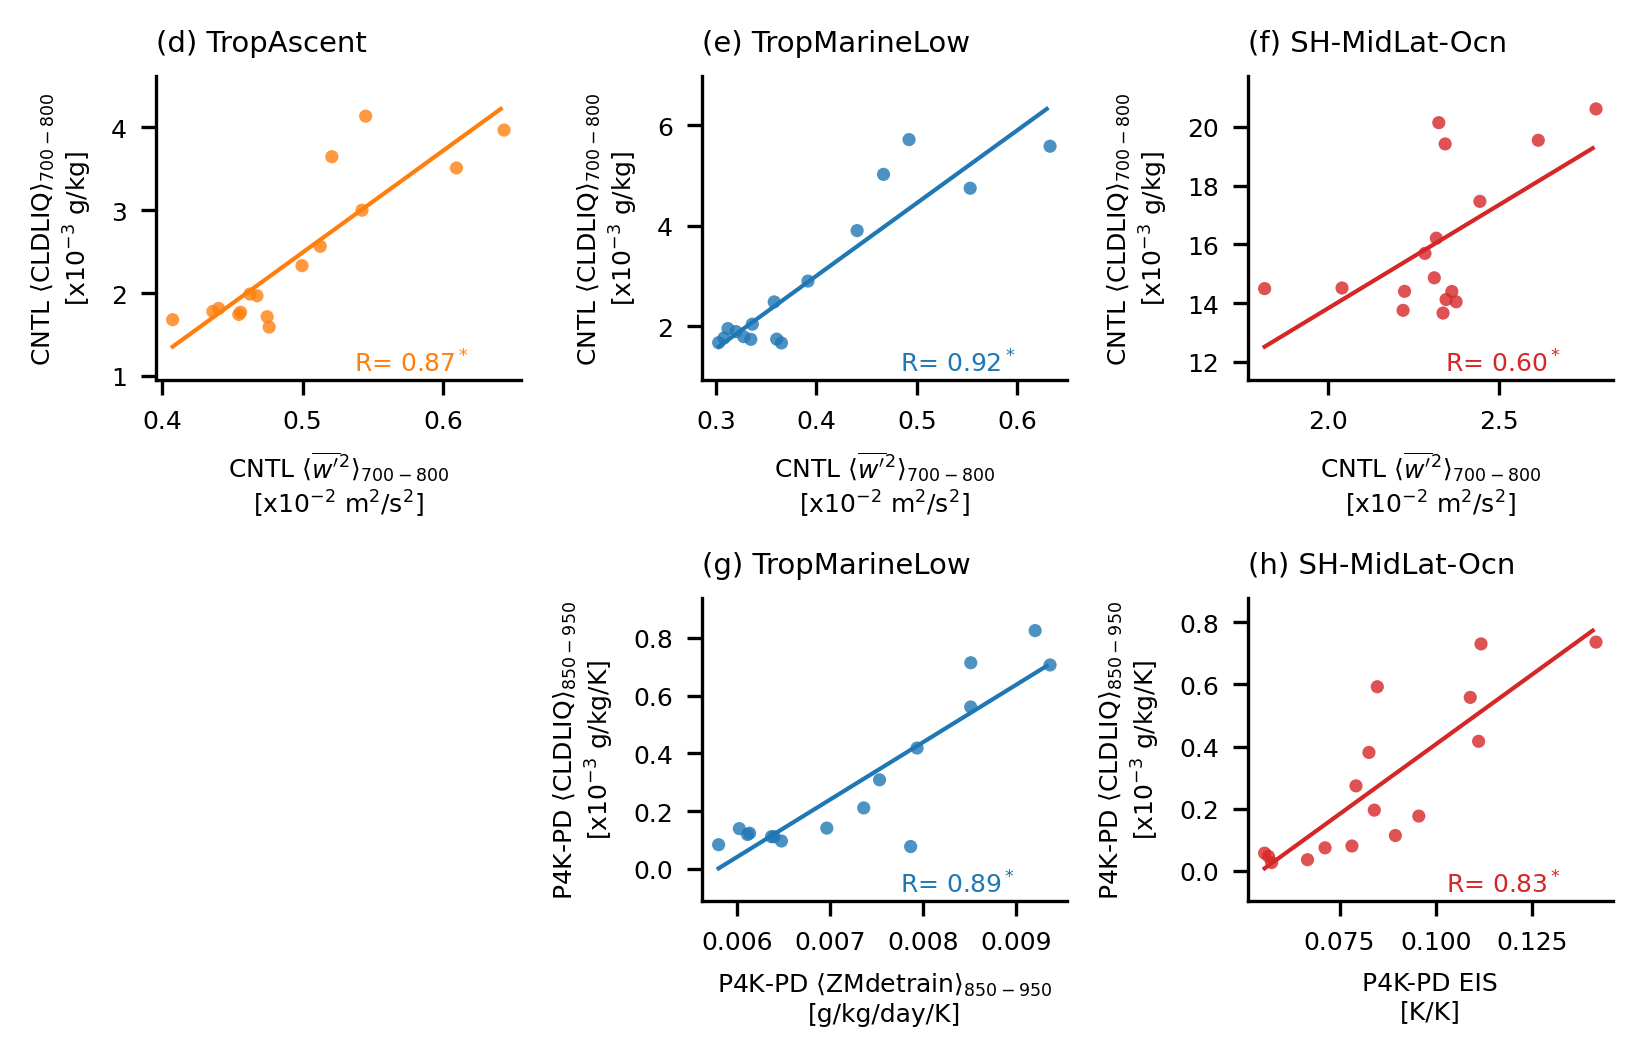


Plotting figure =  FigureS9



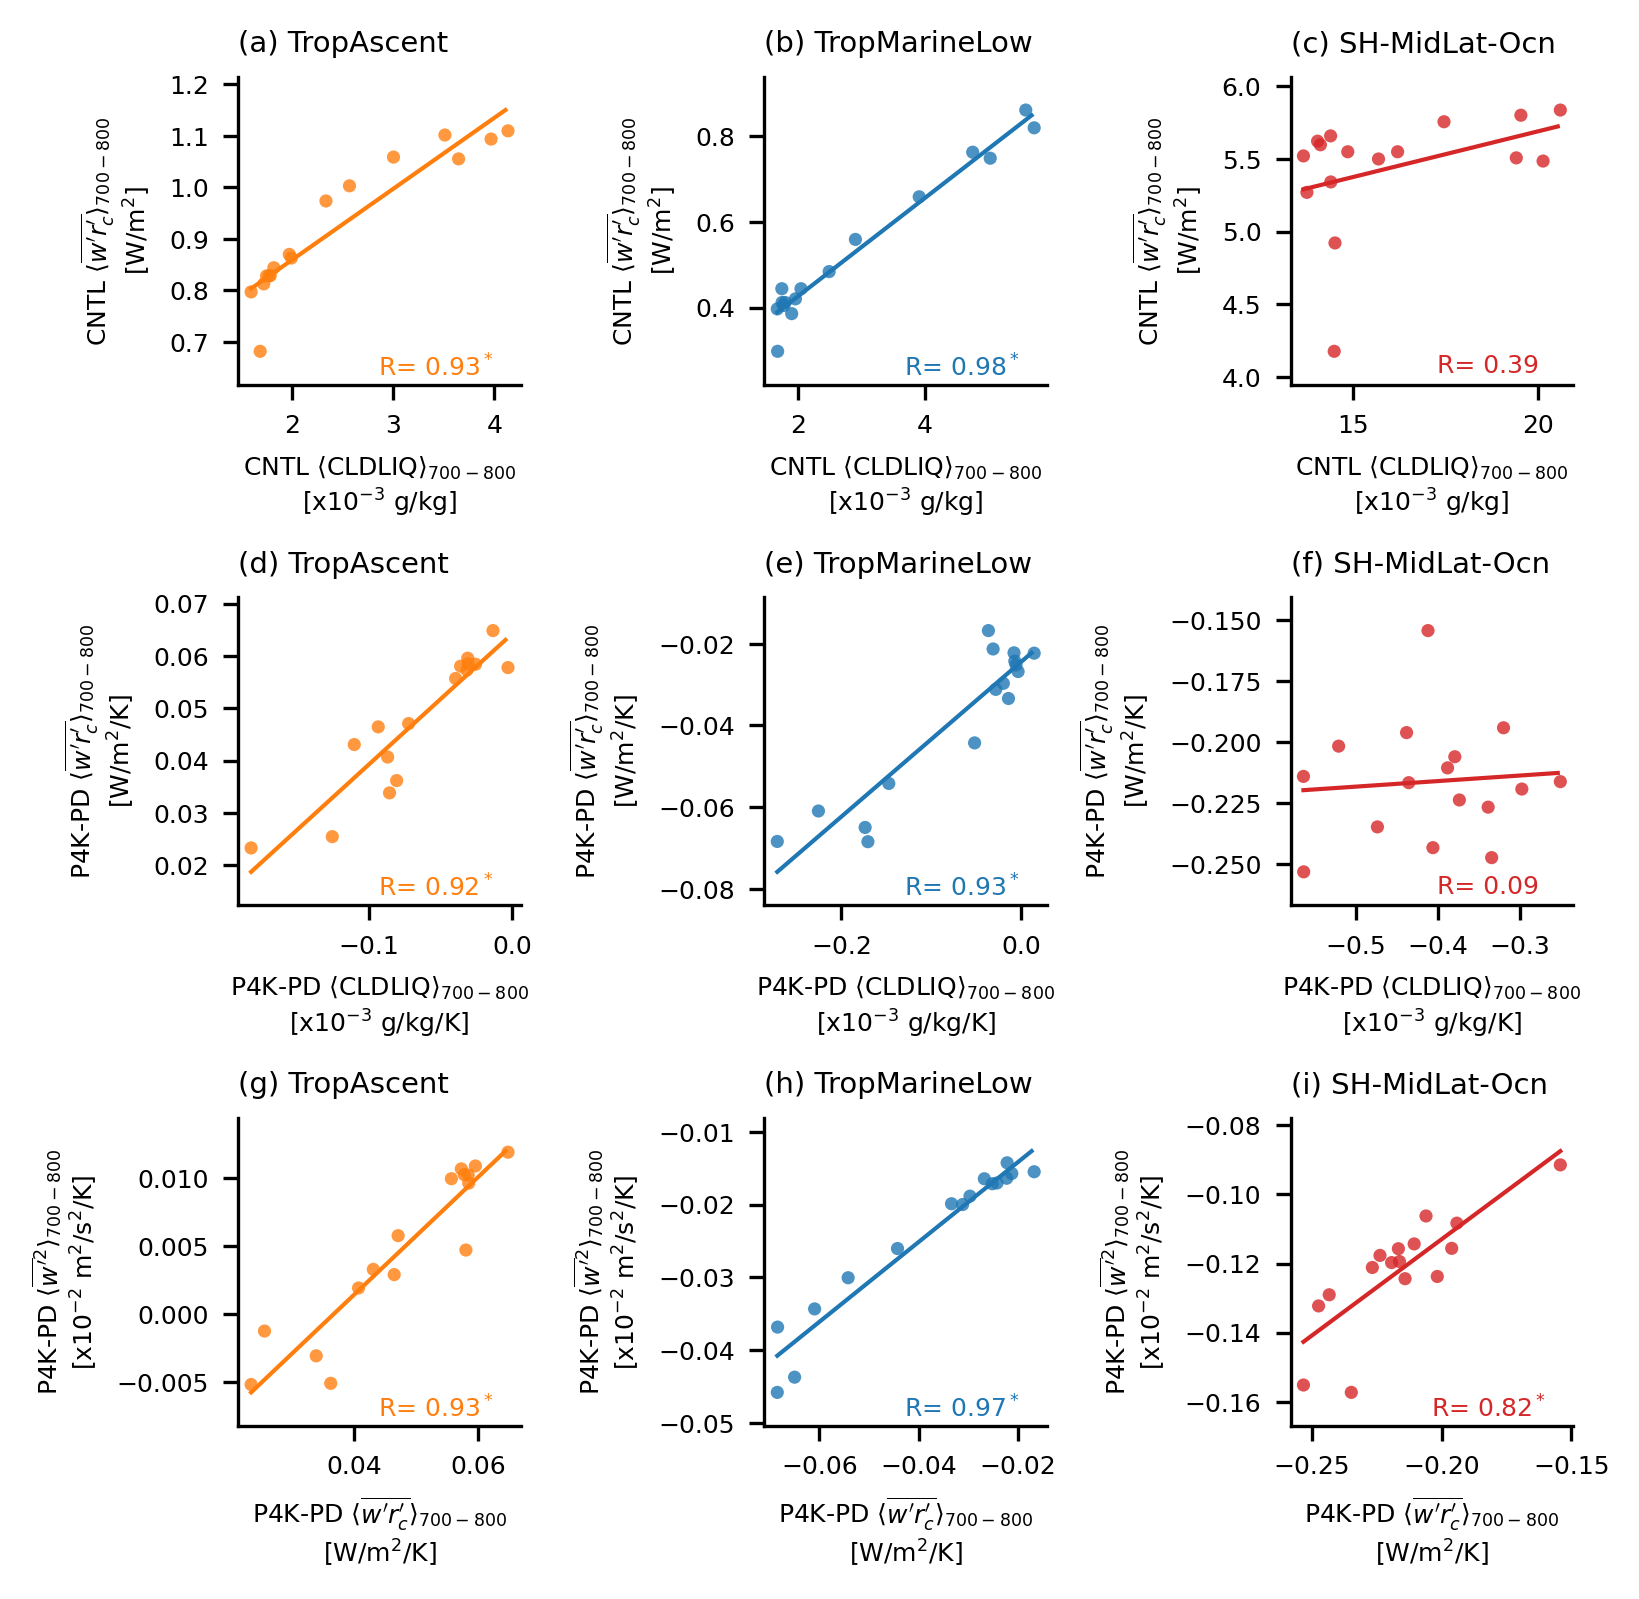


Plotting figure =  FigureS11



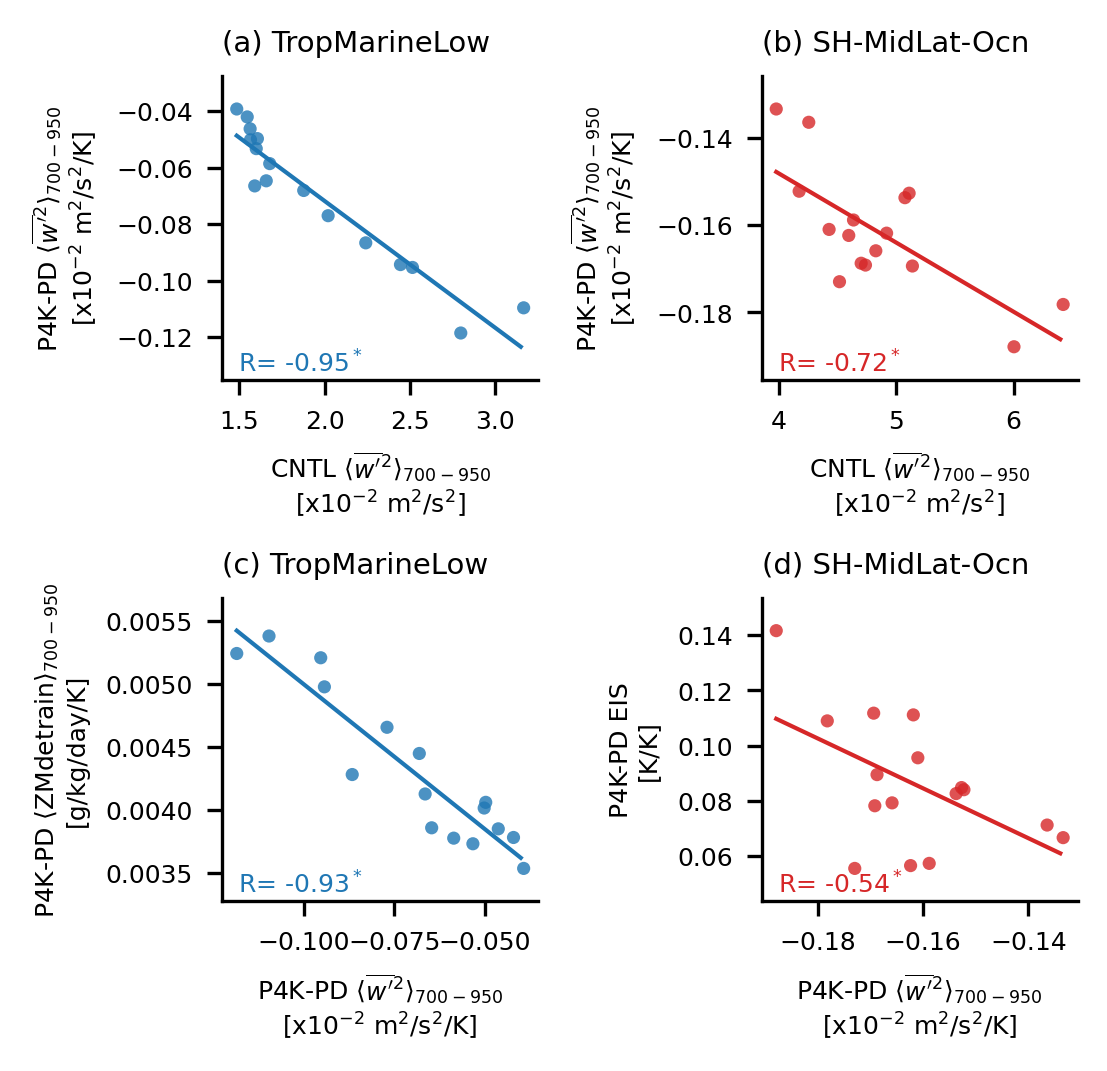

In [49]:
for fig_tag in ['Figure4d-h', 'FigureS9','FigureS11']:
    print() 
    print("===================================")  
    print("Plotting figure = ", fig_tag)  
    print()

    import scipy 
    importlib.reload(misc) 

    regimes_here = [
        ['Global-Ocn', 'Global-Ocn', ['turbulence'], [turbc],'tab:grey'], 
        ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
        ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
        ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
    ]

    nrow = 5
    ncol = 3 
    fig = plt.figure(figsize=(5.5,5/3*nrow),dpi=300)

    gs = GridSpec(nrow,ncol) 
    ax00 = fig.add_subplot(gs[0,0]) 
    ax10 = fig.add_subplot(gs[1,0])
    ax20 = fig.add_subplot(gs[2,0]) 
    ax30 = fig.add_subplot(gs[3,0]) 
    ax40 = fig.add_subplot(gs[4,0]) 

    ax01 = fig.add_subplot(gs[0,1]) 
    ax11 = fig.add_subplot(gs[1,1]) 
    ax21 = fig.add_subplot(gs[2,1]) 
    ax31 = fig.add_subplot(gs[3,1]) 
    ax41 = fig.add_subplot(gs[4,1]) 

    ax02 = fig.add_subplot(gs[0,2]) 
    ax12 = fig.add_subplot(gs[1,2]) 
    ax22 = fig.add_subplot(gs[2,2])  
    ax32 = fig.add_subplot(gs[3,2])  
    ax42 = fig.add_subplot(gs[4,2])  

    # ==========================================================================================
    if fig_tag == 'Figure4d-h': 
        # WP2 and CLDLIQ - Figure 4d-h
        lev1,lev2 = 80000, 70000 
        lev3,lev4 = 95000, 85000 
        varlist = [
            # ax, panel_id, regime_id, var_x, var_y 
            [ax00, '(d)', regimes_here[1], 'WP2_CLUBB.ctl', 'CLDLIQ.ctl', lev1, lev2, lev1, lev2], 
            [ax01, '(e)', regimes_here[2], 'WP2_CLUBB.ctl', 'CLDLIQ.ctl', lev1, lev2, lev1, lev2], 
            [ax02, '(f)', regimes_here[3], 'WP2_CLUBB.ctl', 'CLDLIQ.ctl', lev1, lev2, lev1, lev2], 
            
            [ax11, '(g)', regimes_here[2], 'DPDLFLIQ.dif', 'CLDLIQ.dif', lev3, lev4, lev3, lev4], 
            [ax12, '(h)', regimes_here[3], 'EIS.dif', 'CLDLIQ.dif', lev3, lev4, lev3, lev4],
            ]
    elif fig_tag == 'FigureS9': 
        # # ==========================================================================================
        # # WP2, CLDLIQ and buoyancy flux - SP figure
        lev1x, lev2x = 80000, 70000
        lev1y, lev2y = 80000, 70000
        varlist = [
            [ax00, '(a)', regimes_here[1], 'CLDLIQ.ctl', 'WPRCP_CLUBB.ctl', lev1x, lev2x, lev1y, lev2y],
            [ax01, '(b)', regimes_here[2], 'CLDLIQ.ctl', 'WPRCP_CLUBB.ctl', lev1x, lev2x, lev1y, lev2y],
            [ax02, '(c)', regimes_here[3], 'CLDLIQ.ctl', 'WPRCP_CLUBB.ctl', lev1x, lev2x, lev1y, lev2y], 

            [ax10, '(d)', regimes_here[1], 'CLDLIQ.dif', 'WPRCP_CLUBB.dif', lev1x, lev2x, lev1y, lev2y],
            [ax11, '(e)', regimes_here[2], 'CLDLIQ.dif', 'WPRCP_CLUBB.dif', lev1x, lev2x, lev1y, lev2y],
            [ax12, '(f)', regimes_here[3], 'CLDLIQ.dif', 'WPRCP_CLUBB.dif', lev1x, lev2x, lev1y, lev2y], 

            [ax20, '(g)', regimes_here[1], 'WPRCP_CLUBB.dif', 'WP2_CLUBB.dif', lev1x, lev2x, lev1y, lev2y],
            [ax21, '(h)', regimes_here[2], 'WPRCP_CLUBB.dif', 'WP2_CLUBB.dif', lev1x, lev2x, lev1y, lev2y],
            [ax22, '(i)', regimes_here[3], 'WPRCP_CLUBB.dif', 'WP2_CLUBB.dif', lev1x, lev2x, lev1y, lev2y],
        ] 
    elif fig_tag == 'FigureS11': 
        # # ==========================================================================================
        # # WP2, EIS/ZMdetrain - SP figure 
        lev1x, lev2x = 95000, 70000 
        # lev1x, lev2x = 95000, 85000 
        varlist = [    
            [ax00, '(a)', regimes_here[2], 'WP2_CLUBB.ctl', 'WP2_CLUBB.dif', lev1x, lev2x, lev1x, lev2x], 
            [ax01, '(b)', regimes_here[3], 'WP2_CLUBB.ctl', 'WP2_CLUBB.dif', lev1x, lev2x, lev1x, lev2x], 

            [ax10, '(c)', regimes_here[2], 'WP2_CLUBB.dif', 'DPDLFLIQ.dif', lev1x, lev2x, lev1x, lev2x], 
            [ax11, '(d)', regimes_here[3], 'WP2_CLUBB.dif', 'EIS.dif', lev1x, lev2x, lev1x, lev2x], 
        ] 


    axes = [] 
    ii = 0 
    for gs_plot, panel_id, regime_id, var1, var2, lev1x, lev2x, lev1y, lev2y in varlist: 
        axes.append(gs_plot) 

        df = pd.DataFrame()
        var1_has_level = False
        var2_has_level = False 
        for ivar,var_test in enumerate([var1,var2]):
            if ivar == 0: 
                lev1, lev2 = lev1x, lev2x
            else:
                lev1, lev2 = lev1y, lev2y 

            var_test_here = var_test.split('.')[0]
            var_test_exp = var_test.split('.')[1] 

            if var_test_here in ['CRK_tau','CRK_amt','CRK','CRK_SW','CRK_LW','CRK_SW_tau','CRK_LW_tau']: 
                dics_test = dics_fbk_4yr
            else: 
                dics_test = dics_fbk_state

            var_test_unit, var_test_scale, var_test_label = misc.get_var_unit(var_test_here) 
            # print(var_test_here, var_test_unit, var_test_scale, var_test_label)

            name_aci, name_fbk, included_categories_labels, included_categories,regime_color = regime_id  
        
            for case in cases_t:  
                if var_test_here in ['CRK_tau','CRK_amt','CRK','CRK_SW','CRK_LW','CRK_SW_tau','CRK_LW_tau']:
                    _, Vars_fbk = misc.get_aer_method_info(var_test_here) 
                    data1 = v1v2.area_averager(dics_test[var_test_here][case][Vars_fbk[0]][name_aci+'_avg'])
                else: 
                    data1 = dics_test[var_test_here][case][var_test_here+'_pi_clim'][name_fbk+'_avg'] * var_test_scale 
                    data2 = dics_test[var_test_here][case][var_test_here+'_ab_clim'][name_fbk+'_avg'] * var_test_scale 
                    datad = dics_test[var_test_here][case][var_test_here+'_ano_clim'][name_fbk+'_avg'] * var_test_scale 
                
                # if var_test_here == 'CLDLIQ' and case == 'BASE' and regime_id == regimes_here[1]:  
                #     print('all level = ', datad.plev.values)
                #     print('selected level = ', datad.sel(plev=slice(lev1,lev2)).plev.values )              
                
                if var_test_exp == 'dif': 
                    datap = datad 
                elif var_test_exp == 'ctl':
                    datap = data1 
                
                if 'plev' in list(datap.dims): 
                    df.loc[var_test+'_'+name_aci,case] = datap.sel(plev=slice(lev1,lev2)).mean().values
                    if ivar == 0:
                        var1_has_level = True
                    elif ivar == 1:
                        var2_has_level = True 
                else:
                    df.loc[var_test+'_'+name_aci,case] = datap.values

        # display(df) 

        # ======= Plotting ========================================= 
        var1h = var1.split('.')[0]
        var2h = var2.split('.')[0] 
        
        xx = df.loc[var1+'_'+name_fbk,:]
        yy = df.loc[var2+'_'+name_fbk,:]

        var1_unit, var1_scale, var1_label = misc.get_var_unit(var1h)
        var2_unit, var2_scale, var2_label = misc.get_var_unit(var2h)  

        if var2 == 'DPDLFLIQ': 
            var2_tmp_scale = 1e3 
            var2_tmp_unit = 'x 10$^{-3}$ '+var2_unit 
        else:
            var2_tmp_scale = 1.0 
            var2_tmp_unit = var2_unit 

        if var1 == 'DPDLFLIQ': 
            var1_tmp_scale = 1e3 
            var1_tmp_unit = 'x 10$^{-3}$ '+var1_unit 
        else:
            var1_tmp_scale = 1.0 
            var1_tmp_unit = var1_unit 

        # print(var2_tmp_unit)  

        xx = xx * var1_tmp_scale
        yy = yy * var2_tmp_scale 
        
        cor,pval = scipy.stats.pearsonr(xx,yy)  
        # print(cor,pval)

        ax = gs_plot 
        ax.scatter(xx, yy, s=10, fc=regime_color,alpha=0.8,ec=None)   

        # Regression line
        xpos = 0.05 
        ypos = 0.1
        _, _,_ = misc.add_regress_line(xx, yy,ax,xpos=xpos,ypos=ypos,add_line=True,color=regime_color,
                                                show_pvalue=False,show_text=True,transform_format='axes',prefix_str='',auto_move_text=True)

        
        p_intervals_x = str(int(lev2x/100))+'-'+str(int(lev1x/100))
        p_intervals_y = str(int(lev2y/100))+'-'+str(int(lev1y/100)) 

        if var1.split('.')[1] == 'dif':
            if var1_has_level:  
                xlabel = rf'P4K-PD $\langle${var1_label}$\rangle_{{{p_intervals_x}}}$'+'\n['+var1_tmp_unit+'/K]' 
            else:
                xlabel = rf'P4K-PD {var1_label}'+'\n['+var1_tmp_unit+'/K]'  
        else:
            if var1_has_level: 
                xlabel = rf'CNTL $\langle${var1_label}$\rangle_{{{p_intervals_x}}}$'+'\n['+var1_tmp_unit+']' 
            else:
                if var1h == 'CRK_tau': 
                    xlabel = rf'CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                elif var1h == 'CRK_amt': 
                    xlabel = rf'CF$_{{amt}}$'+'\n[W/m$^2$/K]'  
                elif var1h == 'CRK_SW': 
                    xlabel = rf'SW CF'+'\n[W/m$^2$/K]'  
                elif var1h == 'CRK_LW': 
                    xlabel = rf'LW CF'+'\n[W/m$^2$/K]'  
                elif var1h == 'CRK_SW_tau': 
                    xlabel = rf'SW CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                elif var1h == 'CRK_LW_tau': 
                    xlabel = rf'LW CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                else: 
                    xlabel = rf'CNTL {var1_label}'+'\n['+var1_tmp_unit+']'

        ax.set_xlabel(xlabel) 

        if var2.split('.')[1] == 'dif': 
            if var2_has_level: 
                ylabel = rf'P4K-PD $\langle${var2_label}$\rangle_{{{p_intervals_y}}}$'+'\n['+var2_tmp_unit+'/K]'
            else: 
                ylabel = 'P4K-PD '+var2_label+'\n['+var2_tmp_unit+'/K]'
        else:
            if var2_has_level: 
                ylabel = rf'CNTL $\langle${var2_label}$\rangle_{{{p_intervals_y}}}$'+'\n['+var2_tmp_unit+']' 
            else: 
                if var2h == 'CRK_tau': 
                    ylabel = rf'CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                elif var2h == 'CRK_amt': 
                    ylabel = rf'CF$_{{amt}}$'+'\n[W/m$^2$/K]'  
                elif var2h == 'CRK_SW': 
                    ylabel = rf'SW CF'+'\n[W/m$^2$/K]'  
                elif var2h == 'CRK_LW': 
                    ylabel = rf'LW CF'+'\n[W/m$^2$/K]'  
                elif var2h == 'CRK_SW_tau': 
                    ylabel = rf'SW CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                elif var2h == 'CRK_LW_tau': 
                    ylabel = rf'LW CF$_{{tau}}$'+'\n[W/m$^2$/K]'  
                else: 
                    ylabel = 'CNTL '+var2_label+'\n['+var2_tmp_unit+']' 
        ax.set_ylabel(ylabel) 


        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)

        ax.set_title(panel_id+' '+name_fbk, loc='left') 

        # Automatically adjust y-axis limits
        y_min, y_max = ax.get_ylim()
        margin = 0.08 * (y_max - y_min)  # Add a 5% margin
        new_y_min = y_min - margin
        new_y_max = y_max + margin
        ax.set_ylim(new_y_min, new_y_max)

        if 'CRK' in var2 and 'CRK' in var1: 
            if name_fbk == 'TropAscent': 
                y_range = 1.1  
                x_range = 1.1  
            elif name_fbk == 'TropMarineLow':
                x_range = 0.5
                y_range = 0.5 
            elif name_fbk == 'SH-MidLat-Ocn':
                x_range = 0.5 
                y_range = 0.5 
                
            new_x, new_y = misc.update_x_limits(ax.get_xlim(), x_range)   
            ax.set_xlim((new_x, new_y)) 

            new_x, new_y = misc.update_x_limits(ax.get_ylim(), y_range) 
            ax.set_ylim((new_x, new_y)) 

            ax.axhline(y=0,ls=':',c='grey')
            ax.axvline(x=0,ls=':',c='grey') 
        
        ii += 1 

    # ====== Remove those axes not used ==================================== 
    for ax in [ax00,ax10,ax20,ax30,ax40,ax01,ax11,ax21,ax31,ax41,ax02,ax12,ax22,ax32,ax42]:
        if ax not in axes:
            ax.axis('off') 
            ax.remove() 

    fig.tight_layout() 
    filename = 'Scatterplot_TML_SMO_CldRegime_ZMdetrain_EIS_changes_'+dd+'.pdf'
    plt.show() 


## Scatter plot check aerosol chain (Figure3, FigureS7)


Plotting figure =  Fig3

[['Global-Ocn', 'Global-Ocn', ['turbulence'], ['tab:red'], 'tab:grey'], ['TropAscent', 'TropAscent', ['turbulence'], ['tab:red'], 'tab:orange'], ['TropMarineLow', 'TropMarineLow', ['turbulence'], ['tab:red'], 'tab:blue'], ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], ['tab:red'], 'tab:red']]

Plotting figure =  FigureS7

[['Global-Ocn', 'Global-Ocn', ['turbulence'], ['tab:red'], 'tab:grey'], ['TropAscent', 'TropAscent', ['turbulence'], ['tab:red'], 'tab:orange'], ['TropMarineLow', 'TropMarineLow', ['turbulence'], ['tab:red'], 'tab:blue'], ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], ['tab:red'], 'tab:red']]


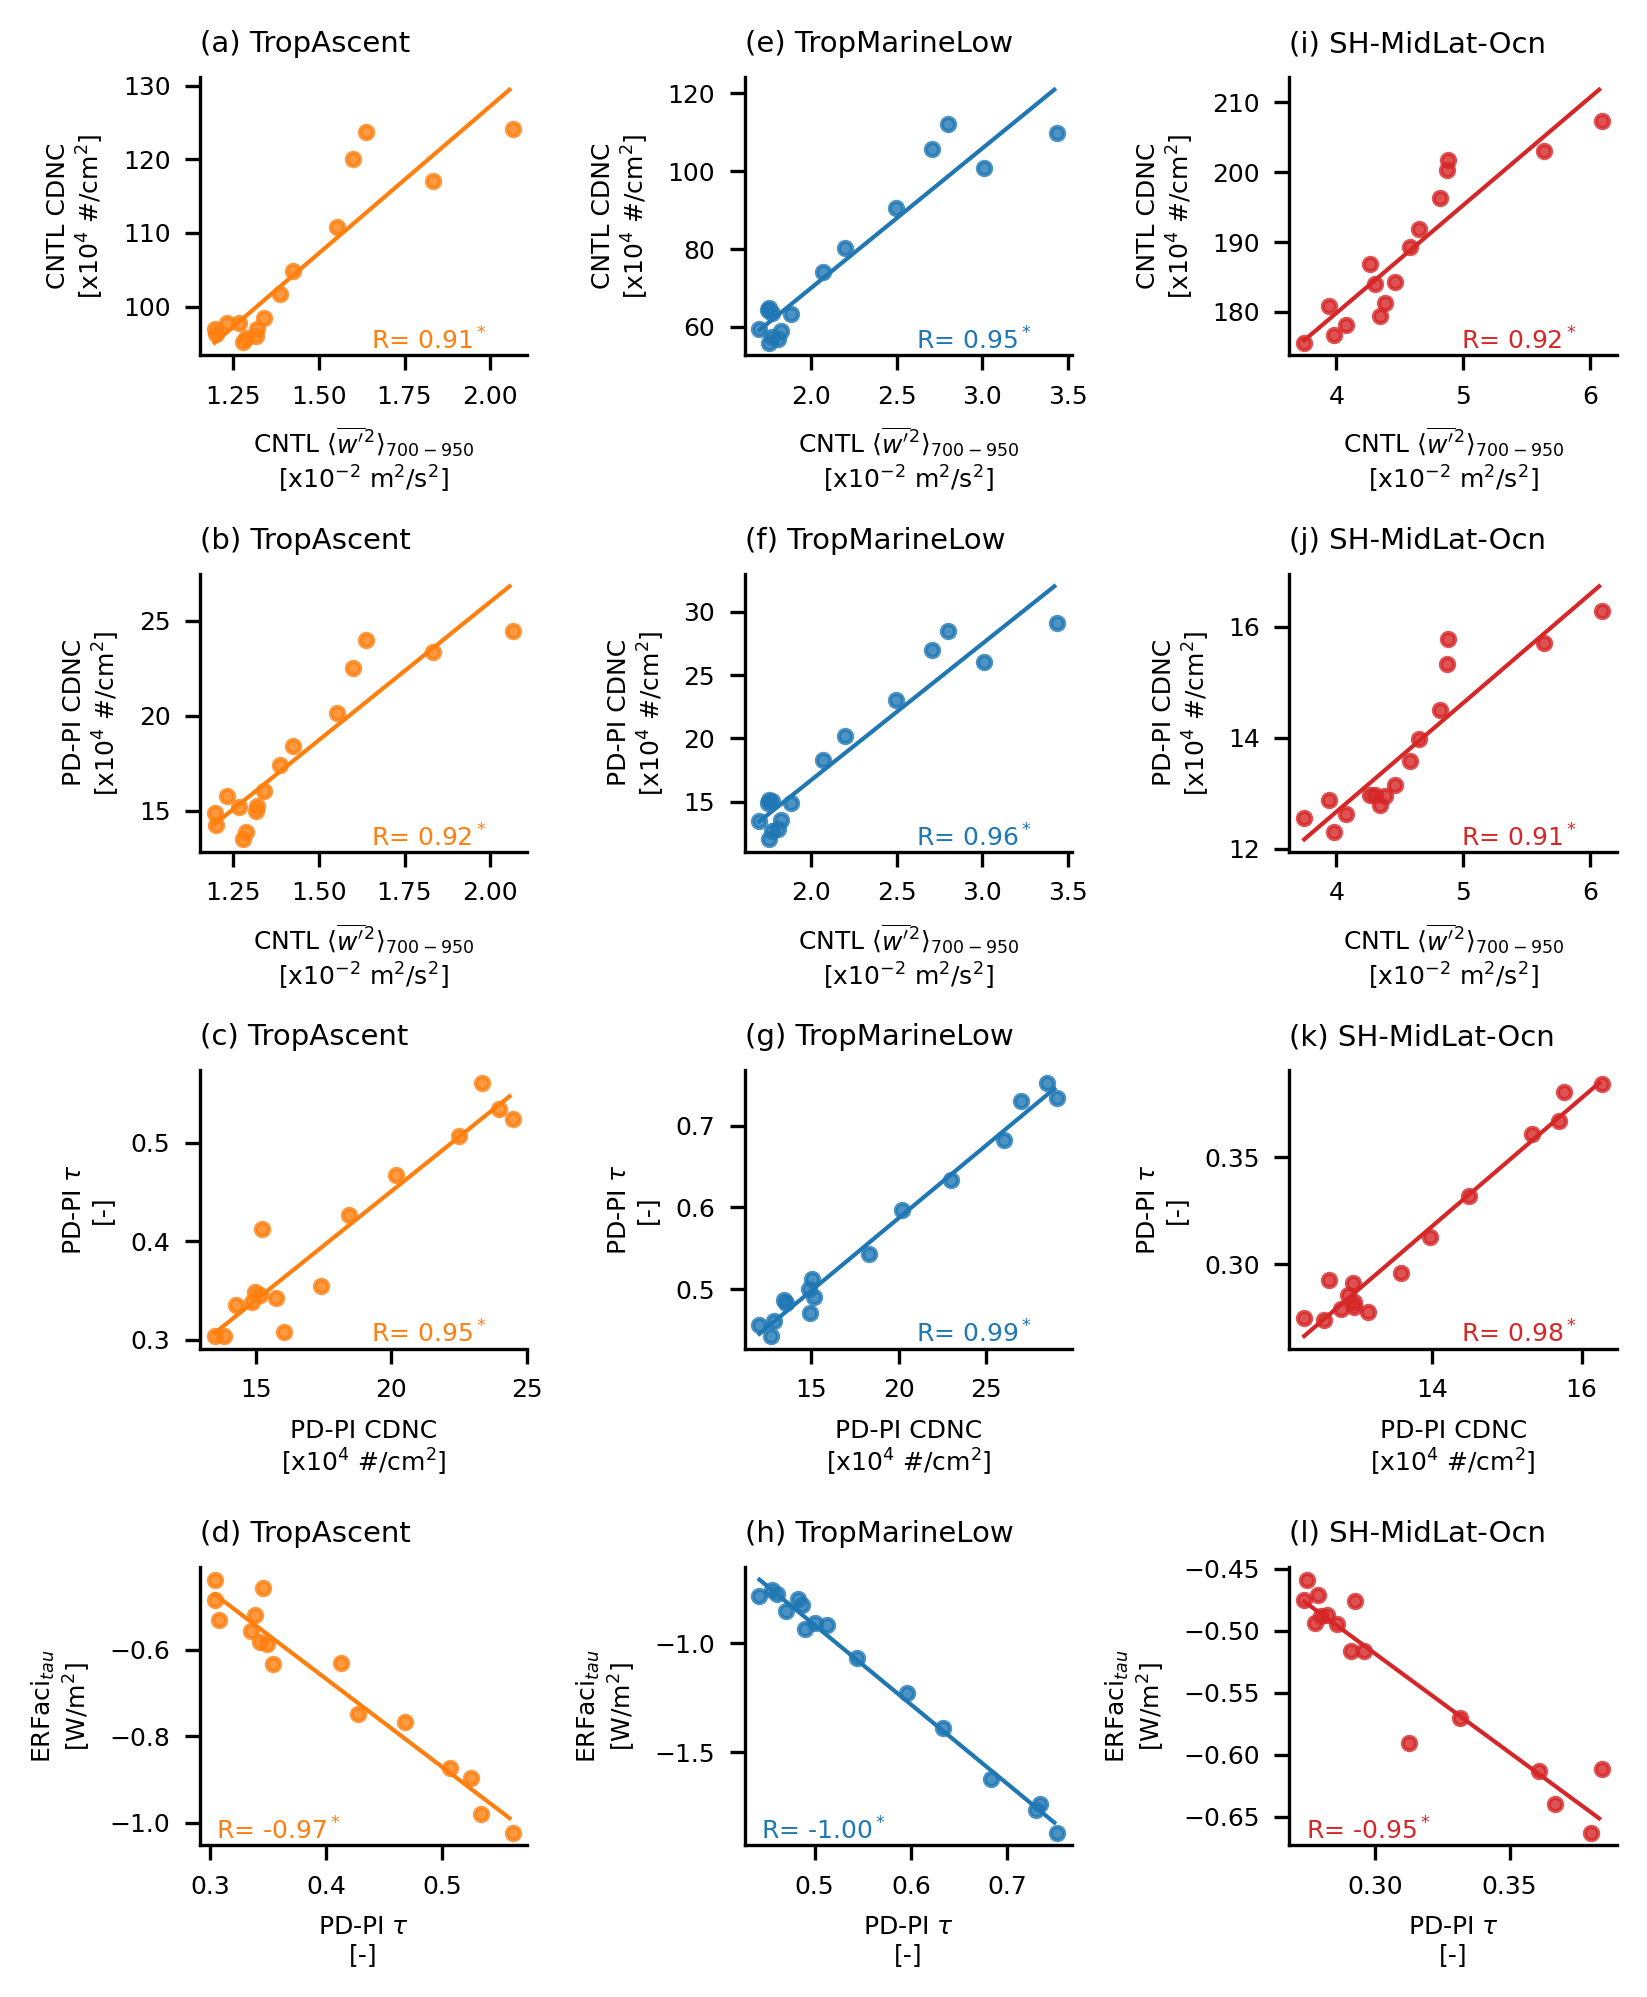

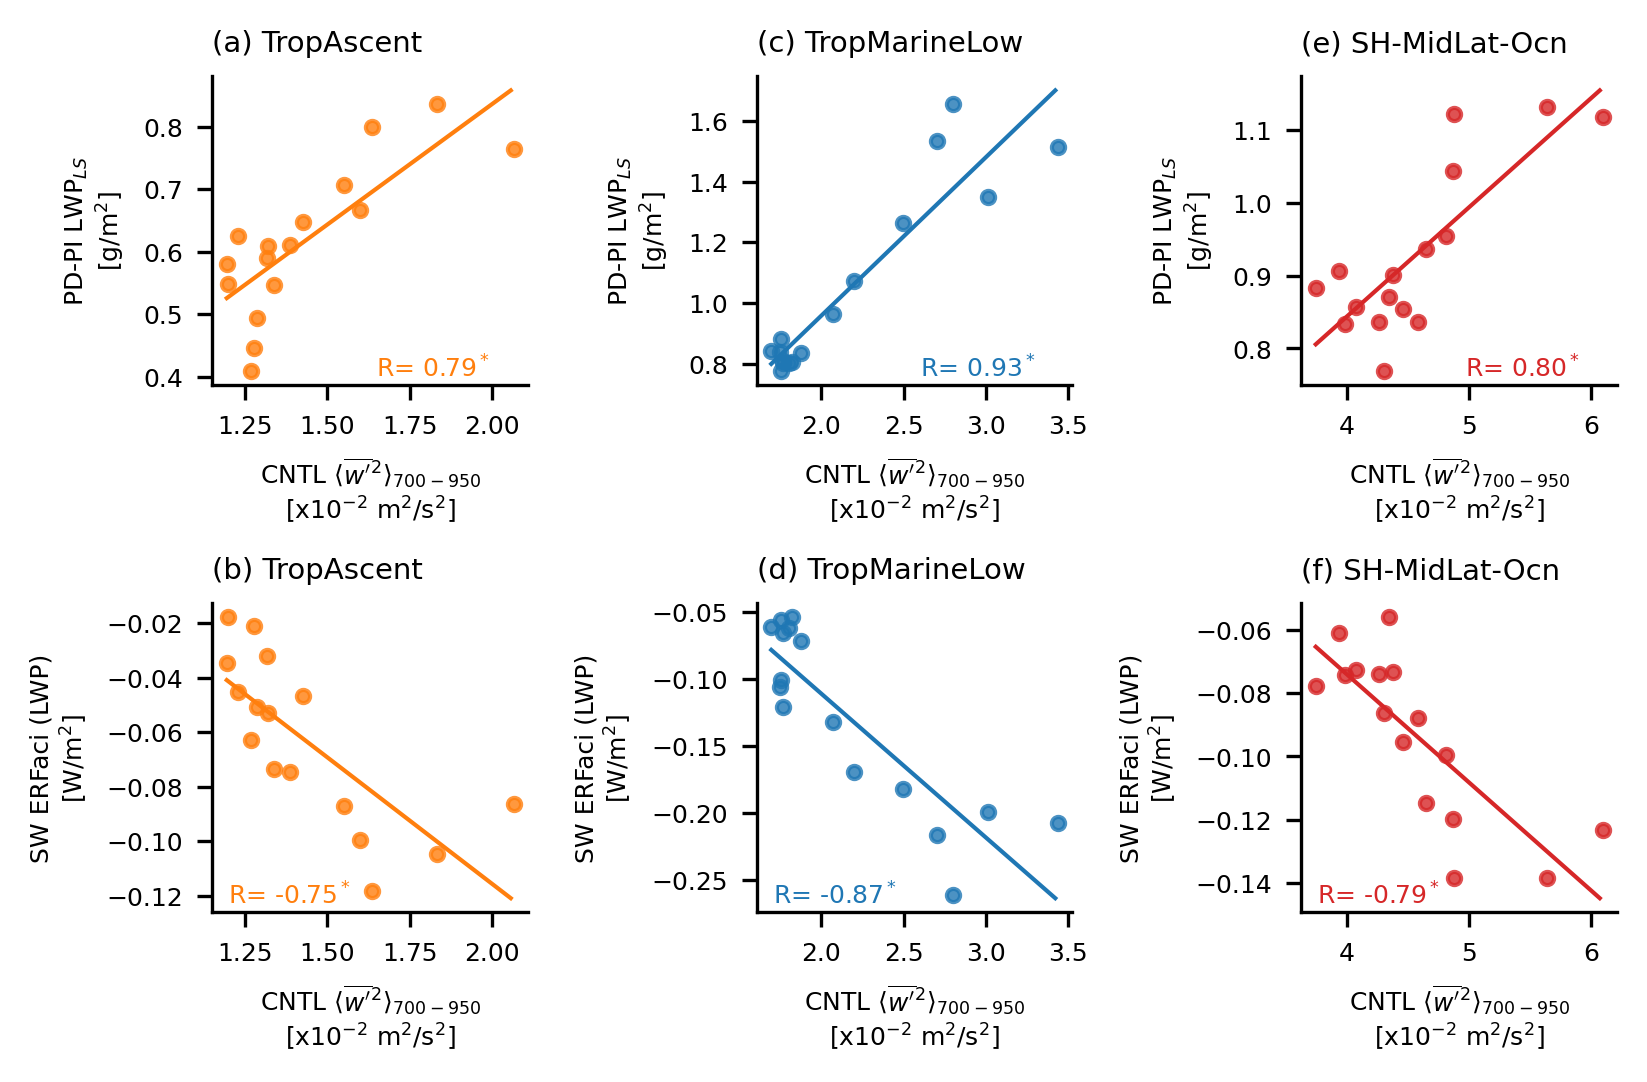

In [53]:
for fig_tag in ['Figure3', 'FigureS7']: 
    print() 
    print("===================================")  
    print("Plotting figure = ", fig_tag)  
    print()

    import scipy 
    importlib.reload(misc) 

    regimes_here = [
        ['Global-Ocn', 'Global-Ocn', ['turbulence'], [turbc],'tab:grey'], 
        ['TropAscent', 'TropAscent', ['turbulence'], [turbc],'tab:orange'], 
        ['TropMarineLow', 'TropMarineLow', ['turbulence'], [turbc],'tab:blue'], 
        ['SH-MidLat-Ocn', 'SH-MidLat-Ocn', ['turblence'], [turbc],'tab:red'], 
    ] 

    print(regimes_here) 

    fig = plt.figure(figsize=(5.5,5/3*4),dpi=300)
    nrow = 4
    ncol = 3 

    gs = GridSpec(nrow,ncol) 
    ax00 = fig.add_subplot(gs[0,0]) 
    ax10 = fig.add_subplot(gs[1,0])
    ax20 = fig.add_subplot(gs[2,0]) 
    ax30 = fig.add_subplot(gs[3,0]) 

    ax01 = fig.add_subplot(gs[0,1]) 
    ax11 = fig.add_subplot(gs[1,1]) 
    ax21 = fig.add_subplot(gs[2,1]) 
    ax31 = fig.add_subplot(gs[3,1]) 

    ax02 = fig.add_subplot(gs[0,2]) 
    ax12 = fig.add_subplot(gs[1,2]) 
    ax22 = fig.add_subplot(gs[2,2])  
    ax32 = fig.add_subplot(gs[3,2])  

    if fig_tag == 'Figure3': 
        # ==========================================================================================
        # WP2, CDNUMC, TAU, ERFaci -- Good. 
        lev1,lev2 = 95000, 70000 
        marker = None 
        varlist = [
            # ax, panel_id, regime_id, var_x, var_y, marker
            [ax00, '(a)', regimes_here[1], 'WP2_CLUBB.ctl', 'CDNUMC.ctl', lev1, lev2, marker], 
            [ax10, '(b)', regimes_here[1], 'WP2_CLUBB.ctl', 'CDNUMC.dif', lev1, lev2, 'o'], 
            [ax20, '(c)', regimes_here[1], 'CDNUMC.dif', 'TAUTMODIS.dif', lev1, lev2, 'o'],
            [ax30, '(d)', regimes_here[1], 'TAUTMODIS.dif', 'CRK_tau.ctl', lev1, lev2, marker],  

            [ax01, '(e)', regimes_here[2], 'WP2_CLUBB.ctl', 'CDNUMC.ctl', lev1, lev2, marker], 
            [ax11, '(f)', regimes_here[2], 'WP2_CLUBB.ctl', 'CDNUMC.dif', lev1, lev2, 'o'], 
            [ax21, '(g)', regimes_here[2], 'CDNUMC.dif', 'TAUTMODIS.dif', lev1, lev2, 'o'], 
            [ax31, '(h)', regimes_here[2], 'TAUTMODIS.dif', 'CRK_tau.ctl', lev1, lev2, marker], 

            [ax02, '(i)', regimes_here[3], 'WP2_CLUBB.ctl', 'CDNUMC.ctl', lev1, lev2, marker], 
            [ax12, '(j)', regimes_here[3], 'WP2_CLUBB.ctl', 'CDNUMC.dif', lev1, lev2, 'o'], 
            [ax22, '(k)', regimes_here[3], 'CDNUMC.dif', 'TAUTMODIS.dif', lev1, lev2, 'o'], 
            [ax32, '(l)', regimes_here[3], 'TAUTMODIS.dif', 'CRK_tau.ctl', lev1, lev2, marker], 
        ]
    elif fig_tag == 'FigureS7': 
        # ==========================================================================================
        # WP2, LWP_LS, TAU, ERFaci - Also used to examine the sedimenation-entrainment mechanism... 
        lev1,lev2 = 95000, 70000 
        marker = None 
        varlist = [
            # ax, panel_id, regime_id, var_x, var_y, marker
            [ax00, '(a)', regimes_here[1], 'WP2_CLUBB.ctl', 'LWP_LS.dif', lev1, lev2, 'o'], 
            [ax10, '(b)', regimes_here[1], 'WP2_CLUBB.ctl', 'Gryspeerdt_decomp.ctl', lev1, lev2, 'o'],

            [ax01, '(c)', regimes_here[2], 'WP2_CLUBB.ctl', 'LWP_LS.dif', lev1, lev2, 'o'], 
            [ax11, '(d)', regimes_here[2], 'WP2_CLUBB.ctl', 'Gryspeerdt_decomp.ctl', lev1, lev2, 'o'],

            [ax02, '(e)', regimes_here[3], 'WP2_CLUBB.ctl', 'LWP_LS.dif', lev1, lev2, 'o'], 
            [ax12, '(f)', regimes_here[3], 'WP2_CLUBB.ctl', 'Gryspeerdt_decomp.ctl', lev1, lev2, 'o'],
        ] 


    axes = [] 
    ii = 0 
    for gs_plot, panel_id, regime_id, var1, var2, lev1, lev2, marker in varlist: 

        axes.append(gs_plot) 

        df = pd.DataFrame()
        var1_has_level = False
        var2_has_level = False 
        for ivar,var_test in enumerate([var1,var2]):  
            var_test_here = var_test.split('.')[0]
            var_test_exp = var_test.split('.')[1] 

            var_test_unit, var_test_scale, var_test_label = misc.get_var_unit(var_test_here) 

            if var_test_here in ['CRK_tau']:
                dics_test = dics_aci 
            elif var_test_here in ['Gryspeerdt_decomp']: 
                dics_test = dics_decomp 
            else:  
                dics_test = dics_aci_state

            name_aci, name_fbk, included_categories_labels, included_categories,regime_color = regime_id  
        
            for case in cases_t: 
                if var_test_here in ['CRK_tau']:
                    _, Vars_aer = misc.get_aer_method_info(var_test_here) 
                    data1 = v1v2.area_averager(dics_test[var_test_here][case][Vars_aer[0]][name_aci+'_avg'])
                elif var_test_here in ['Gryspeerdt_decomp']:
                    Vars_aer = ['F_dalbc_lwp']
                    data1 = misc.area_averager(dics_test[var_test_here][case][Vars_aer[0]][name_fbk+'_avg'].squeeze())
                else: 
                    data1 = dics_test[var_test_here][case][var_test_here+'_pi_clim'][name_fbk+'_avg'] * var_test_scale 
                    data2 = dics_test[var_test_here][case][var_test_here+'_ab_clim'][name_fbk+'_avg'] * var_test_scale 
                    datad = dics_test[var_test_here][case][var_test_here+'_ano_clim'][name_fbk+'_avg'] * var_test_scale 
                
                    # # get sqrt(WP2) which really matches the vertical velocity used in aerosol activation scheme
                    # if var_test_here == 'WP2_CLUBB':
                    #     data1 = np.sqrt(data1)
                    #     data2 = np.sqrt(data2)
                    #     datad = data2 - data1 

                if var_test_here == 'CLDLIQ' and case == 'BASE' and regime_id == regimes_here[1]:  
                    print('all level = ', datad.plev.values)
                    print('selected level = ', datad.sel(plev=slice(lev1,lev2)).plev.values )              
                
                if var_test_exp == 'dif': 
                    datap = datad 
                elif var_test_exp == 'ctl':
                    datap = data1 
                
                if 'plev' in list(datap.dims): 
                    df.loc[var_test+'_'+name_aci,case] = datap.sel(plev=slice(lev1,lev2)).mean().values
                    if ivar == 0:
                        var1_has_level = True
                    elif ivar == 1:
                        var2_has_level = True 
                else:
                    df.loc[var_test+'_'+name_aci,case] = datap.values

        # display(df) 

        # ======= Plotting ========================================= 
        var1h = var1.split('.')[0]
        var2h = var2.split('.')[0] 
        
        xx = df.loc[var1+'_'+name_fbk,:]
        yy = df.loc[var2+'_'+name_fbk,:]

        var1_unit, var1_scale, var1_label = misc.get_var_unit(var1h)
        var2_unit, var2_scale, var2_label = misc.get_var_unit(var2h)  

        if var2 == 'DPDLFLIQ': 
            var2_tmp_scale = 1e3 
            var2_tmp_unit = 'x 10$^{-3}$ '+var2_unit 
        else:
            var2_tmp_scale = 1.0 
            var2_tmp_unit = var2_unit 

        if var1 == 'DPDLFLIQ': 
            var1_tmp_scale = 1e3 
            var1_tmp_unit = 'x 10$^{-3}$ '+var1_unit 
        else:
            var1_tmp_scale = 1.0 
            var1_tmp_unit = var1_unit 

        xx = xx * var1_tmp_scale
        yy = yy * var2_tmp_scale 
        
        cor,pval = scipy.stats.pearsonr(xx,yy)  
        # print(cor,pval)

        ax = gs_plot 
        ax.scatter(xx, yy, s=10, c=regime_color,alpha=0.8, marker=marker)   

        # Regression line
        xpos = 0.05 
        ypos = 0.1
        _, _,_ = misc.add_regress_line(xx, yy,ax,xpos=xpos,ypos=ypos,add_line=True,color=regime_color,
                                                show_pvalue=False,show_text=True,transform_format='axes',prefix_str='',auto_move_text=True)

        
        p_intervals = str(int(lev2/100))+'-'+str(int(lev1/100)) 

        if var1.split('.')[1] == 'dif':
            if var1_has_level:  
                xlabel = rf'PD-PI $\langle${var1_label}$\rangle_{{{p_intervals}}}$'+'\n['+var1_tmp_unit+']' 
            else:
                xlabel = rf'PD-PI {var1_label}'+'\n['+var1_tmp_unit+']'  
        else:
            if var1_has_level: 
                xlabel = rf'CNTL $\langle${var1_label}$\rangle_{{{p_intervals}}}$'+'\n['+var1_tmp_unit+']' 
            else:
                xlabel = rf'CNTL {var1_label}'+'\n['+var1_tmp_unit+']'

        ax.set_xlabel(xlabel) 

        if var2.split('.')[1] == 'dif': 
            if var2_has_level: 
                ylabel = rf'PD-PI $\langle${var2_label}$\rangle_{{{p_intervals}}}$'+'\n['+var2_tmp_unit+']'
            else: 
                ylabel = 'PD-PI '+var2_label+'\n['+var2_tmp_unit+']'
        else:
            if var2_has_level: 
                ylabel = rf'CNTL $\langle${var2_label}$\rangle_{{{p_intervals}}}$'+'\n['+var2_tmp_unit+']' 
            else: 
                if var2h == 'CRK_tau': 
                    ylabel = rf'ERFaci$_{{tau}}$'+'\n[W/m$^2$]' 
                elif var2h == 'Gryspeerdt_decomp':
                    ylabel = 'SW ERFaci (LWP)'+'\n['+var2_tmp_unit+']'
                else: 
                    ylabel = 'CNTL '+var2_label+'\n['+var2_tmp_unit+']' 
        ax.set_ylabel(ylabel) 


        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)

        ax.set_title(panel_id+' '+name_fbk, loc='left')

        ii += 1 

    # ====== Remove those axes not used ==================================== 
    for ax in [ax00,ax10,ax20,ax30,ax01,ax11,ax21,ax31,ax02,ax12,ax22,ax32]:
        if ax not in axes:
            ax.axis('off') 
            ax.remove() 

    fig.tight_layout() 
    filename = 'Scatterplot_check_aerosol_chains_'+dd+'.pdf'
    # fig.savefig(figdir+filename, bbox_inches='tight') 


## Examine correspondence of different methods (FigureS2-S3)


Plotting figure =  FigureS2

c1 [['BASE', 'black', 2.4], ['c1', 'tab:red', 1.335], ['c1_2', 'tab:red', 4.0], ['c1_3', 'tab:red', 1.0], ['c1_4', 'tab:red', 5.0]]
c8 [['BASE', 'black', 5.2], ['c8', 'tab:red', 2.6], ['c8_2', 'tab:red', 7.5], ['c8_3', 'tab:red', 2.0], ['c8_4', 'tab:red', 8.0]]
gamma_coef [['BASE', 'black', 0.12], ['gamma_coef', 'tab:red', 0.32], ['gamma_coef_2', 'tab:red', 0.42], ['gamma_coef_3', 'tab:red', 0.22], ['gamma_coef_4', 'tab:red', 0.52]]
gamma_coefb [['BASE', 'black', 0.28], ['gamma_coefb', 'tab:red', 0.6], ['gamma_coefb_2', 'tab:red', 0.83], ['gamma_coefb_3', 'tab:red', 0.1]]
16 16
[array(0.3687517), array(0.43676481), array(0.44325796), array(0.32237302), array(0.44832369), array(0.43726503), array(0.29926776), array(0.35706467), array(0.38648976), array(0.46221858), array(0.38691877), array(0.41606945), array(0.4036007), array(0.47426862), array(0.45216264), array(0.37980217)]
[array(0.49740575), array(0.58907246), array(0.55340744), array(0.45876531), array

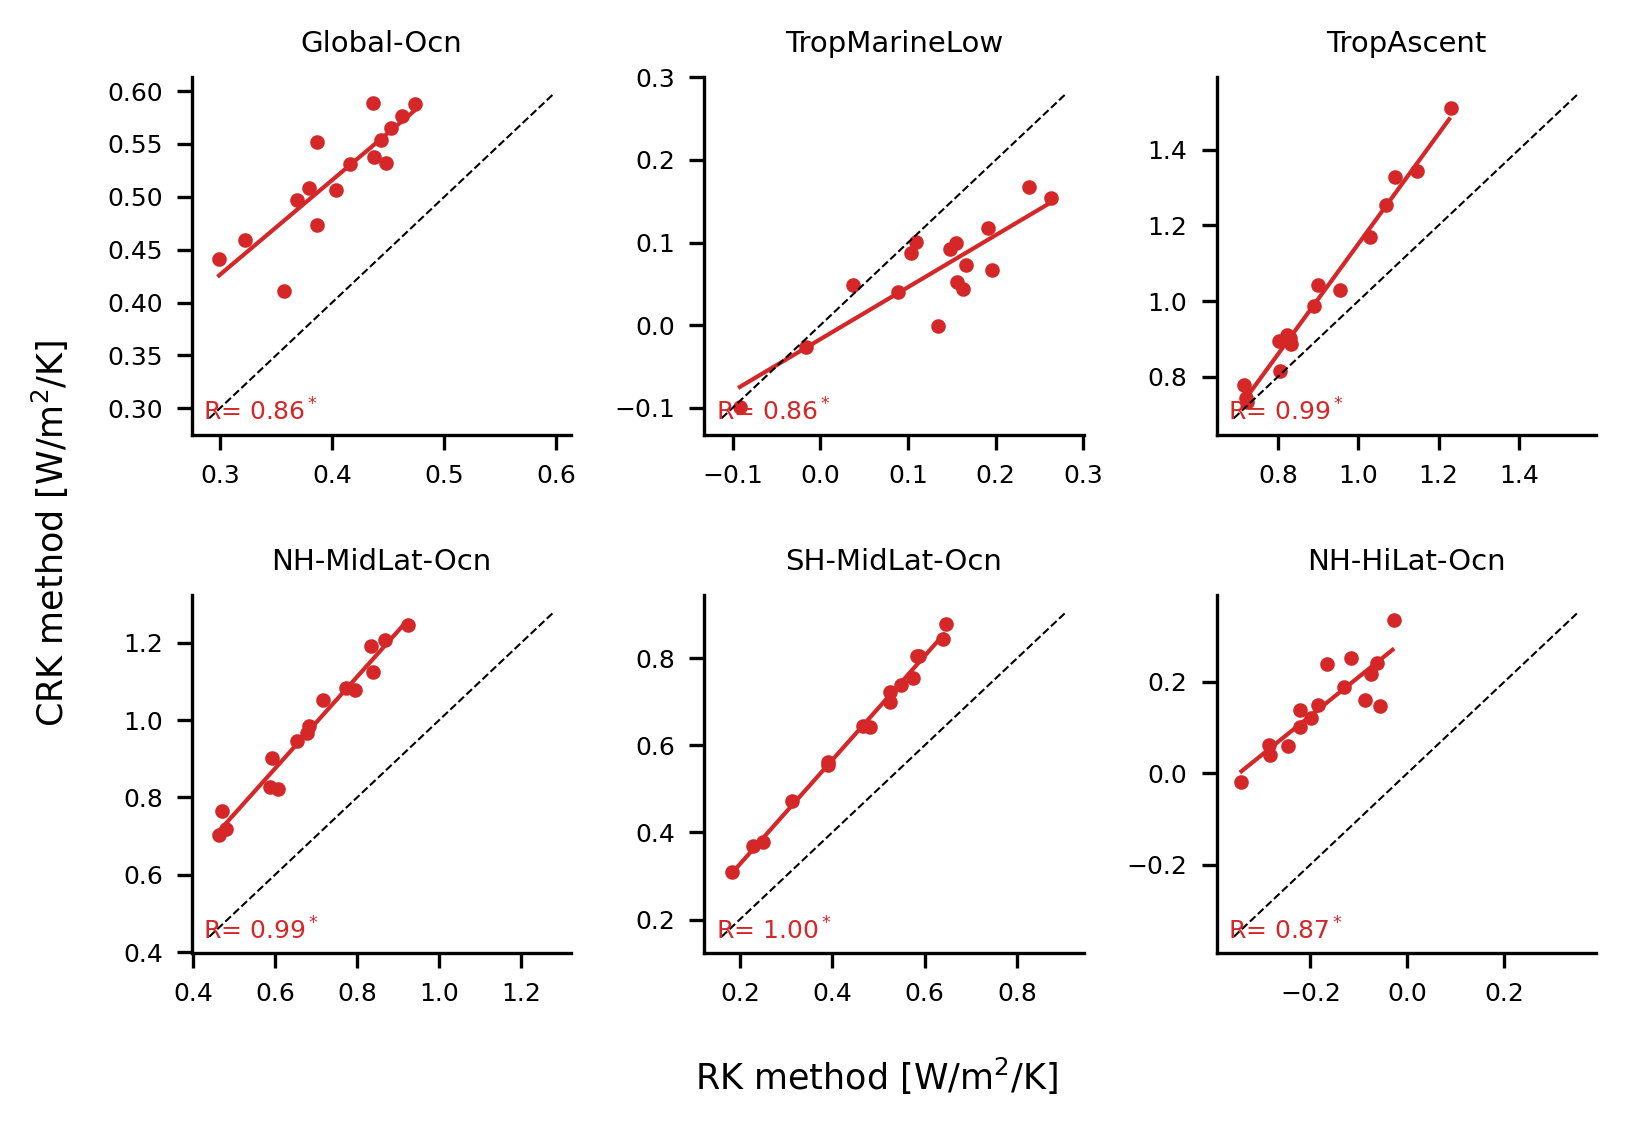

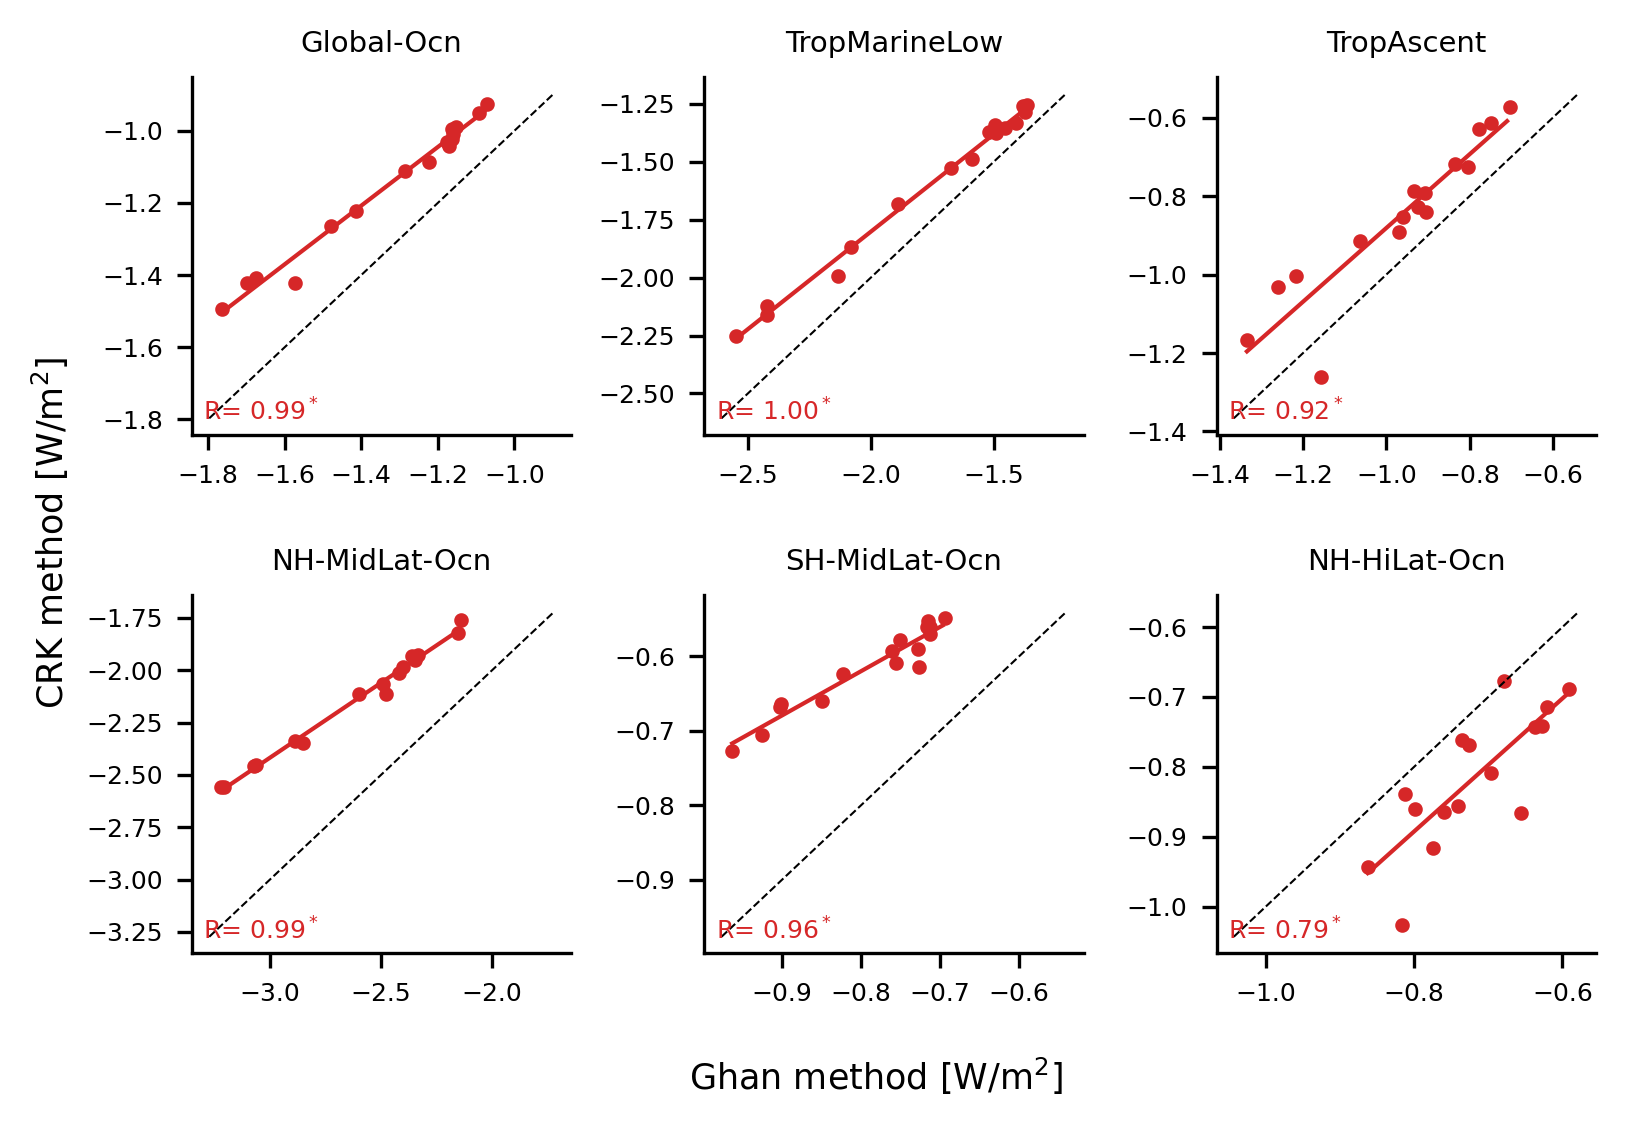

In [56]:
for fig_tag in ['FigureS2','FigureS3']: 
    print() 
    print("===================================")  
    print("Plotting figure = ", fig_tag)  
    print()


    regimes_plot_here = ['Global-Ocn','TropMarineLow','TropAscent','NH-MidLat-Ocn','SH-MidLat-Ocn','NH-HiLat-Ocn']

    fbk_datasource1 = 'RK'
    _,Vars_fbk1 = misc.get_fbk_method_info(fbk_datasource1) 
    fbk_datasource2 = 'CRK'
    _,Vars_fbk2 = misc.get_fbk_method_info(fbk_datasource2) 

    aer_datasource1 = 'Ghan'
    _,Vars_aer1 = misc.get_aer_method_info(aer_datasource1)
    aer_datasource2 = 'CRK'
    _,Vars_aer2 = misc.get_aer_method_info(aer_datasource2) 

    if fig_tag == 'FigureS2':        
        tag = fbk_datasource1+'_vs_'+fbk_datasource2
    elif fig_tag == 'FigureS3': 
        tag = aer_datasource1+'_vs_'+aer_datasource2


    fig = plt.figure(figsize=(6,4),dpi=300)  
    nrow = 2
    ncol = 3  

    ii = 0 
    # Loop over each regime for ERFaci/CFBK
    for name in regimes_plot_here:    

        ax = fig.add_subplot(nrow,ncol,ii+1)
        ax.set_title(textwrap.fill(name,15)) 

        XXa = []
        YYa = []
        YY2a = [] 
        casesa = [] 
        for iexp,exp in enumerate(dicc.keys()): # loop over each parameter 
            casesA = dicc[exp] 
            print(exp, casesA) 

            cases_here = [case[0] for case in casesA]
            colors_here = [case[1] for case in casesA]
            values = [case[2] for case in casesA]

            for icase,case in enumerate(cases_here): 
                caseid = cases_here.index(case)

                if case not in casesa:
                    casesa.append(case)
                else:
                    continue 

                if tag == fbk_datasource1+'_vs_'+fbk_datasource2: 
                    xx = v1v2.area_averager(dics_fbk_4yr[fbk_datasource1][case][Vars_fbk1[0]][name+'_avg'])
                    yy = v1v2.area_averager(dics_fbk_4yr[fbk_datasource2][case][Vars_fbk2[0]][name+'_avg'])
                
                if tag == aer_datasource1+'_vs_'+aer_datasource2:   
                    xx = v1v2.area_averager(dics_aci[aer_datasource1][case][Vars_aer1[0]][name+'_avg'])
                    yy = v1v2.area_averager(dics_aci[aer_datasource2][case][Vars_aer2[0]][name+'_avg'])

                cc = colors_here[icase] 
                ax.plot(xx,yy, marker='.',ms=5, c='tab:red')
                # ax.text(xx,yy,case,fontsize=5,ha='right')

                if 'nomincdnc.' in exp: 
                    ref_case_name = 'nomincdnc'
                else:
                    ref_case_name = 'BASE'

                if case == ref_case_name:
                    fbk_base = xx
                    aci_base = yy 

                XXa.append(xx.values)
                YYa.append(yy.values) 
                

        print(len(XXa),len(YYa))
        print(XXa)
        print(YYa)

        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Show only the left and bottom ticks
        ax.tick_params(axis='x', bottom=True, top=False)
        ax.tick_params(axis='y', left=True, right=False)

        # # ======================== reset axis limits ===============================
        # if name in ['Global']:
        #     y_range = 1.4     
        #     x_range = 0.44
        # else:
        #     y_range = 0.42  
        #     x_range = 0.19
                
        # new_x, new_y = misc.update_x_limits(ax.get_xlim(), x_range)   
        # ax.set_xlim((new_x, new_y)) 
        # new_x, new_y = misc.update_x_limits(ax.get_ylim(), y_range) 
        # ax.set_ylim((new_x, new_y))

        # plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        # plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) 

        if tag == fbk_datasource1+'_vs_'+fbk_datasource2:  
            fig.supxlabel(fbk_datasource1+' method [W/m$^2$/K]',y=0.03) 
            fig.supylabel(fbk_datasource2+' method [W/m$^2$/K]',x=0.03)   
        
        if tag == aer_datasource1+'_vs_'+aer_datasource2:   
            fig.supxlabel(aer_datasource1+' method [W/m$^2$]',y=0.03) 
            fig.supylabel(aer_datasource2+' method [W/m$^2$]',x=0.03)   

        # ======================== Regression ======================== 
        prefix_str=''
        misc.add_regress_line(XXa,YYa,ax,xpos=0.03,ypos=0.1,add_line=True,color='tab:red',prefix_str=prefix_str)   

        xmin,xmax = ax.get_xlim() 
        ymin,ymax = ax.get_ylim()

        vmin = min([xmin,ymin])
        vmax = max([xmax,ymax]) 
        ax.plot([vmin,vmax], [vmin,vmax],ls='--',c='black',lw=0.5)

        ii += 1 

    # fig.tight_layout() 
    fig.subplots_adjust(left=0.12,bottom=0.15,hspace=0.45,wspace=0.35) 

    filename = tag+'_CldRegime_each_regime_'+dd+'.png'
    # fig.savefig(figdir+filename,bbox_inches='tight')
